<a href="https://colab.research.google.com/github/fujoos/Enhancing-fake-news-detection-in-online-media-through-sentiment-analysis-Dissertation-/blob/main/OSSAI_FRANK_UCHE_DISSERTATION_Large_Multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tqdm
!pip install tensorflow
!pip install transformers
!pip install sentencepiece
!pip install aiohttp

In [2]:
# General Python Libraries
import os
import time
import math
import shutil
import requests
import re
from datetime import datetime
from pathlib import Path
from io import BytesIO
from IPython.display import HTML

# Data Handling and Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as font_manager

# Machine Learning and Deep Learning
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Image Processing
from keras.applications.efficientnet import preprocess_input
from keras.preprocessing import image as keras_image
from keras.applications.resnet50 import ResNet50, preprocess_input

from keras.preprocessing.image import load_img, img_to_array
from PIL import Image, ImageOps

import h5py
from torchvision.transforms import Compose, Resize, ToTensor,  Normalize
import torch.optim as optim

# File Compression
import tarfile

# Progress Monitoring
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

from transformers import BertModel, BertTokenizer, T5Tokenizer, T5EncoderModel, RobertaModel, RobertaTokenizer
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

from io import BytesIO
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
import aiohttp
import asyncio
import nest_asyncio

In [3]:
colab_path  = '/content/'
google_base_drive_path =  '/content/drive/'
google_multimodal_base_folder = 'MyDrive/multimodal_only_samples'
google_drive_path  = Path(google_base_drive_path)
BASE_GOOGLE_DRIVE_DIRECTORY = google_drive_path / google_multimodal_base_folder
BASE_COLAB_DIRECTORY = Path(colab_path)
images_folder_name = "FakeNews Images"
extracted_resized_images_folder_name = "Extracted_Resized_Images"

In [4]:
# Output directory for extracted contents of resized images

resized_image_output_base_directory = BASE_COLAB_DIRECTORY  / images_folder_name
resized_image_output_directory = BASE_COLAB_DIRECTORY  / images_folder_name / extracted_resized_images_folder_name

In [5]:
# Data loading from Google Drive
from google.colab import drive
drive.mount(google_base_drive_path, force_remount=True)

Mounted at /content/drive/


In [6]:
# Define the source and destination directories
poppins_font_folder = 'Poppins'
source_google_poppins_font_directory = BASE_GOOGLE_DRIVE_DIRECTORY / poppins_font_folder
destination_colab_poppins_font_directory =  BASE_COLAB_DIRECTORY / poppins_font_folder

In [7]:
def ensure_folder_exists(folder_path):
    """ Ensure that a folder exists at the specified path. If it doesn't exist, create it. """
    if not os.path.isdir(folder_path):
        os.makedirs(folder_path)
        print(f"Created folder: {folder_path}")
    else:
        print(f"Folder already exists: {folder_path}")

In [8]:
ensure_folder_exists(destination_colab_poppins_font_directory)

Created folder: /content/Poppins


In [9]:
ensure_folder_exists(resized_image_output_base_directory )

Created folder: /content/FakeNews Images


In [10]:
shutil.copytree(source_google_poppins_font_directory  , destination_colab_poppins_font_directory , dirs_exist_ok=True)

PosixPath('/content/Poppins')

In [11]:
# Constants for font paths
POPPINS_FONT_PATH = BASE_COLAB_DIRECTORY / poppins_font_folder

# Setting up font directories and finding font files
font_directories = [destination_colab_poppins_font_directory]
poppins_font_files = font_manager.findSystemFonts(fontpaths=font_directories)

# Adding Poppins font files to the font manager
for font in poppins_font_files:
    font_manager.fontManager.addfont(font)

# Configuring matplotlib to use Poppins font
plt.rcParams['font.family'] = poppins_font_folder
plt.rcParams['font.size'] = 9.5

In [12]:
# CSS to use Poppins font
css = """
<style>
@import url('https://fonts.googleapis.com/css2?family=Poppins:wght@300;400;600&display=swap');
table, th, td {
  font-family: 'Poppins', sans-serif;
}
</style>
"""

def dataframe_to_html_head(df, num_rows=None):
    """
    Convert the first few rows of a DataFrame to HTML. and display HTML with Poppins font

    Parameters:
    df (pd.DataFrame): The DataFrame to convert.
    num_rows (int): The number of rows from the DataFrame's head to convert to HTML.

    Returns:
    str: HTML representation of the DataFrame's first few rows with Poppins font.
    """
    if num_rows is not None:
      return HTML(css + df.head(num_rows).to_html())
    else:
      return HTML(css + df.to_html())

In [13]:
print(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_train.csv')

/content/drive/MyDrive/multimodal_only_samples/multimodal_train.csv


In [14]:
shutil.copy(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_train.csv', BASE_COLAB_DIRECTORY / 'multimodal_train.csv')

PosixPath('/content/multimodal_train.csv')

In [15]:
shutil.copy(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_validate.csv', BASE_COLAB_DIRECTORY / 'multimodal_validate.csv')

PosixPath('/content/multimodal_validate.csv')

In [16]:
shutil.copy(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_test_public.csv', BASE_COLAB_DIRECTORY / 'multimodal_test_public.csv')

PosixPath('/content/multimodal_test_public.csv')

In [17]:
# Load the datasets
train_df = pd.read_csv(BASE_COLAB_DIRECTORY / 'multimodal_train.csv')
validate_df = pd.read_csv(BASE_COLAB_DIRECTORY / 'multimodal_validate.csv')
test_df = pd.read_csv(BASE_COLAB_DIRECTORY / 'multimodal_test_public.csv')

<ipython-input-17-f639c81a6441>:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(BASE_COLAB_DIRECTORY / 'multimodal_train.csv')


In [18]:
# Data Overview: Basic statistics
train_df_overview = {
    "Total Entries": train_df.shape[0],
    "Missing Values": train_df.isnull().sum(),
    "Unique Values": train_df.nunique()
}

# Text Analysis: Length of titles
# Ensure all entries are strings before applying len()
train_df['title_length'] = train_df['title'].astype(str).apply(len)
train_df['clean_title_length'] = train_df['clean_title'].astype(str).apply(len)

text_analysis = {
    "Average Title Length": train_df['title_length'].mean(),
    "Average Clean Title Length": train_df['clean_title_length'].mean(),
    "Max Title Length": train_df['title_length'].max(),
    "Max Clean Title Length": train_df['clean_title_length'].max()
}

# Label Distribution
label_distribution = {
    "2_way_label": train_df['2_way_label'].value_counts(normalize=True),
    "3_way_label": train_df['3_way_label'].value_counts(normalize=True),
    "6_way_label": train_df['6_way_label'].value_counts(normalize=True)
}

# Image URLs: Domain distribution
train_df['image_domain'] = train_df['image_url'].apply(lambda x: x.split('/')[2] if pd.notnull(x) and len(x.split('/')) > 2 else None)
domain_distribution = train_df['image_domain'].value_counts(normalize=True)

train_df_overview, text_analysis, label_distribution, domain_distribution.head()


({'Total Entries': 564212,
  'Missing Values': author                   28744
  clean_title                124
  created_utc                123
  domain                  167981
  hasImage                   124
  id                         211
  image_url                 1745
  linked_submission_id    396355
  num_comments            168069
  score                      212
  subreddit                  212
  title                      222
  upvote_ratio            168230
  2_way_label                373
  3_way_label                373
  6_way_label                373
  dtype: int64,
  'Unique Values': author                  238619
  clean_title             502638
  created_utc             562969
  domain                   10825
  hasImage                     5
  id                      564001
  image_url               547494
  linked_submission_id     51581
  num_comments              1909
  score                    11803
  subreddit                   22
  title                   52248

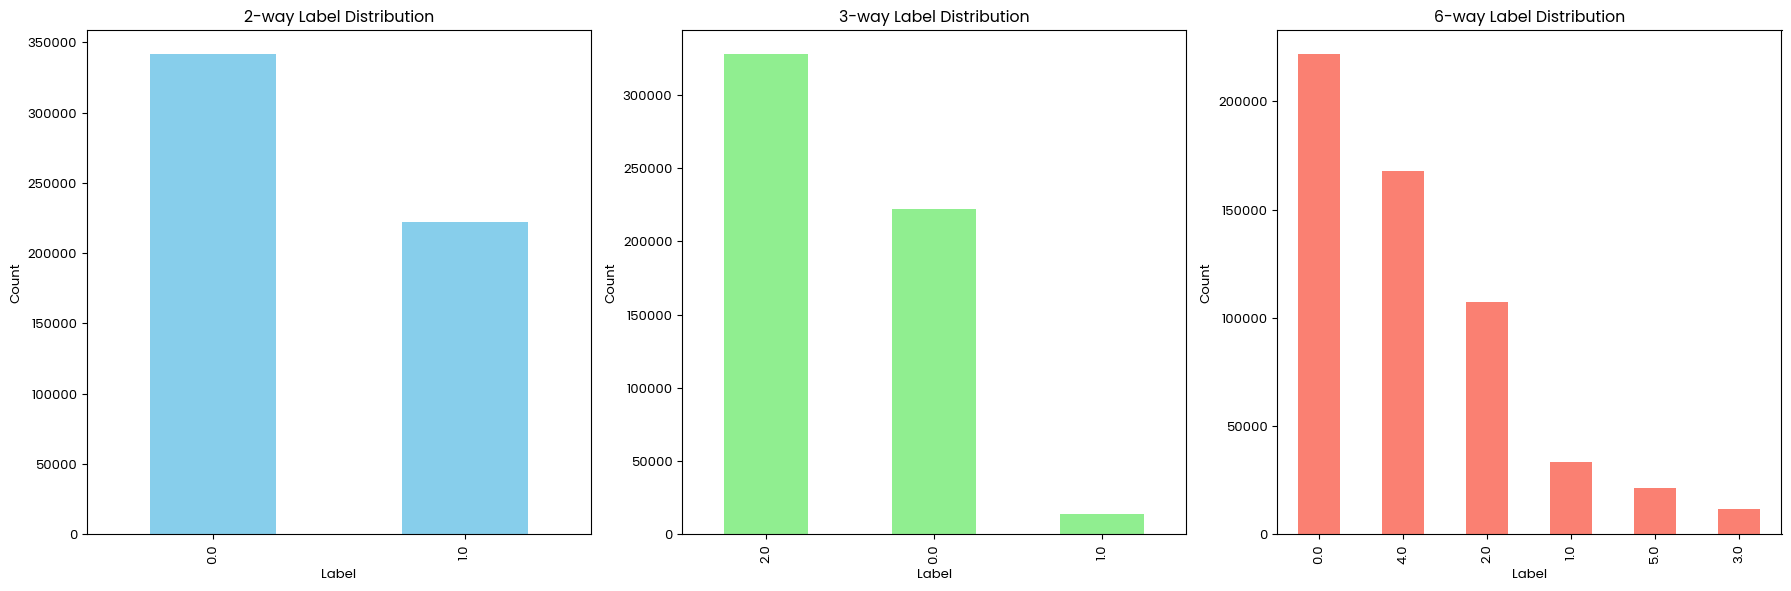

In [19]:
# Plotting the label distribution for 2-way, 3-way, and 6-way labels
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 2-way label distribution
train_df['2_way_label'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('2-way Label Distribution')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')

# 3-way label distribution
train_df['3_way_label'].value_counts().plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('3-way Label Distribution')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

# 6-way label distribution
train_df['6_way_label'].value_counts().plot(kind='bar', ax=axes[2], color='salmon')
axes[2].set_title('6-way Label Distribution')
axes[2].set_xlabel('Label')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [20]:
# Explore the first few rows of each dataset
dataframe_to_html_head(train_df, 5)

In [21]:
dataframe_to_html_head(validate_df, 5)

In [22]:
dataframe_to_html_head(test_df, 5)

In [23]:
# Descriptive statistics and data distribution
dataframe_to_html_head(train_df.describe(), 5)

In [24]:
dataframe_to_html_head(validate_df.describe(), 5)

In [25]:
dataframe_to_html_head(test_df.describe(), 5)

In [26]:
train_df.isnull().sum()

author                   28744
clean_title                124
created_utc                123
domain                  167981
hasImage                   124
id                         211
image_url                 1745
linked_submission_id    396355
num_comments            168069
score                      212
subreddit                  212
title                      222
upvote_ratio            168230
2_way_label                373
3_way_label                373
6_way_label                373
title_length                 0
clean_title_length           0
image_domain              1746
dtype: int64

In [27]:
validate_df.isnull().sum()

author                   3063
clean_title                16
created_utc                16
domain                  17826
hasImage                   16
id                         22
image_url                 195
linked_submission_id    41554
num_comments            17832
score                      22
subreddit                  22
title                      22
upvote_ratio            17853
2_way_label                43
3_way_label                43
6_way_label                43
dtype: int64

In [28]:
test_df.isnull().sum()

author                   3069
clean_title                10
created_utc                10
domain                  17482
hasImage                   10
id                         19
image_url                 175
linked_submission_id    41866
num_comments            17491
score                      19
subreddit                  19
title                      19
upvote_ratio            17509
2_way_label                37
3_way_label                37
6_way_label                37
dtype: int64

In [29]:
# Class distribution (for labeled data)
train_df['2_way_label'].value_counts()

0.0    341856
1.0    221983
Name: 2_way_label, dtype: int64

In [30]:
# Class distribution (for labeled data)
train_df['3_way_label'].value_counts()

2.0    328046
0.0    221983
1.0     13810
Name: 3_way_label, dtype: int64

In [31]:
# Class distribution (for labeled data)
train_df['6_way_label'].value_counts()

0.0    221983
4.0    167857
2.0    107197
1.0     33480
5.0     21538
3.0     11784
Name: 6_way_label, dtype: int64

<font face="Poppins" size=2>Original Title (title): This column likely contains the original titles of posts or articles as they appeared on social media, news websites, or other platforms. The content here would be unaltered and might include a variety of characters, formatting, and styles.<font>

<font face="Poppins" size=2>Cleaned Title (clean_title): The 'clean_title' column, on the other hand, seems to be a pre-processed version of the original title. The cleaning process might involve:<font>

<font face="Poppins" size=2>Lowercasing all text for consistency.
Removing special characters, numbers, or punctuation that may not be relevant for analysis.
Potentially removing stop words or other common phrases that don't contribute to the meaning.
Correcting misspellings or standardizing variations of the same word.<font>

In [32]:
# Define the columns you want to keep
text_columns = ['title', 'clean_title']  # Replace with actual text column names
image_columns = ['image_url']            # Replace with actual image column name
label_columns = ['2_way_label', '3_way_label', '6_way_label']  # Replace with actual label column names

# Combine all relevant columns
relevant_columns = text_columns + image_columns  + label_columns

# Select only relevant columns from each dataframe
selected_columns_train_df = train_df[relevant_columns]
selected_columns_validate_df = validate_df[relevant_columns]
selected_columns_test_df = test_df[relevant_columns]

In [33]:
dataframe_to_html_head(selected_columns_train_df, 5)

In [34]:
# Drop all null values
selected_columns_train_drop_null_df = selected_columns_train_df.dropna()
dataframe_to_html_head(selected_columns_train_drop_null_df.tail())

In [35]:
selected_columns_train_drop_null_df.count()

title          562306
clean_title    562306
image_url      562306
2_way_label    562306
3_way_label    562306
6_way_label    562306
dtype: int64

In [36]:
# Drop duplicates
selected_columns_train_unique_df = selected_columns_train_drop_null_df.drop_duplicates()
selected_columns_train_unique_df.count()

title          560375
clean_title    560375
image_url      560375
2_way_label    560375
3_way_label    560375
6_way_label    560375
dtype: int64

In [37]:
# Save to CSV
selected_columns_train_unique_df.to_csv(BASE_COLAB_DIRECTORY / 'multimodal_selected_columns_unique_rows_train.csv', index=False)
selected_columns_train_unique_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_selected_columns_unique_rows_train.csv', index=False)

In [38]:
selected_columns_test_drop_null_df = selected_columns_test_df.dropna()
selected_columns_test_unique_df = selected_columns_test_drop_null_df.drop_duplicates()
selected_columns_test_unique_df.count()

title          59125
clean_title    59125
image_url      59125
2_way_label    59125
3_way_label    59125
6_way_label    59125
dtype: int64

In [39]:
selected_columns_test_unique_df.isnull().sum()

title          0
clean_title    0
image_url      0
2_way_label    0
3_way_label    0
6_way_label    0
dtype: int64

In [40]:
selected_columns_test_unique_df.to_csv(BASE_COLAB_DIRECTORY / 'multimodal_selected_columns_unique_rows_test.csv', index=False)
selected_columns_test_unique_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_selected_columns_unique_rows_test.csv', index=False)

In [41]:
# Drop all null values
selected_columns_validate_drop_null_df = selected_columns_validate_df.dropna()
selected_columns_validate_unique_df = selected_columns_validate_drop_null_df.drop_duplicates()
selected_columns_validate_unique_df.count()

title          59123
clean_title    59123
image_url      59123
2_way_label    59123
3_way_label    59123
6_way_label    59123
dtype: int64

In [42]:
selected_columns_validate_unique_df.isnull().sum()

title          0
clean_title    0
image_url      0
2_way_label    0
3_way_label    0
6_way_label    0
dtype: int64

In [43]:
selected_columns_validate_unique_df.to_csv(BASE_COLAB_DIRECTORY / 'multimodal_selected_columns_unique_rows_validate.csv', index=False)
selected_columns_validate_unique_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_selected_columns_unique_rows_validate.csv', index=False)

In [44]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# <font face="Poppins" size=2>Download and extract features for Train Data (From Google Drive)<font>

In [ ]:
  # Add your directory path here. This was done locally to speed up the downloads
  # and prevent incessant writes to google drive which causes error in colab
# resized_image_output_directory = 'Extracted_Resized_Images'


# Function to check if an image URL is available
def is_image_url_available(url):
    try:
        response = requests.head(url, allow_redirects=True, timeout=5)
        return response.status_code == 200 and 'image' in response.headers.get('Content-Type', '')
    except requests.RequestException:
        return False

# Function to download and resize an image with padding
def download_and_resize_image(url, target_size=(224, 224)):
    try:
        response = requests.get(url, stream=True, timeout=5)
        response.raise_for_status()

        with Image.open(BytesIO(response.content)) as img:
            img = img.convert('RGB')

            if img.mode == 'P':
                img = img.convert('RGBA')

            # Attempt to process the image even if it's truncated
            try:
                img.load()
            except IOError:
                pass  # Ignore the error and continue

            scaling_factor = max(target_size[0] / img.size[0], target_size[1] / img.size[1])
            new_size = (int(img.size[0] * scaling_factor), int(img.size[1] * scaling_factor))
            img = img.resize(new_size, Image.LANCZOS)

            left = (img.width - target_size[0]) / 2
            top = (img.height - target_size[1]) / 2
            right = (img.width + target_size[0]) / 2
            bottom = (img.height + target_size[1]) / 2

            img = img.crop((left, top, right, bottom))

            return img
    except requests.RequestException as e:
        print(f"Error downloading or processing image from {url}: {e}")
        return None


# Function to check if an image file already exists
def image_already_downloaded(idx):
    file_path = os.path.join(resized_image_output_directory, f'image_{idx}.jpg')
    return os.path.exists(file_path)

# Function to process and save an image if URL is valid and image not already downloaded
def process_and_save_image(url, idx):
    if not image_already_downloaded(idx):
        if is_image_url_available(url):
            resized_image = download_and_resize_image(url)
            if resized_image is not None:
                file_path = os.path.join(resized_image_output_directory, f'image_{idx}.jpg')
                resized_image.save(file_path, 'JPEG')
                return True  # Indicate successful processing
    return False  # Indicate processing failed or was skipped


# Define the batch size
batch_size = 100  # Process 100 images per batch

# Assuming you have a DataFrame 'available_images_df' with image URLs
image_urls = selected_columns_train_unique_df['image_url'].tolist()


# Track successful downloads
successful_downloads = []

# Function to process a single batch
def process_batch(batch, start_idx):
    for idx, url in enumerate(tqdm(batch, desc=f"Processing batch starting at index {start_idx}"), start=start_idx):
        if process_and_save_image(url, idx):
            successful_downloads.append(idx)

# Split the list of URLs into batches and process each batch
for i in range(0, len(image_urls), batch_size):
    batch = image_urls[i:i + batch_size]
    process_batch(batch, start_idx=i+1)

# Create a new DataFrame with only the successfully downloaded and processed images
train_remove_missing_images_df = selected_columns_train_unique_df.loc[successful_downloads]

In [ ]:
train_remove_missing_images_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_available_images_removed_indices_train.csv', index=False)

In [45]:
train_remove_missing_images_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_available_images_removed_indices_train.csv')

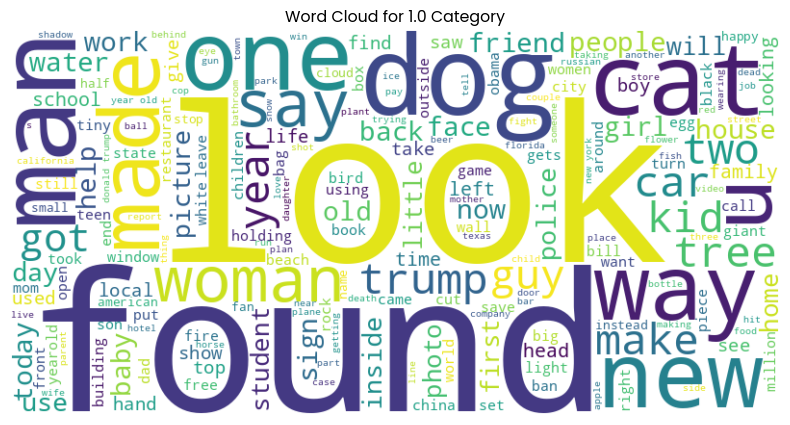

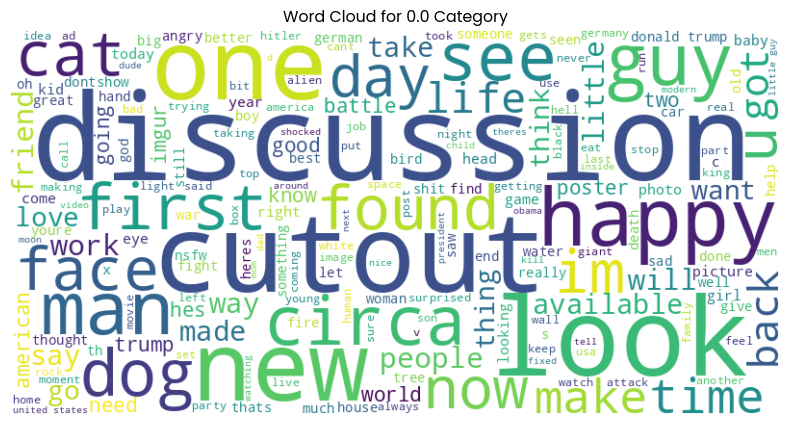

In [49]:
from wordcloud import WordCloud

def generate_word_clouds_for_categories(df, text_column, label_column):
    """
    Generates and displays word clouds for each category in the label column.

    Parameters:
    - df - dataframe.
    - text_column: str, the name of the column containing the text data.
    - label_column: str, the name of the column containing the categorical labels.

    Returns:
    - None, displays the word clouds for each category.
    """


    # Get unique labels from the label column
    labels = df[label_column].unique()

    for label in labels:
        # Filter the dataset for the current label
        filtered_df = df[df[label_column] == label]

        # Combine text items into one large string for the current label
        combined_text = " ".join(item for item in filtered_df[text_column])

        # Generate a word cloud image for the current label
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for {label} Category')
        plt.axis('off')
        plt.show()

generate_word_clouds_for_categories(train_remove_missing_images_df, 'clean_title', '2_way_label')


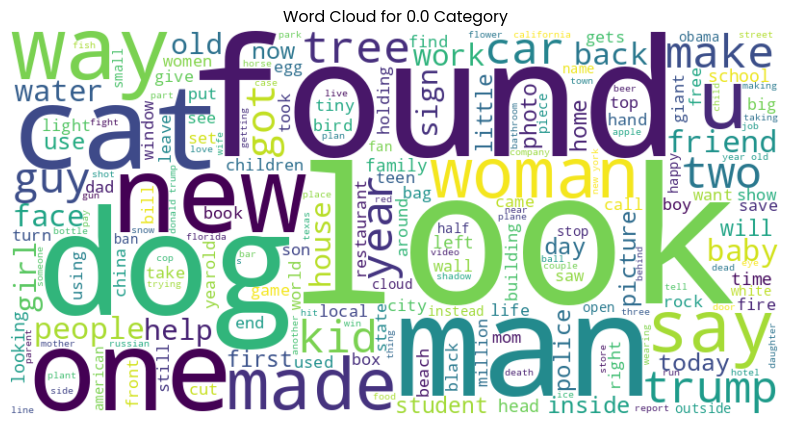

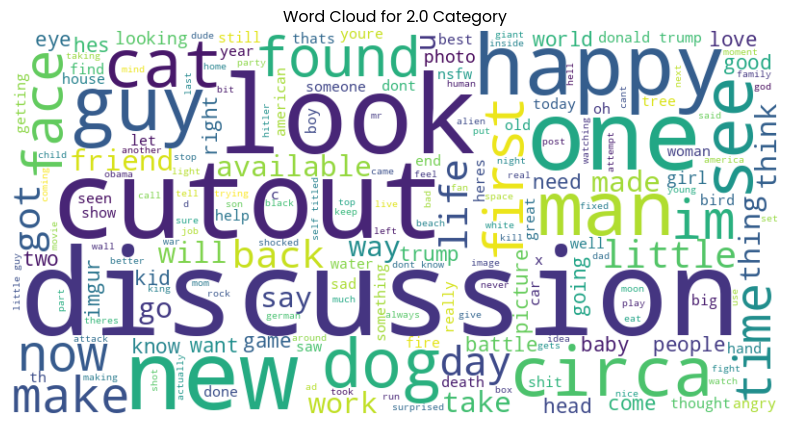

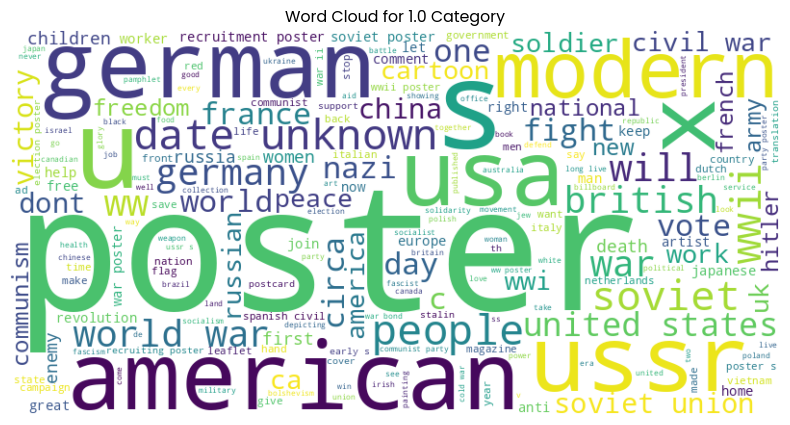

In [50]:
generate_word_clouds_for_categories(train_remove_missing_images_df, 'clean_title', '3_way_label')

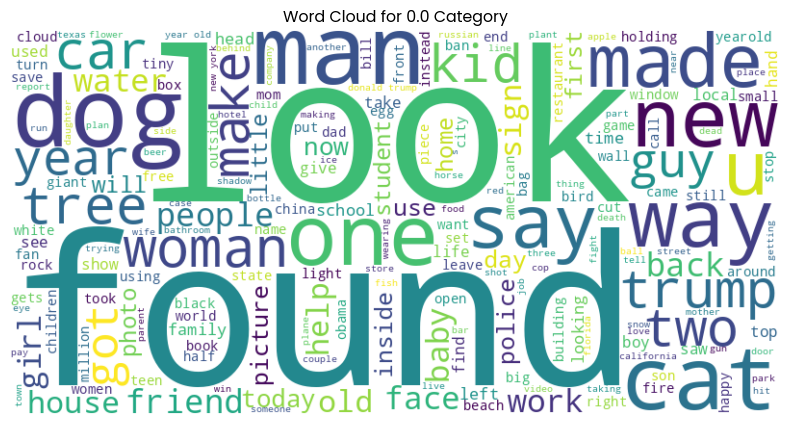

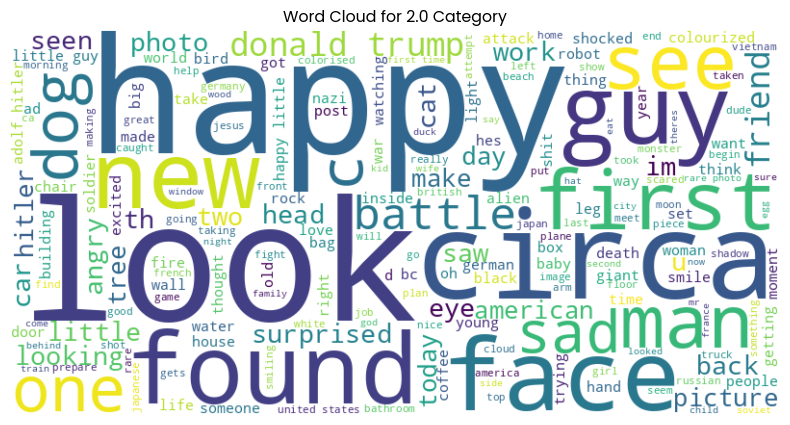

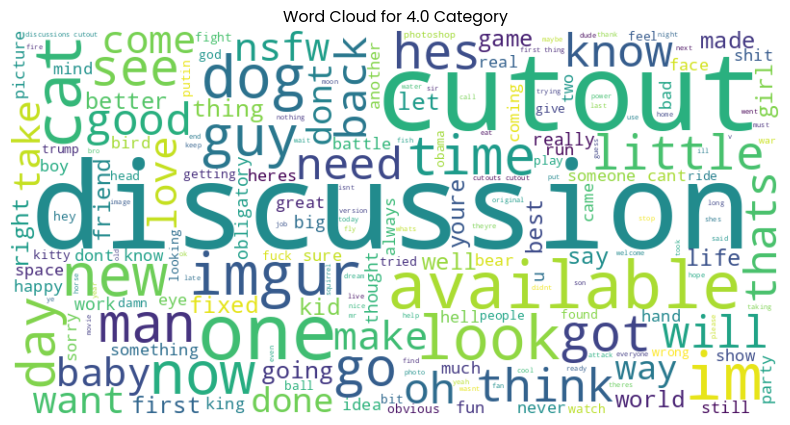

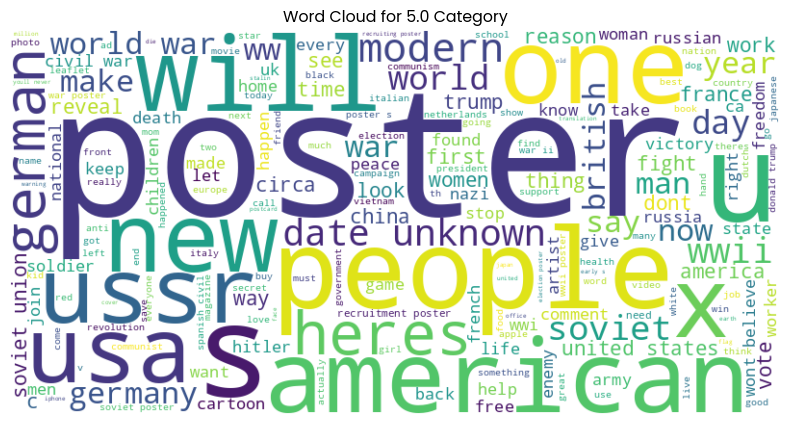

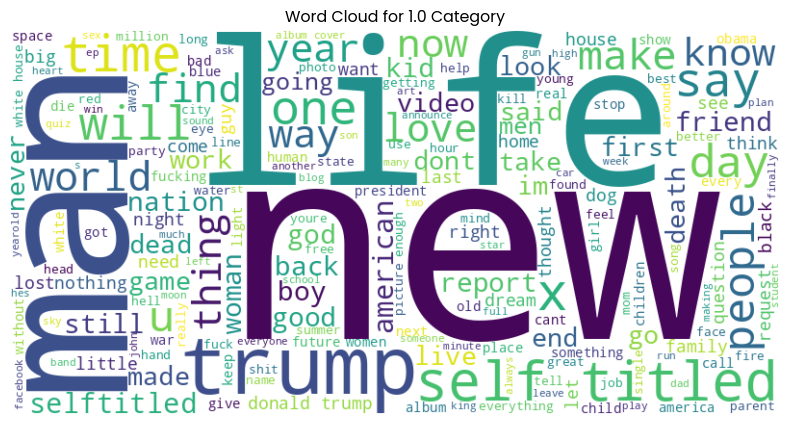

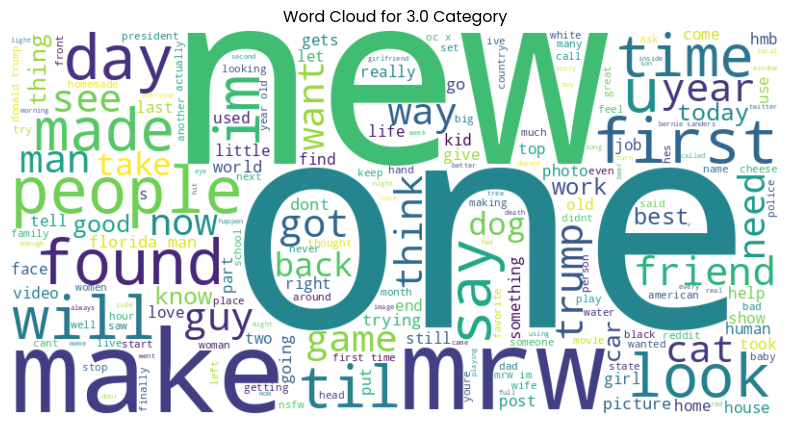

In [51]:
generate_word_clouds_for_categories(train_remove_missing_images_df, 'clean_title', '6_way_label')

In [69]:
train_remove_missing_images_df

title  \
0       My Walgreens offbrand Mucinex was engraved wit...   
1           Hackers leak emails from UAE ambassador to US   
2                      PsBattle: Puppy taking in the view   
3       Bride and groom exchange vows after fatal shoo...   
4                                           major thermos   
...                                                   ...   
540319                    The sky was dabbing on me today   
540320  Found this guy after moving my shower caddy of...   
540321  PsBattle: A Squirrel's Imprint In Wet Concrete...   
540322        He keeps an eye on the burner whilst I cook   
540323                                               Mr.G   

                                              clean_title  \
0       my walgreens offbrand mucinex was engraved wit...   
1           hackers leak emails from uae ambassador to us   
2                                puppy taking in the view   
3       bride and groom exchange vows after fatal shoo...   
4                                           major thermos   
...                                                   ...   
540319                    the sky was dabbing on me today   
540320  found this guy after moving my shower caddy of...   
540321                a squirrels imprint in wet concrete   
540322        he keeps an eye on the burner whilst i cook   
540323                                                mrg   

                                                image_url  2_way_label  \
0       https://external-preview.redd.it/WylDbZrnbvZdB...          1.0   
1       https://external-preview.redd.it/6fNhdbc6K1vFA...          1.0   
2       https://external-preview.redd.it/HLtVNhTR6wtYt...          1.0   
3       https://external-preview.redd.it/FQ-J9OIPFRpqi...          1.0   
4       https://preview.redd.it/l9gvkkf3jizy.jpg?width...          0.0   
...                                                   ...          ...   
540319  https://preview.redd.it/aloml4bv8rb31.jpg?widt...          1.0   
540320  https://external-preview.redd.it/3pcutlT6hYUy7...          0.0   
540321  https://preview.redd.it/mhph05cnveix.jpg?width...          1.0   
540322  https://external-preview.redd.it/afTHQfSIpVY52...          0.0   
540323                    https://i.imgur.com/IiARoWE.jpg          0.0   

        3_way_label  6_way_label  
0               0.0          0.0  
1               0.0          0.0  
2               0.0          0.0  
3               0.0          0.0  
4               2.0          2.0  
...             ...          ...  
540319          0.0          0.0  
540320          2.0          2.0  
540321          0.0          0.0  
540322          2.0          2.0  
540323          2.0          4.0  

[540324 rows x 6 columns]

In [ ]:
# functions to numerical sort images and put into various images folder. This ws done offline to save cost on colab
def numerical_sort(file_name):
    parts = file_name.split('_')
    if parts[-1].split('.')[0].isdigit():  # Splitting again to separate the extension and check if it's a digit
        return int(parts[-1].split('.')[0])
    else:
        return float('inf')  # Return a large number for files that don't end in a digit

In [ ]:
def extract_number(file_name):
    """ Extracts the number from a file name. """
    match = re.search(r'\d+', file_name)
    return int(match.group()) if match else None

In [ ]:
def check_folder_exists(folder_path):
    """ Check if a folder exists in Google Drive """
    return os.path.isdir(folder_path)

In [ ]:
# Loop to handle the copy operation for each set of files
for i in range(10):
    iso_filename = f'images_folder_{i}.iso'
    folder_name = f'images_folder_{i}'

    number = extract_number(iso_filename)
    folder_path_images = os.path.join(resized_image_output_base_directory, f'resized_image_output_directory_{number}')

    # Copy operation
    source_path = BASE_GOOGLE_DRIVE_DIRECTORY / images_folder_name / iso_filename
    destination_path = BASE_COLAB_DIRECTORY / images_folder_name / iso_filename
    shutil.copy(source_path, destination_path)

In [ ]:
# Define the extraction process for a specific file
def extract_iso(index):
    folder_name = f'images_folder_{index}'
    iso_filename = f'images_folder_{index}.iso'
    number = extract_number(folder_name)
    folder_path_images = os.path.join(resized_image_output_base_directory, f'resized_image_output_directory_{number}')

    # Ensure the extraction directory exists
    if not os.path.exists(folder_path_images):
        os.makedirs(folder_path_images)

    # Path to the ISO file
    iso_file_path = BASE_COLAB_DIRECTORY / images_folder_name / iso_filename

    # Extract the ISO file
    print(f"Extracting {iso_filename}...")
    !7z x "$iso_file_path" -o"$folder_path_images"

    # Optional: Pause to mitigate resource usage
    time.sleep(30)  # Pause for 30 seconds

In [ ]:
# Extract specific ISO files without using a loop
extract_iso(0)

In [ ]:
extract_iso(1)

In [ ]:
extract_iso(2)

In [ ]:
extract_iso(3)

In [ ]:
extract_iso(4)

In [ ]:
extract_iso(5)

In [ ]:
extract_iso(6)

In [ ]:
extract_iso(7)

In [ ]:
extract_iso(8)

In [ ]:
extract_iso(9)

In [ ]:
def find_missing_images(folder, starting_index=None, file_extension='.jpg'):
    # Get all files in the folder
    file_names = [f for f in os.listdir(folder) if f.endswith(file_extension)]

    # Extract numbers from the file names
    numbers = {extract_number(f) for f in file_names}

    # Check if there are any numbers extracted
    if not numbers:
        print("No files found or extract_number function failed to find numbers.")
        return []

    # Use the lowest image index in the folder if starting_index is not provided
    if starting_index is None:
        starting_index = min(numbers)

    # Find missing numbers in the sequence starting from the specified index
    missing = [x for x in range(starting_index, max(numbers) + 1) if x not in numbers]
    return missing

In [ ]:
# Loop through each folder
for i in range(10):
    folder_name = f'images_folder_{i}'
    number = extract_number(folder_name)
    folder_path_images = os.path.join(resized_image_output_base_directory, f'resized_image_output_directory_{number}', f'images_folder_{number}')
    # print(folder_path_images )
    # Assuming images are directly within the folder_path_images
    missing_images = find_missing_images(folder_path_images)
    print(f"Missing image indices in folder {folder_name}:", missing_images)

<font face="Poppins" size=2>After preprocessing the data, the next step is to extract features from the text, images, and metadata that will be used to train the machine learning model. Here's an outline of how you might approach this for each type of data:<font>

<font face="Poppins" size=2>
Textual Feature Extraction
For text data, you can use techniques like TF-IDF or embeddings. If using more advanced models like BERT, you would use a pre-trained model to convert text into embedding<font>


<font face="Poppins" size=2>The error you're encountering, ValueError: np.nan is an invalid document, expected byte or unicode string, occurs because the TfidfVectorizer is encountering NaN values in your text data. The TF-IDF vectorizer cannot process missing values (NaNs), so these need to be handled before applying the vectorizer.<font>

<font face="Poppins" size=2>One common approach is to replace NaN values with a placeholder string, such as an empty string. Here's how you can modify your code to handle this:<font>

In [70]:
train_remove_missing_images_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_available_images_removed_indices_train.csv')

In [71]:
selected_columns_train_unique_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_selected_columns_unique_rows_train.csv')

In [72]:
import pandas as pd

def find_missing_indices(df1, df2):
    """
    Find indices of rows in df1 that are not present in df2.

    Parameters:
    - df1: DataFrame to search in.
    - df2: DataFrame to search against.

    Returns:
    - List of indices from df1 not found in df2.
    """
    # Create a unique identifier for each row by concatenating all the column values into a single string
    df1['unique_id'] = df1.apply(lambda x: '_'.join(x.astype(str)), axis=1)
    df2['unique_id'] = df2.apply(lambda x: '_'.join(x.astype(str)), axis=1)

    # Convert the 'unique_id' columns to sets for efficient comparison
    unique_ids_df1 = set(df1['unique_id'])
    unique_ids_df2 = set(df2['unique_id'])

    # Find the difference between the two sets; these are rows in df1 not present in df2
    missing_unique_ids = unique_ids_df1.difference(unique_ids_df2)

    # Map the missing unique_ids back to the original indices in df1
    missing_indices = df1[df1['unique_id'].isin(missing_unique_ids)].index.tolist()

    return missing_indices

In [73]:
def plot_missing_rows_pie_chart(df1, missing_indices, title='Proportion of Missing Rows'):
    """
    Plot a pie chart showing the proportion of missing rows in df1.

    Parameters:
    - df1: DataFrame that was searched.
    - missing_indices: List of indices from df1 not found in comparison DataFrame.
    - title: Title for the pie chart.
    """
    # Total number of rows in df1
    total_rows_df1 = len(df1)

    # Number of missing rows in df1
    missing_rows_count = len(missing_indices)

    # Number of rows present in df1
    present_rows_count = total_rows_df1 - missing_rows_count

    # Data to plot
    labels = 'Missing Rows', 'Present Rows'
    sizes = [missing_rows_count, present_rows_count]
    colors = ['#ff9999','#66b3ff']

    # Plotting the pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(title)
    plt.show()

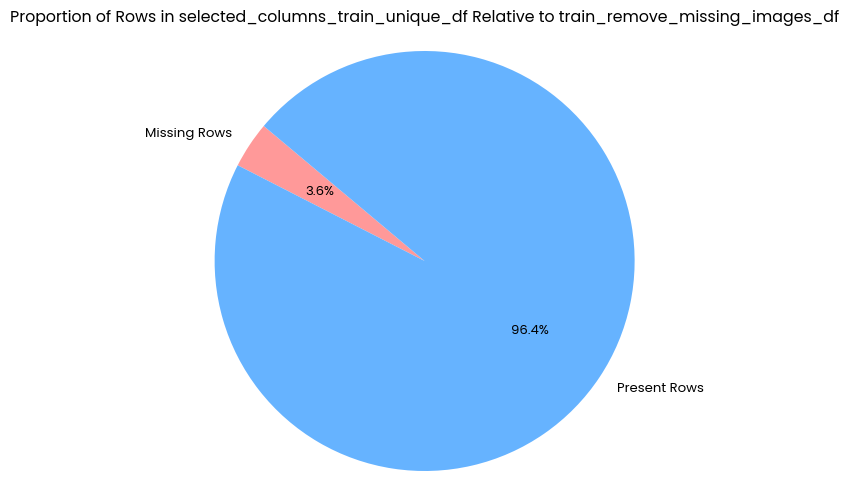

In [74]:
# Assuming selected_columns_train_unique_df and train_remove_missing_images_df are your DataFrames
missing_indices = find_missing_indices(selected_columns_train_unique_df, train_remove_missing_images_df)
plot_missing_rows_pie_chart(selected_columns_train_unique_df, missing_indices, 'Proportion of Rows in selected_columns_train_unique_df Relative to train_remove_missing_images_df')

In [75]:
train_remove_missing_images_df

title  \
0       My Walgreens offbrand Mucinex was engraved wit...   
1           Hackers leak emails from UAE ambassador to US   
2                      PsBattle: Puppy taking in the view   
3       Bride and groom exchange vows after fatal shoo...   
4                                           major thermos   
...                                                   ...   
540319                    The sky was dabbing on me today   
540320  Found this guy after moving my shower caddy of...   
540321  PsBattle: A Squirrel's Imprint In Wet Concrete...   
540322        He keeps an eye on the burner whilst I cook   
540323                                               Mr.G   

                                              clean_title  \
0       my walgreens offbrand mucinex was engraved wit...   
1           hackers leak emails from uae ambassador to us   
2                                puppy taking in the view   
3       bride and groom exchange vows after fatal shoo...   
4                                           major thermos   
...                                                   ...   
540319                    the sky was dabbing on me today   
540320  found this guy after moving my shower caddy of...   
540321                a squirrels imprint in wet concrete   
540322        he keeps an eye on the burner whilst i cook   
540323                                                mrg   

                                                image_url  2_way_label  \
0       https://external-preview.redd.it/WylDbZrnbvZdB...          1.0   
1       https://external-preview.redd.it/6fNhdbc6K1vFA...          1.0   
2       https://external-preview.redd.it/HLtVNhTR6wtYt...          1.0   
3       https://external-preview.redd.it/FQ-J9OIPFRpqi...          1.0   
4       https://preview.redd.it/l9gvkkf3jizy.jpg?width...          0.0   
...                                                   ...          ...   
540319  https://preview.redd.it/aloml4bv8rb31.jpg?widt...          1.0   
540320  https://external-preview.redd.it/3pcutlT6hYUy7...          0.0   
540321  https://preview.redd.it/mhph05cnveix.jpg?width...          1.0   
540322  https://external-preview.redd.it/afTHQfSIpVY52...          0.0   
540323                    https://i.imgur.com/IiARoWE.jpg          0.0   

        3_way_label  6_way_label  \
0               0.0          0.0   
1               0.0          0.0   
2               0.0          0.0   
3               0.0          0.0   
4               2.0          2.0   
...             ...          ...   
540319          0.0          0.0   
540320          2.0          2.0   
540321          0.0          0.0   
540322          2.0          2.0   
540323          2.0          4.0   

                                                unique_id  
0       My Walgreens offbrand Mucinex was engraved wit...  
1       Hackers leak emails from UAE ambassador to US_...  
2       PsBattle: Puppy taking in the view_puppy takin...  
3       Bride and groom exchange vows after fatal shoo...  
4       major thermos_major thermos_https://preview.re...  
...                                                   ...  
540319  The sky was dabbing on me today_the sky was da...  
540320  Found this guy after moving my shower caddy of...  
540321  PsBattle: A Squirrel's Imprint In Wet Concrete...  
540322  He keeps an eye on the burner whilst I cook_he...  
540323  Mr.G_mrg_https://i.imgur.com/IiARoWE.jpg_0.0_2...  

[540324 rows x 7 columns]

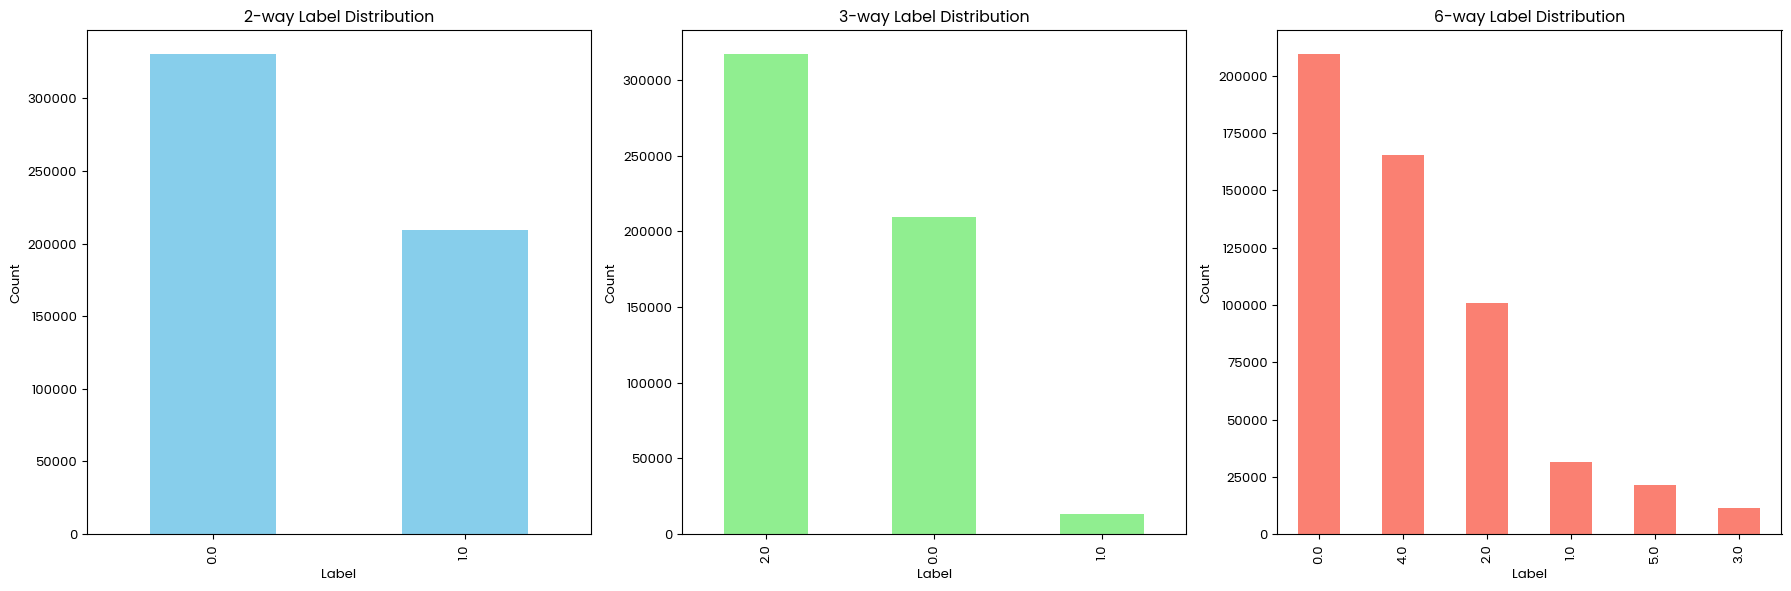

In [78]:
 #Plotting the label distribution for 2-way, 3-way, and 6-way labels
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 2-way label distribution
 train_remove_missing_images_df['2_way_label'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('2-way Label Distribution')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')

# 3-way label distribution
 train_remove_missing_images_df['3_way_label'].value_counts().plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('3-way Label Distribution')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

# 6-way label distribution
 train_remove_missing_images_df['6_way_label'].value_counts().plot(kind='bar', ax=axes[2], color='salmon')
axes[2].set_title('6-way Label Distribution')
axes[2].set_xlabel('Label')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [76]:
fake_news_dataset_text = train_remove_missing_images_df.copy()

In [79]:
fake_news_dataset_text

title  \
0       My Walgreens offbrand Mucinex was engraved wit...   
1           Hackers leak emails from UAE ambassador to US   
2                      PsBattle: Puppy taking in the view   
3       Bride and groom exchange vows after fatal shoo...   
4                                           major thermos   
...                                                   ...   
540319                    The sky was dabbing on me today   
540320  Found this guy after moving my shower caddy of...   
540321  PsBattle: A Squirrel's Imprint In Wet Concrete...   
540322        He keeps an eye on the burner whilst I cook   
540323                                               Mr.G   

                                              clean_title  \
0       my walgreens offbrand mucinex was engraved wit...   
1           hackers leak emails from uae ambassador to us   
2                                puppy taking in the view   
3       bride and groom exchange vows after fatal shoo...   
4                                           major thermos   
...                                                   ...   
540319                    the sky was dabbing on me today   
540320  found this guy after moving my shower caddy of...   
540321                a squirrels imprint in wet concrete   
540322        he keeps an eye on the burner whilst i cook   
540323                                                mrg   

                                                image_url  2_way_label  \
0       https://external-preview.redd.it/WylDbZrnbvZdB...          1.0   
1       https://external-preview.redd.it/6fNhdbc6K1vFA...          1.0   
2       https://external-preview.redd.it/HLtVNhTR6wtYt...          1.0   
3       https://external-preview.redd.it/FQ-J9OIPFRpqi...          1.0   
4       https://preview.redd.it/l9gvkkf3jizy.jpg?width...          0.0   
...                                                   ...          ...   
540319  https://preview.redd.it/aloml4bv8rb31.jpg?widt...          1.0   
540320  https://external-preview.redd.it/3pcutlT6hYUy7...          0.0   
540321  https://preview.redd.it/mhph05cnveix.jpg?width...          1.0   
540322  https://external-preview.redd.it/afTHQfSIpVY52...          0.0   
540323                    https://i.imgur.com/IiARoWE.jpg          0.0   

        3_way_label  6_way_label  \
0               0.0          0.0   
1               0.0          0.0   
2               0.0          0.0   
3               0.0          0.0   
4               2.0          2.0   
...             ...          ...   
540319          0.0          0.0   
540320          2.0          2.0   
540321          0.0          0.0   
540322          2.0          2.0   
540323          2.0          4.0   

                                                unique_id  
0       My Walgreens offbrand Mucinex was engraved wit...  
1       Hackers leak emails from UAE ambassador to US_...  
2       PsBattle: Puppy taking in the view_puppy takin...  
3       Bride and groom exchange vows after fatal shoo...  
4       major thermos_major thermos_https://preview.re...  
...                                                   ...  
540319  The sky was dabbing on me today_the sky was da...  
540320  Found this guy after moving my shower caddy of...  
540321  PsBattle: A Squirrel's Imprint In Wet Concrete...  
540322  He keeps an eye on the burner whilst I cook_he...  
540323  Mr.G_mrg_https://i.imgur.com/IiARoWE.jpg_0.0_2...  

[540324 rows x 7 columns]

In [80]:
fake_news_dataset_text

title  \
0       My Walgreens offbrand Mucinex was engraved wit...   
1           Hackers leak emails from UAE ambassador to US   
2                      PsBattle: Puppy taking in the view   
3       Bride and groom exchange vows after fatal shoo...   
4                                           major thermos   
...                                                   ...   
540319                    The sky was dabbing on me today   
540320  Found this guy after moving my shower caddy of...   
540321  PsBattle: A Squirrel's Imprint In Wet Concrete...   
540322        He keeps an eye on the burner whilst I cook   
540323                                               Mr.G   

                                              clean_title  \
0       my walgreens offbrand mucinex was engraved wit...   
1           hackers leak emails from uae ambassador to us   
2                                puppy taking in the view   
3       bride and groom exchange vows after fatal shoo...   
4                                           major thermos   
...                                                   ...   
540319                    the sky was dabbing on me today   
540320  found this guy after moving my shower caddy of...   
540321                a squirrels imprint in wet concrete   
540322        he keeps an eye on the burner whilst i cook   
540323                                                mrg   

                                                image_url  2_way_label  \
0       https://external-preview.redd.it/WylDbZrnbvZdB...          1.0   
1       https://external-preview.redd.it/6fNhdbc6K1vFA...          1.0   
2       https://external-preview.redd.it/HLtVNhTR6wtYt...          1.0   
3       https://external-preview.redd.it/FQ-J9OIPFRpqi...          1.0   
4       https://preview.redd.it/l9gvkkf3jizy.jpg?width...          0.0   
...                                                   ...          ...   
540319  https://preview.redd.it/aloml4bv8rb31.jpg?widt...          1.0   
540320  https://external-preview.redd.it/3pcutlT6hYUy7...          0.0   
540321  https://preview.redd.it/mhph05cnveix.jpg?width...          1.0   
540322  https://external-preview.redd.it/afTHQfSIpVY52...          0.0   
540323                    https://i.imgur.com/IiARoWE.jpg          0.0   

        3_way_label  6_way_label  \
0               0.0          0.0   
1               0.0          0.0   
2               0.0          0.0   
3               0.0          0.0   
4               2.0          2.0   
...             ...          ...   
540319          0.0          0.0   
540320          2.0          2.0   
540321          0.0          0.0   
540322          2.0          2.0   
540323          2.0          4.0   

                                                unique_id  
0       My Walgreens offbrand Mucinex was engraved wit...  
1       Hackers leak emails from UAE ambassador to US_...  
2       PsBattle: Puppy taking in the view_puppy takin...  
3       Bride and groom exchange vows after fatal shoo...  
4       major thermos_major thermos_https://preview.re...  
...                                                   ...  
540319  The sky was dabbing on me today_the sky was da...  
540320  Found this guy after moving my shower caddy of...  
540321  PsBattle: A Squirrel's Imprint In Wet Concrete...  
540322  He keeps an eye on the burner whilst I cook_he...  
540323  Mr.G_mrg_https://i.imgur.com/IiARoWE.jpg_0.0_2...  

[540324 rows x 7 columns]

In [81]:
fake_news_dataset_text.count()

title          540324
clean_title    540324
image_url      540324
2_way_label    540324
3_way_label    540324
6_way_label    540324
unique_id      540324
dtype: int64

In [ ]:
# Assume batch_size is defined
batch_size = 100

# Function for batch tokenization
def batch_tokenize(tokenizer, texts, batch_size=100):
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        yield tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)

# Initialize tokenizers and models, and send them to the device
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
t5_model = T5EncoderModel.from_pretrained('t5-small').to(device)

roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base').to(device)

In [ ]:
# Extract features for each model
def extract_features(model, tokenizer, texts, batch_size=100):
    model.eval()  # Set model to evaluation mode
    features = []
    total_batches = (len(texts) + batch_size - 1) // batch_size  # Calculate the total number of batches
    for batch in tqdm(batch_tokenize(tokenizer, texts, batch_size), total=total_batches, desc=f"Extracting features with {tokenizer.__class__.__name__}"):
        with torch.no_grad():
            outputs = model(**batch)
        features.extend(outputs.last_hidden_state.mean(dim=1).cpu().numpy())
    return features

In [ ]:
bert_features = extract_features(bert_model, bert_tokenizer, fake_news_dataset_text['clean_title'].tolist())
t5_features = extract_features(t5_model, t5_tokenizer, fake_news_dataset_text['clean_title'].tolist())
roberta_features = extract_features(roberta_model, roberta_tokenizer, fake_news_dataset_text['clean_title'].tolist())

# Convert to DataFrames
bert_features_df = pd.DataFrame(bert_features)
t5_features_df = pd.DataFrame(t5_features)
roberta_features_df = pd.DataFrame(roberta_features)

In [ ]:
bert_features_df

In [ ]:
# Save the DataFrame to a CSV file
bert_features_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_bert_features_train.csv', index=False)
t5_features_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_t5_features_train.csv', index=False)
roberta_features_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_roberta_features_train.csv', index=False)

In [84]:
bert_features_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_bert_features_train.csv')

In [85]:
bert_features_df.count()

0      540324
1      540324
2      540324
3      540324
4      540324
        ...  
763    540324
764    540324
765    540324
766    540324
767    540324
Length: 768, dtype: int64

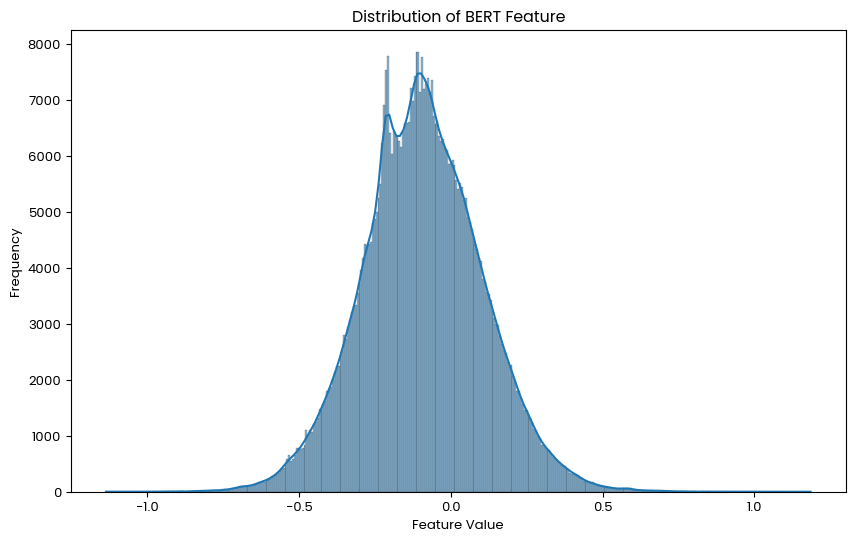

In [86]:
# Histogram of the BERT feature column (modify as needed)
plt.figure(figsize=(10, 6))
sns.histplot(bert_features_df.iloc[:, 1], kde=True)  # Replace 1 with the column index of interest
plt.title('Distribution of BERT Feature')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.show()

<font face="Poppins" size=2>The histogram you've uploaded appears to show the distribution of a single feature extracted from BERT.</font><br>
<font face="Poppins" size=2>The distribution has a shape that is roughly bell-curved but with noticeable spikes, which could be indicative of certain patterns or anomalies within the data.</font><br>

<font face="Poppins" size=2>From the histogram, we can make some initial observations:</font><br>

<font face="Poppins" size=2>1. **Central Tendency:** The peak of the histogram suggests that most of the feature values are centered around a specific range, which is typical of a feature that has been normalized or standardized.</font><br>

<font face="Poppins" size=2>2. **Spikes (Outliers or Discrete Features):** The spikes might indicate outliers or that the feature has a mix of continuous and discrete characteristics.</font><br><font face="Poppins" size=2>For instance, if the feature represents some kind of count or discrete measure that often takes specific integer values.</font><br>

<font face="Poppins" size=2>3. **Spread of the Data:** The data seems to be spread out on either side of the peak, indicating some level of variance in the feature values.</font>

In [87]:
t5_features_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_t5_features_train.csv')

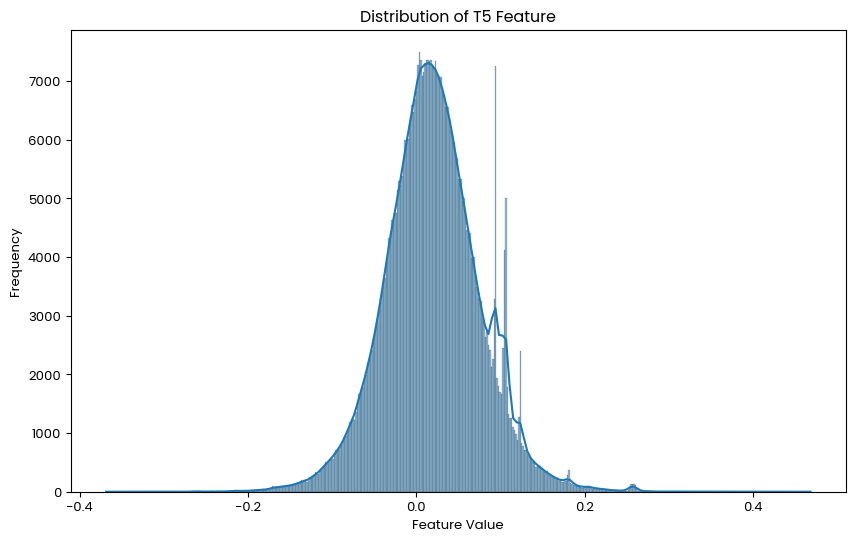

In [88]:
# Histogram of the 75 feature column (modify as needed)
plt.figure(figsize=(10, 6))
sns.histplot(t5_features_df.iloc[:, 1], kde=True)  # Replace 1 with the column index of interest
plt.title('Distribution of T5 Feature')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.show()

In [89]:
roberta_features_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_roberta_features_train.csv')

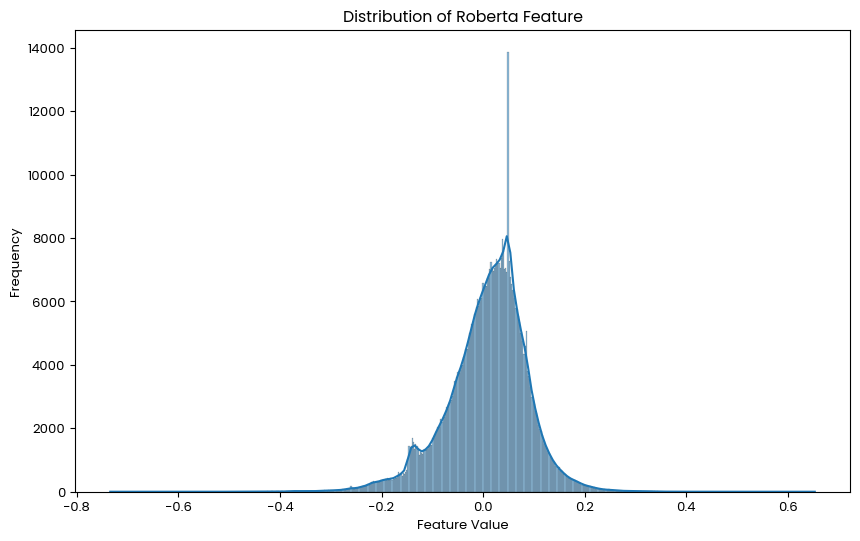

In [90]:
# Histogram of the Roberta feature column
plt.figure(figsize=(10, 6))
sns.histplot(roberta_features_df.iloc[:, 1], kde=True)  # Replace 1 with the column index of interest
plt.title('Distribution of Roberta Feature')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
def get_feature_vector_info_from_df(df):
    """
    Determines the size range of feature vectors in a DataFrame.

    Parameters:
    - df: DataFrame, the DataFrame containing the data.

    Returns:
    - A dictionary with information about the number of rows, total columns,
      and the range of feature vector columns.
    """
    # Get the total number of rows and columns
    rows, columns = df.shape

    # Assuming feature columns are named numerically or follow a specific pattern
    # Convert column names to string before checking if they are digits
    feature_columns = [col for col in df.columns if str(col).isdigit()]

    # If no feature columns found based on the condition, adjust the message
    if not feature_columns:
        feature_vector_range = "No feature columns found based on the naming condition."
        feature_vector_size = 0
    else:
        # Convert column names back to integers if necessary, for sorting purposes
        feature_columns = [int(col) for col in feature_columns]
        feature_columns.sort()  # Ensure the columns are sorted numerically
        feature_vector_range = f"{feature_columns[0]} to {feature_columns[-1]}"
        feature_vector_size = len(feature_columns)

    # Prepare the information to be returned
    info = {
        'total_rows': rows,
        'total_columns': columns,
        'feature_vector_range': feature_vector_range,
        'feature_vector_size': feature_vector_size
    }

    return info

In [ ]:
train_bert_features_info = get_feature_vector_info_from_df(bert_features_df)
print(train_bert_features_info)

In [ ]:
train_t5_features_info = get_feature_vector_info_from_df(t5_features_df)
print(train_t5_features_info)

In [ ]:
train_roberta_features_info = get_feature_vector_info_from_df(roberta_features_df)
print(train_roberta_features_info)

# <font face="Poppins" size=2>Merge the text features with the original csv with image_url', '2_way_label', '3_way_label', '6_way_label' headers.</font>

In [83]:
def merge_features_with_labels(features_df, original_df, fields_to_merge):
    """
    Merges specified fields from the original dataset with the feature extraction results.

    Parameters:
    - features_df: DataFrame containing the feature extraction results.
    - original_df: DataFrame containing the original dataset.
    - fields_to_merge: list of str, the names of the fields in the original dataset to be merged with the features.

    Returns:
    - merged_df: DataFrame containing the merged data.
    """
    # Select the required fields from the original dataset
    selected_fields_df = original_df[fields_to_merge]

    # Merge the selected fields with the feature extraction results
    # This example assumes the row order in both DataFrames is aligned
    merged_df = selected_fields_df.merge(features_df, left_index=True, right_index=True)

    return merged_df

# Usage example
fields_to_merge = ['image_url', '2_way_label', '3_way_label', '6_way_label']

In [ ]:
train_bert_merged_df = merge_features_with_labels(bert_features_df, fake_news_dataset_text, fields_to_merge)

In [ ]:
train_bert_merged_df

image_url  2_way_label  \
0       https://external-preview.redd.it/WylDbZrnbvZdB...          1.0   
1       https://external-preview.redd.it/6fNhdbc6K1vFA...          1.0   
2       https://external-preview.redd.it/HLtVNhTR6wtYt...          1.0   
3       https://external-preview.redd.it/FQ-J9OIPFRpqi...          1.0   
4       https://preview.redd.it/l9gvkkf3jizy.jpg?width...          0.0   
...                                                   ...          ...   
540319  https://preview.redd.it/aloml4bv8rb31.jpg?widt...          1.0   
540320  https://external-preview.redd.it/3pcutlT6hYUy7...          0.0   
540321  https://preview.redd.it/mhph05cnveix.jpg?width...          1.0   
540322  https://external-preview.redd.it/afTHQfSIpVY52...          0.0   
540323                    https://i.imgur.com/IiARoWE.jpg          0.0   

        3_way_label  6_way_label         0         1         2         3  \
0               0.0          0.0  0.131155 -0.168061  0.281437  0.219225   
1               0.0          0.0  0.117471 -0.140146  0.128266  0.143437   
2               0.0          0.0  0.032026 -0.341841 -0.065995  0.082261   
3               0.0          0.0 -0.134032 -0.334811  0.288125  0.118603   
4               2.0          2.0 -0.580428 -0.307492 -0.038657  0.172611   
...             ...          ...       ...       ...       ...       ...   
540319          0.0          0.0  0.096069 -0.073781  0.159023 -0.080770   
540320          2.0          2.0  0.118608 -0.079853  0.165731  0.309053   
540321          0.0          0.0  0.046276  0.076998 -0.264243  0.086444   
540322          2.0          2.0  0.329328  0.297118 -0.134652 -0.016351   
540323          2.0          4.0 -0.220875 -0.150083  0.438721 -0.000330   

               4         5  ...       758       759       760       761  \
0       0.038679  0.237262  ... -0.054950  0.201888 -0.125417  0.080151   
1       0.059774 -0.297025  ...  0.236085 -0.191101 -0.117163 -0.240233   
2      -0.071549 -0.150069  ...  0.001205  0.132621 -0.157173 -0.038103   
3      -0.009912 -0.074692  ...  0.355227 -0.132155  0.493886 -0.192040   
4      -0.072329 -0.086933  ...  0.475505  0.047816 -0.007563  0.125963   
...          ...       ...  ...       ...       ...       ...       ...   
540319 -0.120617 -0.117130  ...  0.057557 -0.260944  0.058038 -0.047588   
540320  0.098578  0.029720  ...  0.429684 -0.314218  0.137098 -0.309054   
540321  0.135861  0.188230  ...  0.273056  0.054272 -0.044815  0.338537   
540322  0.131047  0.136578  ...  0.104800  0.049207  0.077126 -0.221602   
540323 -0.157312  0.098584  ...  0.436550  0.089375  0.105013 -0.001416   

             762       763       764       765       766       767  
0       0.287730  0.095871 -0.260876 -0.161991  0.081655  0.255493  
1       0.247196 -0.420024  0.122985 -0.163915  0.041992 -0.048092  
2      -0.048947 -0.409333 -0.020869 -0.040603  0.088204 -0.005991  
3      -0.062315 -0.154395  0.042806 -0.306126 -0.040576 -0.214779  
4       0.254001 -0.297447 -0.213531  0.145551  0.088959  0.233810  
...          ...       ...       ...       ...       ...       ...  
540319  0.215797 -0.064806  0.116133  0.269700  0.198257  0.115745  
540320 -0.095700 -0.105172 -0.182911 -0.181259  0.069354 -0.115759  
540321  0.376632 -0.314117  0.052529  0.001130  0.009346  0.036327  
540322  0.160835 -0.148598  0.239731  0.189263  0.023566 -0.017808  
540323 -0.053873 -0.409595 -0.146579  0.194722  0.237375  0.079623  

[540324 rows x 772 columns]

In [ ]:
train_bert_merged_df.count()

image_url      540324
2_way_label    540324
3_way_label    540324
6_way_label    540324
0              540324
                ...  
763            540324
764            540324
765            540324
766            540324
767            540324
Length: 772, dtype: int64

In [ ]:
train_bert_merged_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_bert_merged_train.csv', index=False)

In [82]:
train_bert_merged_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_bert_merged_train.csv')

In [ ]:
def extract_features_from_merged_df(merged_df):
    """
    Extracts feature vectors from the merged DataFrame.

    Parameters:
    - merged_df: DataFrame, the merged DataFrame containing both the features and other fields.

    Returns:
    - features: NumPy array containing the extracted feature vectors.
    """
    # Convert column names to strings and check if they are numerical
    feature_columns = [col for col in merged_df.columns if str(col).isdigit()]

    # Extract feature vectors based on the identified columns
    features = merged_df[feature_columns].to_numpy()

    return features

In [ ]:
train_bert_features_extraction  = extract_features_from_merged_df(train_bert_merged_df)

In [ ]:
train_bert_features_extraction

array([[ 0.1311551 , -0.16806117,  0.28143734, ..., -0.16199118,
         0.08165472,  0.2554925 ],
       [ 0.11747109, -0.14014557,  0.12826607, ..., -0.16391489,
         0.04199211, -0.04809155],
       [ 0.03202643, -0.3418406 , -0.06599517, ..., -0.04060334,
         0.08820407, -0.00599143],
       ...,
       [ 0.04627581,  0.0769981 , -0.26424253, ...,  0.00112967,
         0.00934608,  0.03632724],
       [ 0.32932812,  0.29711816, -0.13465165, ...,  0.18926331,
         0.02356628, -0.0178077 ],
       [-0.22087489, -0.15008333,  0.43872106, ...,  0.19472177,
         0.23737542,  0.07962295]], dtype=float32)

In [ ]:
# Convert the NumPy array to a DataFrame for easy saving
train_bert_features_df = pd.DataFrame(train_bert_features_extraction)

# Save the DataFrame using HDF5 format
train_bert_features_df.to_hdf(BASE_GOOGLE_DRIVE_DIRECTORY /'train_bert_features_extraction.h5', key='features', mode='w')

In [ ]:
# When you need to use the features, you can load them back into your environment
train_bert_features_df = pd.read_hdf(BASE_GOOGLE_DRIVE_DIRECTORY /'train_bert_features_extraction.h5', 'features')
# Optionally convert the DataFrame back to a NumPy array
train_bert_features_extraction =  train_bert_features_df.to_numpy()

In [ ]:
train_bert_features_df

0         1         2         3         4         5         6    \
0       0.131155 -0.168061  0.281437  0.219225  0.038679  0.237262 -0.133795   
1       0.117471 -0.140146  0.128266  0.143437  0.059774 -0.297025 -0.122729   
2       0.032026 -0.341841 -0.065995  0.082261 -0.071549 -0.150069  0.130584   
3      -0.134032 -0.334811  0.288125  0.118603 -0.009912 -0.074692  0.676885   
4      -0.580428 -0.307492 -0.038657  0.172611 -0.072329 -0.086933  0.149223   
...          ...       ...       ...       ...       ...       ...       ...   
540319  0.096069 -0.073781  0.159023 -0.080770 -0.120617 -0.117130 -0.151944   
540320  0.118608 -0.079853  0.165731  0.309053  0.098578  0.029720  0.169620   
540321  0.046276  0.076998 -0.264243  0.086444  0.135861  0.188230  0.001360   
540322  0.329328  0.297118 -0.134652 -0.016351  0.131047  0.136578 -0.205699   
540323 -0.220875 -0.150083  0.438721 -0.000330 -0.157312  0.098584 -0.131603   

             7         8         9    ...       758       759       760  \
0       0.347732 -0.030291 -0.203899  ... -0.054950  0.201888 -0.125417   
1       0.281257  0.068517  0.026531  ...  0.236085 -0.191101 -0.117163   
2       0.074266  0.089588 -0.184111  ...  0.001205  0.132621 -0.157173   
3       0.108756  0.320404 -0.042081  ...  0.355227 -0.132155  0.493886   
4       0.039969  0.055546 -0.437540  ...  0.475505  0.047816 -0.007563   
...          ...       ...       ...  ...       ...       ...       ...   
540319  0.543519 -0.002672 -0.332575  ...  0.057557 -0.260944  0.058038   
540320  0.305276  0.192162 -0.343487  ...  0.429684 -0.314218  0.137098   
540321  0.243130 -0.199149 -0.289528  ...  0.273056  0.054272 -0.044815   
540322  0.285697  0.209242 -0.245149  ...  0.104800  0.049207  0.077126   
540323  0.048620 -0.045587 -0.113920  ...  0.436550  0.089375  0.105013   

             761       762       763       764       765       766       767  
0       0.080151  0.287730  0.095871 -0.260876 -0.161991  0.081655  0.255493  
1      -0.240233  0.247196 -0.420024  0.122985 -0.163915  0.041992 -0.048092  
2      -0.038103 -0.048947 -0.409333 -0.020869 -0.040603  0.088204 -0.005991  
3      -0.192040 -0.062315 -0.154395  0.042806 -0.306126 -0.040576 -0.214779  
4       0.125963  0.254001 -0.297447 -0.213531  0.145551  0.088959  0.233810  
...          ...       ...       ...       ...       ...       ...       ...  
540319 -0.047588  0.215797 -0.064806  0.116133  0.269700  0.198257  0.115745  
540320 -0.309054 -0.095700 -0.105172 -0.182911 -0.181259  0.069354 -0.115759  
540321  0.338537  0.376632 -0.314117  0.052529  0.001130  0.009346  0.036327  
540322 -0.221602  0.160835 -0.148598  0.239731  0.189263  0.023566 -0.017808  
540323 -0.001416 -0.053873 -0.409595 -0.146579  0.194722  0.237375  0.079623  

[540324 rows x 768 columns]

In [ ]:
train_t5_merged_df = merge_features_with_labels(t5_features_df, fake_news_dataset_text, fields_to_merge)

In [ ]:
train_t5_merged_df

image_url  2_way_label  \
0       https://external-preview.redd.it/WylDbZrnbvZdB...          1.0   
1       https://external-preview.redd.it/6fNhdbc6K1vFA...          1.0   
2       https://external-preview.redd.it/HLtVNhTR6wtYt...          1.0   
3       https://external-preview.redd.it/FQ-J9OIPFRpqi...          1.0   
4       https://preview.redd.it/l9gvkkf3jizy.jpg?width...          0.0   
...                                                   ...          ...   
540319  https://preview.redd.it/aloml4bv8rb31.jpg?widt...          1.0   
540320  https://external-preview.redd.it/3pcutlT6hYUy7...          0.0   
540321  https://preview.redd.it/mhph05cnveix.jpg?width...          1.0   
540322  https://external-preview.redd.it/afTHQfSIpVY52...          0.0   
540323                    https://i.imgur.com/IiARoWE.jpg          0.0   

        3_way_label  6_way_label         0         1         2         3  \
0               0.0          0.0  0.001180  0.026318  0.047196 -0.007518   
1               0.0          0.0  0.111222  0.096209  0.090337 -0.059350   
2               0.0          0.0  0.108028 -0.065833  0.117249 -0.072122   
3               0.0          0.0  0.108902  0.024839  0.074471 -0.010745   
4               2.0          2.0  0.074281  0.030456  0.193582 -0.054240   
...             ...          ...       ...       ...       ...       ...   
540319          0.0          0.0  0.093605 -0.028930  0.196446 -0.154865   
540320          2.0          2.0  0.083352  0.036453  0.153222 -0.148710   
540321          0.0          0.0  0.148785  0.021431  0.127512 -0.014151   
540322          2.0          2.0  0.058032  0.027895  0.107173 -0.072767   
540323          2.0          4.0 -0.053986  0.095727  0.072572 -0.235748   

               4         5  ...       502       503       504       505  \
0      -0.095128 -0.024596  ...  0.079457  0.016714  0.002317 -0.286671   
1      -0.186703 -0.162068  ...  0.032132 -0.055638 -0.022241 -0.163161   
2      -0.257414 -0.128633  ...  0.139780  0.014605 -0.011969 -0.163234   
3      -0.204702 -0.115473  ...  0.066900  0.026899 -0.117698 -0.167696   
4      -0.178698 -0.075958  ...  0.162628  0.112314 -0.010194 -0.116386   
...          ...       ...  ...       ...       ...       ...       ...   
540319 -0.233446 -0.181215  ...  0.121739 -0.150239 -0.073902 -0.168768   
540320 -0.270798 -0.095580  ...  0.118273  0.032099 -0.033348 -0.186820   
540321 -0.254038 -0.089384  ...  0.074660 -0.014052 -0.078676 -0.179130   
540322 -0.275348 -0.036024  ...  0.082983 -0.040087 -0.048189 -0.141938   
540323 -0.087319 -0.129177  ...  0.142140 -0.028277 -0.015711 -0.075477   

             506       507       508       509       510       511  
0      -0.090339 -0.066687 -0.034849 -0.025028  0.052324  0.115202  
1       0.014366 -0.101453  0.102047 -0.011765  0.028743 -0.156119  
2      -0.158685 -0.189325 -0.054392 -0.010989 -0.036593  0.038067  
3      -0.057672 -0.095320  0.020336 -0.035456  0.027273 -0.086070  
4      -0.140815 -0.111524 -0.060011 -0.039293  0.051782 -0.055037  
...          ...       ...       ...       ...       ...       ...  
540319 -0.198407 -0.178539  0.014281 -0.091308  0.084115 -0.031932  
540320 -0.126361 -0.133048 -0.001319 -0.020541  0.034121 -0.080726  
540321 -0.110821 -0.179340 -0.009228 -0.064933  0.099010 -0.000378  
540322 -0.128542 -0.163404 -0.053479  0.030459  0.069668 -0.038812  
540323 -0.067458 -0.048415 -0.050295 -0.088219 -0.054899  0.025175  

[540324 rows x 516 columns]

In [ ]:
train_t5_merged_df.count()

image_url      540324
2_way_label    540324
3_way_label    540324
6_way_label    540324
0              540324
                ...  
507            540324
508            540324
509            540324
510            540324
511            540324
Length: 516, dtype: int64

In [ ]:
train_t5_merged_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_t5_merged_train.csv', index=False)

In [ ]:
train_t5_merged_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_t5_merged_train.csv')

In [ ]:
train_t5_features_extraction  = extract_features_from_merged_df(train_t5_merged_df)

In [ ]:
train_t5_features_extraction

array([[ 0.00118003,  0.02631788,  0.04719569, ..., -0.02502822,
         0.05232395,  0.11520236],
       [ 0.11122196,  0.09620901,  0.09033675, ..., -0.01176509,
         0.02874346, -0.15611903],
       [ 0.10802821, -0.06583337,  0.11724902, ..., -0.01098897,
        -0.03659252,  0.03806674],
       ...,
       [ 0.14878516,  0.02143067,  0.1275125 , ..., -0.06493285,
         0.09901034, -0.00037784],
       [ 0.05803233,  0.0278948 ,  0.10717307, ...,  0.03045877,
         0.06966773, -0.03881188],
       [-0.05398606,  0.09572735,  0.07257171, ..., -0.08821947,
        -0.05489928,  0.02517485]])

In [ ]:
# Convert the NumPy array to a DataFrame for easy saving
train_t5_features_df = pd.DataFrame(train_t5_features_extraction)

# Save the DataFrame using HDF5 format
train_t5_features_df.to_hdf(BASE_GOOGLE_DRIVE_DIRECTORY /'train_t5_features_extraction.h5', key='features', mode='w')

In [ ]:
# When you need to use the features, you can load them back into your environment
train_t5_features_df = pd.read_hdf(BASE_GOOGLE_DRIVE_DIRECTORY /'train_t5_features_extraction.h5', 'features')
# Optionally convert the DataFrame back to a NumPy array
train_t5_features_extraction =  train_t5_features_df.to_numpy()

In [ ]:
train_roberta_merged_df = merge_features_with_labels(roberta_features_df, fake_news_dataset_text, fields_to_merge)

In [ ]:
train_roberta_merged_df

image_url  2_way_label  \
0       https://external-preview.redd.it/WylDbZrnbvZdB...          1.0   
1       https://external-preview.redd.it/6fNhdbc6K1vFA...          1.0   
2       https://external-preview.redd.it/HLtVNhTR6wtYt...          1.0   
3       https://external-preview.redd.it/FQ-J9OIPFRpqi...          1.0   
4       https://preview.redd.it/l9gvkkf3jizy.jpg?width...          0.0   
...                                                   ...          ...   
540319  https://preview.redd.it/aloml4bv8rb31.jpg?widt...          1.0   
540320  https://external-preview.redd.it/3pcutlT6hYUy7...          0.0   
540321  https://preview.redd.it/mhph05cnveix.jpg?width...          1.0   
540322  https://external-preview.redd.it/afTHQfSIpVY52...          0.0   
540323                    https://i.imgur.com/IiARoWE.jpg          0.0   

        3_way_label  6_way_label         0         1         2         3  \
0               0.0          0.0 -0.016646  0.059877 -0.055885  0.093625   
1               0.0          0.0  0.000570  0.056628 -0.021018 -0.075788   
2               0.0          0.0 -0.010333  0.093236  0.042107 -0.040895   
3               0.0          0.0  0.140406  0.184543 -0.021765 -0.042079   
4               2.0          2.0  0.004988  0.105262  0.050116  0.012922   
...             ...          ...       ...       ...       ...       ...   
540319          0.0          0.0 -0.026409  0.024770  0.027224 -0.026524   
540320          2.0          2.0 -0.014866  0.034652  0.013115 -0.035999   
540321          0.0          0.0  0.017221  0.042089  0.011423 -0.065792   
540322          2.0          2.0  0.037334 -0.024188  0.066842  0.012133   
540323          2.0          4.0  0.090619  0.036200  0.042537  0.145738   

               4         5  ...       758       759       760       761  \
0       0.002128  0.063291  ...  0.017701 -0.028192 -0.069694  0.043234   
1      -0.069025 -0.126762  ...  0.125606 -0.002499 -0.009351 -0.071680   
2       0.202796 -0.080870  ... -0.139460  0.079655 -0.050617  0.018611   
3       0.165525  0.016779  ... -0.011763  0.063941  0.016168 -0.018465   
4       0.127291 -0.174438  ... -0.040919  0.041770 -0.070248 -0.008455   
...          ...       ...  ...       ...       ...       ...       ...   
540319  0.379516 -0.231326  ... -0.128809  0.041259 -0.054398 -0.051533   
540320  0.246593 -0.001733  ... -0.051627  0.051084 -0.048257 -0.089347   
540321  0.349452 -0.203174  ... -0.052332  0.130490 -0.102582 -0.128110   
540322 -0.009780 -0.173564  ... -0.138278  0.028002  0.014408 -0.164874   
540323  0.018608 -0.109429  ... -0.115578  0.064875  0.091013 -0.001147   

             762       763       764       765       766       767  
0       0.115305  0.019159  0.197338 -0.178961 -0.051438  0.019468  
1      -0.008848  0.103355  0.195487 -0.143663 -0.006666  0.104667  
2       0.059181  0.119178  0.277783 -0.046004 -0.065771  0.109223  
3       0.075969  0.067999  0.258865 -0.076745  0.048204  0.123455  
4       0.054790  0.076134  0.175186 -0.018627 -0.049468 -0.030877  
...          ...       ...       ...       ...       ...       ...  
540319 -0.065158  0.111962  0.182346 -0.043533 -0.029000  0.073379  
540320 -0.078459  0.114442  0.073477 -0.132296 -0.000850  0.104933  
540321 -0.062334  0.179060  0.147006 -0.044951 -0.053276  0.050756  
540322 -0.151894  0.043897  0.261526 -0.083840 -0.002132  0.020794  
540323 -0.008570  0.067888  0.607314 -0.190672 -0.214524 -0.012417  

[540324 rows x 772 columns]

In [ ]:
train_roberta_merged_df.count()

image_url      540324
2_way_label    540324
3_way_label    540324
6_way_label    540324
0              540324
                ...  
763            540324
764            540324
765            540324
766            540324
767            540324
Length: 772, dtype: int64

In [ ]:
train_roberta_merged_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_roberta_merged_train.csv', index=False)

In [ ]:
train_roberta_merged_df =  pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_roberta_merged_train.csv')

In [ ]:
train_roberta_features_extraction  = extract_features_from_merged_df(train_roberta_merged_df)

In [ ]:
train_roberta_features_extraction

array([[-0.01664557,  0.05987717, -0.05588451, ..., -0.17896102,
        -0.05143842,  0.01946796],
       [ 0.00057011,  0.0566276 , -0.02101816, ..., -0.14366342,
        -0.00666626,  0.10466671],
       [-0.01033251,  0.09323552,  0.04210691, ..., -0.04600368,
        -0.06577143,  0.10922319],
       ...,
       [ 0.01722138,  0.04208937,  0.01142253, ..., -0.04495068,
        -0.05327647,  0.05075565],
       [ 0.03733416, -0.02418786,  0.06684239, ..., -0.08383982,
        -0.00213151,  0.02079362],
       [ 0.09061869,  0.03620026,  0.04253673, ..., -0.19067247,
        -0.21452445, -0.0124168 ]], dtype=float32)

In [ ]:
# Convert the NumPy array to a DataFrame for easy saving
train_roberta_features_df = pd.DataFrame(train_roberta_features_extraction)

# Save the DataFrame using HDF5 format
train_roberta_features_df.to_hdf(BASE_GOOGLE_DRIVE_DIRECTORY /'train_roberta_features_extraction.h5', key='features', mode='w')

In [ ]:
# When you need to use the features, you can load them back into your environment
train_roberta_features_df = pd.read_hdf(BASE_GOOGLE_DRIVE_DIRECTORY /'train_roberta_features_extraction.h5', 'features')
# Optionally convert the DataFrame back to a NumPy array
train_roberta_features_extraction =  train_roberta_features_df.to_numpy()

In [ ]:
test_missing_images = find_missing_images(os.path.join(test_fakenews_images_folder_path , 'Extracted_Resized_Images Test'))
print(f"Missing image indices in folder {os.path.join(test_fakenews_images_folder_path , 'Extracted_Resized_Images Test')}:", test_missing_images)

Missing image indices in folder /content/FakeNews Images/Extracted_Resized_Images Test/Extracted_Resized_Images Test: [6, 20, 55, 62, 66, 88, 153, 165, 177, 225, 262, 279, 300, 305, 325, 353, 378, 396, 418, 419, 439, 474, 498, 514, 615, 617, 651, 686, 710, 745, 787, 834, 837, 865, 979, 1014, 1020, 1062, 1096, 1105, 1151, 1194, 1252, 1439, 1450, 1465, 1469, 1470, 1490, 1523, 1539, 1544, 1623, 1643, 1659, 1711, 1727, 1736, 1739, 1740, 1754, 1764, 1820, 1834, 1854, 1872, 1879, 1889, 1892, 1912, 1953, 1955, 1966, 1981, 1995, 2013, 2017, 2045, 2054, 2146, 2155, 2197, 2217, 2250, 2296, 2365, 2445, 2453, 2457, 2470, 2486, 2498, 2536, 2542, 2543, 2561, 2563, 2607, 2637, 2648, 2678, 2681, 2690, 2744, 2748, 2757, 2765, 2767, 2779, 2799, 2822, 2828, 2888, 2932, 2954, 2998, 3012, 3060, 3068, 3145, 3159, 3166, 3176, 3192, 3194, 3223, 3331, 3358, 3360, 3363, 3367, 3427, 3446, 3472, 3507, 3517, 3548, 3577, 3599, 3619, 3650, 3675, 3686, 3716, 3757, 3768, 3857, 3868, 3870, 3891, 3894, 3917, 4015, 4018,

In [ ]:
new_selected_columns_test_unique_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_selected_columns_unique_rows_test.csv')

In [ ]:
test_remove_missing_images = new_selected_columns_test_unique_df.drop(test_missing_images , errors='ignore')

In [ ]:
test_remove_missing_images

title  \
0                                             stargazer    
1                                                   yeah   
2      PD: Phoenix car thief gets instructions from Y...   
3      As Trump Accuses Iran, He Has One Problem: His...   
4                           "Believers" - Hezbollah 2011   
...                                                  ...   
59119                 PsBattle: This cat on the sidewalk   
59120                  Bicycle taxi drivers of New Delhi   
59121  Trump blows up GOP's formula for winning House...   
59123   Deep down he always wanted to be a ballet dancer   
59124  Toddler miraculously survives 6-story fall lan...   

                                             clean_title  \
0                                              stargazer   
1                                                   yeah   
2      pd phoenix car thief gets instructions from yo...   
3      as trump accuses iran he has one problem his o...   
4                                    believers hezbollah   
...                                                  ...   
59119                           this cat on the sidewalk   
59120                  bicycle taxi drivers of new delhi   
59121  trump blows up gops formula for winning house ...   
59123   deep down he always wanted to be a ballet dancer   
59124  toddler miraculously survives story fall landi...   

                                               image_url  2_way_label  \
0                         http://i.imgur.com/BruWKDi.jpg          0.0   
1                         http://i.imgur.com/JRZT727.jpg          0.0   
2      https://external-preview.redd.it/1A2_4VwgS8Qd2...          1.0   
3      https://external-preview.redd.it/9BKRcgvaobpTo...          1.0   
4      https://external-preview.redd.it/rbwXHncnjVh51...          0.0   
...                                                  ...          ...   
59119  https://preview.redd.it/hgsuga2rf9wz.jpg?width...          1.0   
59120  https://external-preview.redd.it/mWhXZymnupI3a...          1.0   
59121  https://external-preview.redd.it/1uLpjM1bd_vA-...          1.0   
59123                     http://i.imgur.com/otCWbOt.jpg          0.0   
59124  https://external-preview.redd.it/v5mz1kqr7zVEu...          1.0   

       3_way_label  6_way_label  
0              2.0          4.0  
1              2.0          4.0  
2              0.0          0.0  
3              0.0          0.0  
4              1.0          5.0  
...            ...          ...  
59119          0.0          0.0  
59120          0.0          0.0  
59121          0.0          0.0  
59123          2.0          4.0  
59124          0.0          0.0  

[56993 rows x 6 columns]

In [ ]:
test_remove_missing_images.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_test_remove_missing_images.csv', index=False)

In [ ]:
test_remove_missing_images = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_test_remove_missing_images.csv')

In [ ]:
fake_news_dataset_test_merged_images  = test_remove_missing_images .copy()

In [ ]:
def extract_number(filename):
    basename, _ = os.path.splitext(filename)  # Removes the file extension
    number = int(basename.split('_')[-1])  # Extracts the number after the last underscore
    return number

# Base path for the extracted and resized test images
test_images_folder_path = os.path.join(resized_image_output_base_directory, 'Extracted_Resized_Images Test', 'Extracted_Resized_Images Test')

# List all images in the test images folder
images = os.listdir(test_images_folder_path)
# Sort images based on the numeric part of the filename
images_sorted = sorted(images, key=extract_number)

# Construct the full path for each image and add it to a new list
image_paths = [os.path.join(test_images_folder_path, img) for img in images_sorted]

# Ensure the length of image_paths matches the number of rows in your CSV
if len(image_paths) == len(fake_news_dataset_test_merged_images ):
    fake_news_dataset_test_merged_images ['image_path'] = image_paths
else:
    print("Mismatch between the number of images and the number of entries in the CSV.")

# Save the updated DataFrame to a new CSV file
fake_news_dataset_test_merged_images.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_fake_news_images_path_merged_test.csv', index=False)


In [ ]:
fake_news_dataset_test_merged_images.head()

title  \
0                                         stargazer    
1                                               yeah   
2  PD: Phoenix car thief gets instructions from Y...   
3  As Trump Accuses Iran, He Has One Problem: His...   
4                       "Believers" - Hezbollah 2011   

                                         clean_title  \
0                                          stargazer   
1                                               yeah   
2  pd phoenix car thief gets instructions from yo...   
3  as trump accuses iran he has one problem his o...   
4                                believers hezbollah   

                                           image_url  2_way_label  \
0                     http://i.imgur.com/BruWKDi.jpg          0.0   
1                     http://i.imgur.com/JRZT727.jpg          0.0   
2  https://external-preview.redd.it/1A2_4VwgS8Qd2...          1.0   
3  https://external-preview.redd.it/9BKRcgvaobpTo...          1.0   
4  https://external-preview.redd.it/rbwXHncnjVh51...          0.0   

   3_way_label  6_way_label                                         image_path  
0          2.0          4.0  /content/FakeNews Images/Extracted_Resized_Ima...  
1          2.0          4.0  /content/FakeNews Images/Extracted_Resized_Ima...  
2          0.0          0.0  /content/FakeNews Images/Extracted_Resized_Ima...  
3          0.0          0.0  /content/FakeNews Images/Extracted_Resized_Ima...  
4          1.0          5.0  /content/FakeNews Images/Extracted_Resized_Ima...

In [ ]:
test_bert_features = extract_features(bert_model, bert_tokenizer, test_remove_missing_images['clean_title'].tolist())
test_t5_features = extract_features(t5_model, t5_tokenizer, test_remove_missing_images['clean_title'].tolist())
test_roberta_features = extract_features(roberta_model, roberta_tokenizer, test_remove_missing_images['clean_title'].tolist())

# Convert to DataFrames
test_bert_features_df = pd.DataFrame(test_bert_features)
test_t5_features_df = pd.DataFrame(test_t5_features)
test_roberta_features_df = pd.DataFrame(test_roberta_features)

Extracting features with RobertaTokenizer: 100%|██████████| 570/570 [01:59<00:00,  4.78it/s]


In [ ]:
test_bert_features_df

0         1         2         3         4         5         6    \
0     -0.214754 -0.496000 -0.160911  0.423235  0.078459 -0.029934  0.009120   
1     -0.251739  0.268372  0.448030  0.119299  0.098667 -0.216677 -0.092451   
2      0.094106 -0.336739  0.490793  0.065590  0.334168 -0.000621  0.087874   
3     -0.120730  0.149014  0.206411  0.144571 -0.011399 -0.126406  0.018305   
4      0.088676 -0.108001  0.099401 -0.083659  0.029162  0.170129  0.169803   
...         ...       ...       ...       ...       ...       ...       ...   
56988 -0.217236 -0.310667 -0.075036 -0.117971  0.090491 -0.055312 -0.014363   
56989  0.346767 -0.396236  0.031301  0.062918  0.327486  0.238461 -0.416368   
56990  0.046434 -0.271073  0.348510  0.395247  0.457289  0.051247  0.117388   
56991  0.121251 -0.048443  0.044050  0.331019 -0.015302 -0.003566  0.302534   
56992 -0.356172 -0.169451  0.167261  0.189358  0.369924  0.053432  0.271285   

            7         8         9    ...       758       759       760  \
0      0.020588 -0.208174 -0.117911  ... -0.043601  0.267713  0.256970   
1      0.354859 -0.076417  0.178925  ...  0.388053 -0.566846  0.065805   
2     -0.167911  0.101525 -0.330765  ... -0.019332  0.115826 -0.034285   
3      0.073378 -0.079851 -0.386685  ...  0.229338  0.057594  0.183245   
4      0.160168  0.029237 -0.318101  ...  0.444158 -0.172132  0.066793   
...         ...       ...       ...  ...       ...       ...       ...   
56988  0.448252 -0.346785 -0.379777  ...  0.105610 -0.189534 -0.130367   
56989  0.155208 -0.181911 -0.180473  ... -0.110670 -0.087412  0.130884   
56990  0.134246 -0.124786  0.095716  ...  0.064687  0.249966  0.117216   
56991  0.511859  0.060933 -0.145245  ...  0.411883 -0.101512  0.154377   
56992  0.048793 -0.055615 -0.146015  ...  0.092089 -0.180677  0.153320   

            761       762       763       764       765       766       767  
0     -0.007106 -0.039624 -0.096216  0.164373  0.169841  0.299600 -0.114586  
1     -0.523988 -0.108629  0.073891  0.036572  0.320594  0.402553  0.265594  
2     -0.185056 -0.202905 -0.110997  0.029442 -0.177087 -0.175349 -0.024979  
3     -0.016668  0.117636 -0.126843  0.215109 -0.105665  0.197939  0.024439  
4     -0.045242 -0.053013 -0.597944 -0.002438  0.195355  0.255248 -0.205229  
...         ...       ...       ...       ...       ...       ...       ...  
56988 -0.026827  0.215379 -0.074713 -0.028560 -0.056551  0.378610 -0.094322  
56989 -0.052293  0.242253 -0.233216 -0.089221 -0.171764 -0.062631 -0.224053  
56990  0.082546  0.452617 -0.145208  0.088197 -0.134598  0.131055  0.055801  
56991 -0.171085 -0.034216 -0.007392 -0.066140  0.034103  0.184308  0.012197  
56992  0.039980  0.127128 -0.178737  0.110972 -0.376674 -0.084201  0.056543  

[56993 rows x 768 columns]

In [ ]:
# Save the DataFrame to a CSV file
test_bert_features_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_bert_features_test.csv', index=False)
test_t5_features_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_t5_features_test.csv', index=False)
test_roberta_features_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_roberta_features_test.csv', index=False)

In [ ]:
test_bert_features_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_bert_features_test.csv')
test_t5_features_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_t5_features_test.csv')
test_roberta_features_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_roberta_features_test.csv')

In [ ]:
test_remove_missing_images  = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY  / 'multimodal_test_remove_missing_images.csv')

In [ ]:
test_remove_missing_images

title  \
0                                             stargazer    
1                                                   yeah   
2      PD: Phoenix car thief gets instructions from Y...   
3      As Trump Accuses Iran, He Has One Problem: His...   
4                           "Believers" - Hezbollah 2011   
...                                                  ...   
56988                 PsBattle: This cat on the sidewalk   
56989                  Bicycle taxi drivers of New Delhi   
56990  Trump blows up GOP's formula for winning House...   
56991   Deep down he always wanted to be a ballet dancer   
56992  Toddler miraculously survives 6-story fall lan...   

                                             clean_title  \
0                                              stargazer   
1                                                   yeah   
2      pd phoenix car thief gets instructions from yo...   
3      as trump accuses iran he has one problem his o...   
4                                    believers hezbollah   
...                                                  ...   
56988                           this cat on the sidewalk   
56989                  bicycle taxi drivers of new delhi   
56990  trump blows up gops formula for winning house ...   
56991   deep down he always wanted to be a ballet dancer   
56992  toddler miraculously survives story fall landi...   

                                               image_url  2_way_label  \
0                         http://i.imgur.com/BruWKDi.jpg          0.0   
1                         http://i.imgur.com/JRZT727.jpg          0.0   
2      https://external-preview.redd.it/1A2_4VwgS8Qd2...          1.0   
3      https://external-preview.redd.it/9BKRcgvaobpTo...          1.0   
4      https://external-preview.redd.it/rbwXHncnjVh51...          0.0   
...                                                  ...          ...   
56988  https://preview.redd.it/hgsuga2rf9wz.jpg?width...          1.0   
56989  https://external-preview.redd.it/mWhXZymnupI3a...          1.0   
56990  https://external-preview.redd.it/1uLpjM1bd_vA-...          1.0   
56991                     http://i.imgur.com/otCWbOt.jpg          0.0   
56992  https://external-preview.redd.it/v5mz1kqr7zVEu...          1.0   

       3_way_label  6_way_label  
0              2.0          4.0  
1              2.0          4.0  
2              0.0          0.0  
3              0.0          0.0  
4              1.0          5.0  
...            ...          ...  
56988          0.0          0.0  
56989          0.0          0.0  
56990          0.0          0.0  
56991          2.0          4.0  
56992          0.0          0.0  

[56993 rows x 6 columns]

In [ ]:
test_bert_features_df

0         1         2         3         4         5         6  \
0     -0.214754 -0.496000 -0.160911  0.423235  0.078459 -0.029934  0.009120   
1     -0.251739  0.268372  0.448030  0.119299  0.098667 -0.216677 -0.092451   
2      0.094106 -0.336739  0.490793  0.065590  0.334168 -0.000621  0.087874   
3     -0.120730  0.149014  0.206411  0.144571 -0.011399 -0.126406  0.018305   
4      0.088676 -0.108001  0.099401 -0.083659  0.029162  0.170129  0.169803   
...         ...       ...       ...       ...       ...       ...       ...   
56988 -0.217236 -0.310667 -0.075036 -0.117971  0.090491 -0.055312 -0.014363   
56989  0.346767 -0.396236  0.031301  0.062918  0.327486  0.238461 -0.416368   
56990  0.046434 -0.271073  0.348510  0.395247  0.457289  0.051247  0.117388   
56991  0.121251 -0.048443  0.044050  0.331019 -0.015302 -0.003566  0.302534   
56992 -0.356172 -0.169451  0.167261  0.189358  0.369924  0.053432  0.271285   

              7         8         9  ...       758       759       760  \
0      0.020588 -0.208174 -0.117911  ... -0.043601  0.267713  0.256970   
1      0.354859 -0.076417  0.178925  ...  0.388053 -0.566846  0.065805   
2     -0.167911  0.101525 -0.330765  ... -0.019332  0.115826 -0.034285   
3      0.073378 -0.079851 -0.386685  ...  0.229338  0.057594  0.183245   
4      0.160168  0.029237 -0.318101  ...  0.444158 -0.172132  0.066793   
...         ...       ...       ...  ...       ...       ...       ...   
56988  0.448252 -0.346785 -0.379777  ...  0.105610 -0.189534 -0.130367   
56989  0.155208 -0.181911 -0.180473  ... -0.110670 -0.087412  0.130884   
56990  0.134246 -0.124786  0.095716  ...  0.064687  0.249966  0.117216   
56991  0.511860  0.060933 -0.145245  ...  0.411883 -0.101512  0.154377   
56992  0.048793 -0.055615 -0.146015  ...  0.092089 -0.180677  0.153320   

            761       762       763       764       765       766       767  
0     -0.007106 -0.039624 -0.096216  0.164373  0.169841  0.299600 -0.114586  
1     -0.523988 -0.108629  0.073891  0.036572  0.320594  0.402553  0.265594  
2     -0.185056 -0.202905 -0.110997  0.029442 -0.177087 -0.175349 -0.024979  
3     -0.016668  0.117636 -0.126843  0.215109 -0.105665  0.197939  0.024439  
4     -0.045242 -0.053013 -0.597944 -0.002438  0.195355  0.255248 -0.205229  
...         ...       ...       ...       ...       ...       ...       ...  
56988 -0.026827  0.215379 -0.074713 -0.028560 -0.056551  0.378610 -0.094322  
56989 -0.052293  0.242253 -0.233216 -0.089221 -0.171764 -0.062631 -0.224053  
56990  0.082546  0.452617 -0.145208  0.088197 -0.134598  0.131055  0.055801  
56991 -0.171085 -0.034216 -0.007392 -0.066140  0.034103  0.184308  0.012197  
56992  0.039980  0.127128 -0.178737  0.110972 -0.376674 -0.084201  0.056543  

[56993 rows x 768 columns]

In [ ]:
test_bert_merged_df = merge_features_with_labels(test_bert_features_df, test_remove_missing_images, fields_to_merge)

In [ ]:
test_bert_merged_df

image_url  2_way_label  \
0                         http://i.imgur.com/BruWKDi.jpg          0.0   
1                         http://i.imgur.com/JRZT727.jpg          0.0   
2      https://external-preview.redd.it/1A2_4VwgS8Qd2...          1.0   
3      https://external-preview.redd.it/9BKRcgvaobpTo...          1.0   
4      https://external-preview.redd.it/rbwXHncnjVh51...          0.0   
...                                                  ...          ...   
56988  https://preview.redd.it/hgsuga2rf9wz.jpg?width...          1.0   
56989  https://external-preview.redd.it/mWhXZymnupI3a...          1.0   
56990  https://external-preview.redd.it/1uLpjM1bd_vA-...          1.0   
56991                     http://i.imgur.com/otCWbOt.jpg          0.0   
56992  https://external-preview.redd.it/v5mz1kqr7zVEu...          1.0   

       3_way_label  6_way_label         0         1         2         3  \
0              2.0          4.0 -0.214754 -0.496000 -0.160911  0.423235   
1              2.0          4.0 -0.251739  0.268372  0.448030  0.119299   
2              0.0          0.0  0.094106 -0.336739  0.490793  0.065590   
3              0.0          0.0 -0.120730  0.149014  0.206411  0.144571   
4              1.0          5.0  0.088676 -0.108001  0.099401 -0.083659   
...            ...          ...       ...       ...       ...       ...   
56988          0.0          0.0 -0.217236 -0.310667 -0.075036 -0.117971   
56989          0.0          0.0  0.346767 -0.396236  0.031301  0.062918   
56990          0.0          0.0  0.046434 -0.271073  0.348510  0.395247   
56991          2.0          4.0  0.121251 -0.048443  0.044050  0.331019   
56992          0.0          0.0 -0.356172 -0.169451  0.167261  0.189358   

              4         5  ...       758       759       760       761  \
0      0.078459 -0.029934  ... -0.043601  0.267713  0.256970 -0.007106   
1      0.098667 -0.216677  ...  0.388053 -0.566846  0.065805 -0.523988   
2      0.334168 -0.000621  ... -0.019332  0.115826 -0.034285 -0.185056   
3     -0.011399 -0.126406  ...  0.229338  0.057594  0.183245 -0.016668   
4      0.029162  0.170129  ...  0.444158 -0.172132  0.066793 -0.045242   
...         ...       ...  ...       ...       ...       ...       ...   
56988  0.090491 -0.055312  ...  0.105610 -0.189534 -0.130367 -0.026827   
56989  0.327486  0.238461  ... -0.110670 -0.087412  0.130884 -0.052293   
56990  0.457289  0.051247  ...  0.064687  0.249966  0.117216  0.082546   
56991 -0.015302 -0.003566  ...  0.411883 -0.101512  0.154377 -0.171085   
56992  0.369924  0.053432  ...  0.092089 -0.180677  0.153320  0.039980   

            762       763       764       765       766       767  
0     -0.039624 -0.096216  0.164373  0.169841  0.299600 -0.114586  
1     -0.108629  0.073891  0.036572  0.320594  0.402553  0.265594  
2     -0.202905 -0.110997  0.029442 -0.177087 -0.175349 -0.024979  
3      0.117636 -0.126843  0.215109 -0.105665  0.197939  0.024439  
4     -0.053013 -0.597944 -0.002438  0.195355  0.255248 -0.205229  
...         ...       ...       ...       ...       ...       ...  
56988  0.215379 -0.074713 -0.028560 -0.056551  0.378610 -0.094322  
56989  0.242253 -0.233216 -0.089221 -0.171764 -0.062631 -0.224053  
56990  0.452617 -0.145208  0.088197 -0.134598  0.131055  0.055801  
56991 -0.034216 -0.007392 -0.066140  0.034103  0.184308  0.012197  
56992  0.127128 -0.178737  0.110972 -0.376674 -0.084201  0.056543  

[56993 rows x 772 columns]

In [ ]:
test_bert_merged_df.count()

image_url      56993
2_way_label    56993
3_way_label    56993
6_way_label    56993
0              56993
               ...  
763            56993
764            56993
765            56993
766            56993
767            56993
Length: 772, dtype: int64

In [ ]:
test_bert_merged_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_bert_merged_test.csv', index=False)

In [ ]:
test_bert_merged_df= pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_bert_merged_test.csv')

In [ ]:
test_bert_features_extraction  = extract_features_from_merged_df(test_bert_merged_df)

In [ ]:
test_bert_features_extraction

array([[-0.21475443, -0.49599987, -0.1609108 , ...,  0.16984147,
         0.2996    , -0.11458581],
       [-0.25173908,  0.2683718 ,  0.44803017, ...,  0.32059446,
         0.4025529 ,  0.26559427],
       [ 0.09410632, -0.33673868,  0.4907932 , ..., -0.17708685,
        -0.17534937, -0.02497897],
       ...,
       [ 0.04643415, -0.27107272,  0.3485104 , ..., -0.13459761,
         0.13105486,  0.05580138],
       [ 0.12125108, -0.04844315,  0.04405035, ...,  0.03410313,
         0.18430832,  0.01219681],
       [-0.35617197, -0.16945083,  0.16726115, ..., -0.3766738 ,
        -0.08420118,  0.05654293]])

In [ ]:
# Convert the NumPy array to a DataFrame for easy saving
test_bert_features_df = pd.DataFrame(test_bert_features_extraction)

# Save the DataFrame using HDF5 format
test_bert_features_df.to_hdf(BASE_GOOGLE_DRIVE_DIRECTORY /'test_bert_features_extraction.h5', key='features', mode='w')

In [ ]:
# When you need to use the features, you can load them back into your environment
test_bert_features_df = pd.read_hdf(BASE_GOOGLE_DRIVE_DIRECTORY /'test_bert_features_extraction.h5', 'features')
# Optionally convert the DataFrame back to a NumPy array
test_bert_features_extraction =  test_bert_features_df.to_numpy()

In [ ]:
test_t5_features_df

0         1         2         3         4         5         6  \
0      0.157008 -0.078590  0.194588 -0.087997 -0.230911 -0.172514 -0.301765   
1      0.186585 -0.068387  0.039180 -0.138637  0.070839 -0.166134 -0.184885   
2      0.099110  0.051819  0.073350 -0.131674 -0.237965 -0.088083 -0.193434   
3      0.058419  0.041761  0.125855 -0.033774 -0.321699 -0.059668 -0.165709   
4      0.088259  0.101485  0.072796 -0.056625 -0.202238 -0.062820 -0.121645   
...         ...       ...       ...       ...       ...       ...       ...   
56988  0.106848  0.004756  0.123262 -0.283538 -0.326471 -0.098215 -0.160921   
56989  0.002734  0.081355  0.152572 -0.021122 -0.089146 -0.081482 -0.163243   
56990  0.201822  0.052973  0.144340 -0.053062 -0.260603 -0.127190 -0.144946   
56991  0.141215 -0.084734  0.095496 -0.126254 -0.207671 -0.105064 -0.170352   
56992  0.147063  0.010873  0.202505 -0.067495 -0.313400 -0.056349 -0.163923   

              7         8         9  ...       502       503       504  \
0     -0.135516 -0.318023  0.069663  ...  0.067465  0.048030 -0.010659   
1      0.075551 -0.251952  0.104832  ...  0.078209 -0.124664 -0.014065   
2     -0.214102 -0.082171  0.038251  ... -0.031813 -0.063521 -0.051567   
3     -0.061227 -0.115575 -0.025033  ...  0.038016 -0.016046 -0.001172   
4     -0.179122 -0.316975  0.071604  ...  0.074859 -0.010588  0.038185   
...         ...       ...       ...  ...       ...       ...       ...   
56988 -0.060313 -0.099949  0.008563  ...  0.183677 -0.018260 -0.156827   
56989  0.009612 -0.145414  0.044800  ... -0.009202  0.046694 -0.060021   
56990 -0.158570 -0.132960  0.060629  ...  0.068221  0.016211 -0.047164   
56991 -0.058022 -0.179745 -0.034179  ...  0.076465  0.072458 -0.062827   
56992 -0.148990 -0.090270  0.080319  ...  0.060965  0.005725 -0.100361   

            505       506       507       508       509       510       511  
0     -0.078035 -0.058074 -0.104352  0.002574  0.044874 -0.068694  0.009278  
1     -0.141297 -0.123309 -0.156006 -0.075201 -0.034987  0.101961 -0.030367  
2     -0.218599  0.024878 -0.147003 -0.038710  0.018172  0.010191 -0.046987  
3     -0.167127 -0.026733 -0.143285 -0.005499 -0.025593  0.036180 -0.076056  
4     -0.168655 -0.026512 -0.021385  0.018475 -0.108882 -0.009911 -0.073668  
...         ...       ...       ...       ...       ...       ...       ...  
56988 -0.201084 -0.130086 -0.163467 -0.068738 -0.074311 -0.030919 -0.096518  
56989 -0.181740  0.050614 -0.111656 -0.129624 -0.036951 -0.013510 -0.113210  
56990 -0.188568 -0.154837 -0.177886  0.032678 -0.061889 -0.032331 -0.092595  
56991 -0.215677 -0.143729 -0.148733  0.040927 -0.102985  0.110506 -0.104461  
56992 -0.183983 -0.129520 -0.170903 -0.090142 -0.075432  0.076390 -0.123689  

[56993 rows x 512 columns]

In [ ]:
test_t5_merged_df = merge_features_with_labels(test_t5_features_df, test_remove_missing_images, fields_to_merge)

In [ ]:
test_t5_merged_df

image_url  2_way_label  \
0                         http://i.imgur.com/BruWKDi.jpg          0.0   
1                         http://i.imgur.com/JRZT727.jpg          0.0   
2      https://external-preview.redd.it/1A2_4VwgS8Qd2...          1.0   
3      https://external-preview.redd.it/9BKRcgvaobpTo...          1.0   
4      https://external-preview.redd.it/rbwXHncnjVh51...          0.0   
...                                                  ...          ...   
56988  https://preview.redd.it/hgsuga2rf9wz.jpg?width...          1.0   
56989  https://external-preview.redd.it/mWhXZymnupI3a...          1.0   
56990  https://external-preview.redd.it/1uLpjM1bd_vA-...          1.0   
56991                     http://i.imgur.com/otCWbOt.jpg          0.0   
56992  https://external-preview.redd.it/v5mz1kqr7zVEu...          1.0   

       3_way_label  6_way_label         0         1         2         3  \
0              2.0          4.0  0.157008 -0.078590  0.194588 -0.087997   
1              2.0          4.0  0.186585 -0.068387  0.039180 -0.138637   
2              0.0          0.0  0.099110  0.051819  0.073350 -0.131674   
3              0.0          0.0  0.058419  0.041761  0.125855 -0.033774   
4              1.0          5.0  0.088259  0.101485  0.072796 -0.056625   
...            ...          ...       ...       ...       ...       ...   
56988          0.0          0.0  0.106848  0.004756  0.123262 -0.283538   
56989          0.0          0.0  0.002734  0.081355  0.152572 -0.021122   
56990          0.0          0.0  0.201822  0.052973  0.144340 -0.053062   
56991          2.0          4.0  0.141215 -0.084734  0.095496 -0.126254   
56992          0.0          0.0  0.147063  0.010873  0.202505 -0.067495   

              4         5  ...       502       503       504       505  \
0     -0.230911 -0.172514  ...  0.067465  0.048030 -0.010659 -0.078035   
1      0.070839 -0.166134  ...  0.078209 -0.124664 -0.014065 -0.141297   
2     -0.237965 -0.088083  ... -0.031813 -0.063521 -0.051567 -0.218599   
3     -0.321699 -0.059668  ...  0.038016 -0.016046 -0.001172 -0.167127   
4     -0.202238 -0.062820  ...  0.074859 -0.010588  0.038185 -0.168655   
...         ...       ...  ...       ...       ...       ...       ...   
56988 -0.326471 -0.098215  ...  0.183677 -0.018260 -0.156827 -0.201084   
56989 -0.089146 -0.081482  ... -0.009202  0.046694 -0.060021 -0.181740   
56990 -0.260603 -0.127190  ...  0.068221  0.016211 -0.047164 -0.188568   
56991 -0.207671 -0.105064  ...  0.076465  0.072458 -0.062827 -0.215677   
56992 -0.313400 -0.056349  ...  0.060965  0.005725 -0.100361 -0.183983   

            506       507       508       509       510       511  
0     -0.058074 -0.104352  0.002574  0.044874 -0.068694  0.009278  
1     -0.123309 -0.156006 -0.075201 -0.034987  0.101961 -0.030367  
2      0.024878 -0.147003 -0.038710  0.018172  0.010191 -0.046987  
3     -0.026733 -0.143285 -0.005499 -0.025593  0.036180 -0.076056  
4     -0.026512 -0.021385  0.018475 -0.108882 -0.009911 -0.073668  
...         ...       ...       ...       ...       ...       ...  
56988 -0.130086 -0.163467 -0.068738 -0.074311 -0.030919 -0.096518  
56989  0.050614 -0.111656 -0.129624 -0.036951 -0.013510 -0.113210  
56990 -0.154837 -0.177886  0.032678 -0.061889 -0.032331 -0.092595  
56991 -0.143729 -0.148733  0.040927 -0.102985  0.110506 -0.104461  
56992 -0.129520 -0.170903 -0.090142 -0.075432  0.076390 -0.123689  

[56993 rows x 516 columns]

In [ ]:
test_t5_merged_df.count()

image_url      56993
2_way_label    56993
3_way_label    56993
6_way_label    56993
0              56993
               ...  
507            56993
508            56993
509            56993
510            56993
511            56993
Length: 516, dtype: int64

In [ ]:
test_t5_merged_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_t5_merged_test.csv', index=False)

In [ ]:
test_t5_merged_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_t5_merged_test.csv')

In [ ]:
test_t5_features_extraction  = extract_features_from_merged_df(test_t5_merged_df)

In [ ]:
test_t5_features_extraction

array([[ 0.15700798, -0.0785901 ,  0.19458832, ...,  0.04487372,
        -0.06869353,  0.00927799],
       [ 0.18658474, -0.06838714,  0.03918007, ..., -0.03498696,
         0.1019611 , -0.03036685],
       [ 0.09911004,  0.05181885,  0.07334953, ...,  0.01817186,
         0.01019095, -0.04698676],
       ...,
       [ 0.201822  ,  0.05297332,  0.14434008, ..., -0.06188883,
        -0.03233116, -0.09259512],
       [ 0.1412147 , -0.084734  ,  0.09549587, ..., -0.10298473,
         0.11050603, -0.10446091],
       [ 0.14706331,  0.01087295,  0.20250507, ..., -0.0754324 ,
         0.07638977, -0.12368891]])

In [ ]:
test_t5_features_extraction.shape

(56993, 512)

In [ ]:
# Convert the NumPy array to a DataFrame for easy saving
test_t5_features_df = pd.DataFrame(test_t5_features_extraction)

# Save the DataFrame using HDF5 format
test_t5_features_df.to_hdf(BASE_GOOGLE_DRIVE_DIRECTORY /'test_t5_features_extraction.h5', key='features', mode='w')

In [ ]:
# When you need to use the features, you can load them back into your environment
test_t5_features_df = pd.read_hdf(BASE_GOOGLE_DRIVE_DIRECTORY /'test_t5_features_extraction.h5', 'features')
# Optionally convert the DataFrame back to a NumPy array
test_t5_features_extraction =  test_t5_features_df.to_numpy()

In [ ]:
test_roberta_features_df

0         1         2         3         4         5         6  \
0     -0.054802 -0.040910  0.030655 -0.005632  0.207833 -0.125044 -0.029599   
1     -0.045484 -0.271803  0.022524 -0.089820  0.432464 -0.315703  0.049188   
2      0.068375  0.001289 -0.061475 -0.089609  0.261476  0.083292  0.038858   
3     -0.016475 -0.042711  0.035085 -0.123075  0.431301 -0.019475  0.017558   
4     -0.044942 -0.034111  0.118144  0.146310  0.258796 -0.398864  0.128062   
...         ...       ...       ...       ...       ...       ...       ...   
56988 -0.026976  0.054851  0.073015 -0.005307  0.280452 -0.031990  0.002950   
56989  0.028164 -0.041111  0.118922  0.032010  0.147559 -0.003776 -0.052545   
56990  0.025069  0.046512 -0.126420 -0.028597  0.171225 -0.059612  0.006084   
56991  0.058511  0.022399  0.005355 -0.100932  0.489951  0.080054 -0.054125   
56992  0.036918  0.266912  0.012340  0.047317  0.549027 -0.237302 -0.079002   

              7         8         9  ...       758       759       760  \
0      0.133691  0.031019 -0.110575  ... -0.041488  0.127142 -0.016920   
1      0.164018  0.066792 -0.024343  ... -0.064711  0.153150  0.114460   
2      0.038537  0.036153 -0.058726  ...  0.054284  0.116490 -0.106464   
3      0.008018  0.090381 -0.056101  ...  0.124571 -0.047311 -0.196260   
4      0.005690  0.042542 -0.032031  ... -0.012642  0.168987  0.054849   
...         ...       ...       ...  ...       ...       ...       ...   
56988  0.260615  0.077543 -0.087641  ... -0.094047  0.120978 -0.029695   
56989 -0.074742 -0.047695  0.038338  ... -0.043038  0.119144 -0.219317   
56990  0.150550  0.134357 -0.100764  ...  0.227859  0.054584  0.006775   
56991  0.103186  0.053354 -0.077311  ... -0.078013  0.123528  0.107725   
56992 -0.104211 -0.037469  0.064134  ...  0.125348  0.067658 -0.235352   

            761       762       763       764       765       766       767  
0      0.034122  0.011515  0.087255  0.371038 -0.099481 -0.039951  0.026454  
1     -0.001909 -0.027126  0.175677  0.402848 -0.243004 -0.087341 -0.044689  
2     -0.165792 -0.009735  0.066969  0.346457 -0.196707 -0.017715  0.101955  
3     -0.112619 -0.113077 -0.010918  0.258405 -0.314813 -0.037649  0.043586  
4     -0.033794 -0.084245  0.053092  0.362082 -0.048522  0.024941  0.037314  
...         ...       ...       ...       ...       ...       ...       ...  
56988 -0.083451 -0.002496  0.076034  0.279114 -0.033946 -0.076520  0.063895  
56989  0.015603 -0.109702  0.075008  0.338307 -0.094355  0.010743 -0.112575  
56990 -0.167833 -0.062527  0.118728  0.241496 -0.075058 -0.073860  0.034321  
56991 -0.036630 -0.077966  0.038156  0.237177 -0.262026 -0.010721 -0.022774  
56992 -0.160296 -0.032853  0.072900 -0.019692 -0.048489 -0.050274  0.061891  

[56993 rows x 768 columns]

In [ ]:
test_roberta_merged_df = merge_features_with_labels(test_roberta_features_df, test_remove_missing_images, fields_to_merge)

In [ ]:
test_roberta_merged_df

image_url  2_way_label  \
0                         http://i.imgur.com/BruWKDi.jpg          0.0   
1                         http://i.imgur.com/JRZT727.jpg          0.0   
2      https://external-preview.redd.it/1A2_4VwgS8Qd2...          1.0   
3      https://external-preview.redd.it/9BKRcgvaobpTo...          1.0   
4      https://external-preview.redd.it/rbwXHncnjVh51...          0.0   
...                                                  ...          ...   
56988  https://preview.redd.it/hgsuga2rf9wz.jpg?width...          1.0   
56989  https://external-preview.redd.it/mWhXZymnupI3a...          1.0   
56990  https://external-preview.redd.it/1uLpjM1bd_vA-...          1.0   
56991                     http://i.imgur.com/otCWbOt.jpg          0.0   
56992  https://external-preview.redd.it/v5mz1kqr7zVEu...          1.0   

       3_way_label  6_way_label         0         1         2         3  \
0              2.0          4.0 -0.054802 -0.040910  0.030655 -0.005632   
1              2.0          4.0 -0.045484 -0.271803  0.022524 -0.089820   
2              0.0          0.0  0.068375  0.001289 -0.061475 -0.089609   
3              0.0          0.0 -0.016475 -0.042711  0.035085 -0.123075   
4              1.0          5.0 -0.044942 -0.034111  0.118144  0.146310   
...            ...          ...       ...       ...       ...       ...   
56988          0.0          0.0 -0.026976  0.054851  0.073015 -0.005307   
56989          0.0          0.0  0.028164 -0.041111  0.118922  0.032010   
56990          0.0          0.0  0.025069  0.046512 -0.126420 -0.028597   
56991          2.0          4.0  0.058511  0.022399  0.005355 -0.100932   
56992          0.0          0.0  0.036918  0.266912  0.012340  0.047317   

              4         5  ...       758       759       760       761  \
0      0.207833 -0.125044  ... -0.041488  0.127142 -0.016920  0.034122   
1      0.432464 -0.315703  ... -0.064711  0.153150  0.114460 -0.001909   
2      0.261476  0.083292  ...  0.054284  0.116490 -0.106464 -0.165792   
3      0.431301 -0.019475  ...  0.124571 -0.047311 -0.196260 -0.112619   
4      0.258796 -0.398864  ... -0.012642  0.168987  0.054849 -0.033794   
...         ...       ...  ...       ...       ...       ...       ...   
56988  0.280452 -0.031990  ... -0.094047  0.120978 -0.029695 -0.083451   
56989  0.147559 -0.003776  ... -0.043038  0.119144 -0.219317  0.015603   
56990  0.171225 -0.059612  ...  0.227859  0.054584  0.006775 -0.167833   
56991  0.489951  0.080054  ... -0.078013  0.123528  0.107725 -0.036630   
56992  0.549027 -0.237302  ...  0.125348  0.067658 -0.235352 -0.160296   

            762       763       764       765       766       767  
0      0.011515  0.087255  0.371038 -0.099481 -0.039951  0.026454  
1     -0.027126  0.175677  0.402848 -0.243004 -0.087341 -0.044689  
2     -0.009735  0.066969  0.346457 -0.196707 -0.017715  0.101955  
3     -0.113077 -0.010918  0.258405 -0.314813 -0.037649  0.043586  
4     -0.084245  0.053092  0.362082 -0.048522  0.024941  0.037314  
...         ...       ...       ...       ...       ...       ...  
56988 -0.002496  0.076034  0.279114 -0.033946 -0.076520  0.063895  
56989 -0.109702  0.075008  0.338307 -0.094355  0.010743 -0.112575  
56990 -0.062527  0.118728  0.241496 -0.075058 -0.073860  0.034321  
56991 -0.077966  0.038156  0.237177 -0.262026 -0.010721 -0.022774  
56992 -0.032853  0.072900 -0.019692 -0.048489 -0.050274  0.061891  

[56993 rows x 772 columns]

In [ ]:
test_roberta_merged_df.count()

image_url      56993
2_way_label    56993
3_way_label    56993
6_way_label    56993
0              56993
               ...  
763            56993
764            56993
765            56993
766            56993
767            56993
Length: 772, dtype: int64

In [ ]:
test_roberta_merged_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_roberta_merged_test.csv', index=False)

In [ ]:
test_roberta_merged_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_roberta_merged_test.csv')

In [ ]:
test_roberta_features_extraction  = extract_features_from_merged_df(test_roberta_merged_df)

In [ ]:
test_roberta_features_extraction

array([[-0.05480168, -0.04091049,  0.03065468, ..., -0.09948052,
        -0.03995075,  0.02645363],
       [-0.04548355, -0.27180278,  0.02252389, ..., -0.24300398,
        -0.08734097, -0.04468945],
       [ 0.06837453,  0.00128923, -0.06147527, ..., -0.19670676,
        -0.01771462,  0.10195517],
       ...,
       [ 0.02506865,  0.04651186, -0.12642008, ..., -0.0750576 ,
        -0.07385991,  0.03432069],
       [ 0.05851136,  0.02239893,  0.00535492, ..., -0.26202583,
        -0.01072059, -0.02277426],
       [ 0.03691841,  0.26691237,  0.01234025, ..., -0.04848907,
        -0.05027435,  0.0618912 ]])

In [ ]:
test_roberta_features_extraction.shape

(56993, 768)

In [ ]:
# Convert the NumPy array to a DataFrame for easy saving
test_roberta_features_df = pd.DataFrame(test_roberta_features_extraction)

# Save the DataFrame using HDF5 format
test_roberta_features_df.to_hdf(BASE_GOOGLE_DRIVE_DIRECTORY /'test_roberta_features_extraction.h5', key='features', mode='w')

In [ ]:
# When you need to use the features, you can load them back into your environment
test_roberta_features_df = pd.read_hdf(BASE_GOOGLE_DRIVE_DIRECTORY /'test_roberta_features_extraction.h5', 'features')
# Optionally convert the DataFrame back to a NumPy array
test_roberta_features_extraction =  test_roberta_features_df.to_numpy()

In [ ]:
test_model_type = 'vit'  # Adjust the model name as needed
test_info = test_data_models_info[test_model_type]

# Assuming there's only one source and destination folder, so we take the first item from each list
test_source_folder = test_info['source_folders'][0]
test_destination_folder = test_info['destination_folders'][0]

print(test_source_folder)

# Since test_source_folder is now a single string path, it can be directly used
test_image_paths = get_image_paths_from_directory(test_source_folder)

# As test_destination_folder is now a single path, it can be used with os.path.join
test_feature_extraction_path = os.path.join(test_destination_folder, test_info['file_name'])

print(test_feature_extraction_path)

if not os.path.exists(test_feature_extraction_path):
    feature_extraction(
        test_image_paths, BATCH_SIZE, test_destination_folder, test_model_type, test_info['file_name']
    )
    print(f"Extracted features for {test_model_type} model from {test_source_folder} saved to {test_destination_folder}")
    time.sleep(TIMEOUT_DURATION)
else:
    print(f"Skipped feature extraction for {test_model_type} model as file already exists at {test_destination_folder}")

/content/FakeNews Images/Extracted_Resized_Images Test/Extracted_Resized_Images Test
/content/drive/MyDrive/multimodal_only_samples/FakeNews Images/Extracted_Resized_Images Test/vit_feature_extraction/vit_extracted_features.hdf5


Extracting features with vit from /content/drive/MyDrive/multimodal_only_samples/FakeNews Images/Extracted_Res…

Extracted features for vit model from /content/FakeNews Images/Extracted_Resized_Images Test/Extracted_Resized_Images Test saved to /content/drive/MyDrive/multimodal_only_samples/FakeNews Images/Extracted_Resized_Images Test/vit_feature_extraction


# <font face="Poppins" size=2>Download and extract features for Validate Data (From Google Drive)<font>

In [68]:
validate_folder_source_path_images = os.path.join(BASE_GOOGLE_DRIVE_DIRECTORY , images_folder_name , 'Extracted_Resized_Images Validate.iso')
validate_folder_destination_path_images = os.path.join(resized_image_output_base_directory, 'Extracted_Resized_Images Validate.iso')
shutil.copy(validate_folder_source_path_images , validate_folder_destination_path_images)

'/content/FakeNews Images/Extracted_Resized_Images Validate.iso'

In [69]:
validate_fakenews_images_folder_path =   resized_image_output_base_directory / 'Extracted_Resized_Images Validate'

In [70]:
extract_iso_files(validate_folder_destination_path_images, validate_fakenews_images_folder_path)

/content/FakeNews Images/Extracted_Resized_Images Validate
Created folder /content/FakeNews Images/Extracted_Resized_Images Validate
Extracting /content/FakeNews Images/Extracted_Resized_Images Validate.iso...


In [ ]:
validate_missing_images = find_missing_images(os.path.join(validate_fakenews_images_folder_path , 'Extracted_Resized_Images Validate'))
print(f"Missing image indices in folder {os.path.join(validate_fakenews_images_folder_path , 'Extracted_Resized_Images Validate')}:", validate_missing_images)

Missing image indices in folder /content/FakeNews Images/Extracted_Resized_Images Validate/Extracted_Resized_Images Validate: [22, 42, 102, 169, 176, 180, 252, 309, 313, 317, 362, 373, 397, 441, 475, 561, 609, 611, 613, 634, 711, 720, 744, 745, 757, 782, 807, 820, 893, 953, 991, 1001, 1007, 1024, 1044, 1058, 1100, 1107, 1110, 1112, 1130, 1136, 1142, 1151, 1154, 1172, 1186, 1227, 1228, 1289, 1292, 1330, 1377, 1381, 1449, 1518, 1561, 1584, 1605, 1666, 1682, 1781, 1807, 1810, 1856, 1871, 1879, 1887, 1895, 1948, 1971, 1976, 1988, 2001, 2005, 2007, 2028, 2051, 2124, 2138, 2147, 2191, 2234, 2242, 2268, 2280, 2286, 2298, 2369, 2426, 2429, 2430, 2449, 2450, 2488, 2505, 2518, 2570, 2582, 2592, 2595, 2599, 2699, 2721, 2727, 2750, 2773, 2779, 2785, 2808, 2930, 2954, 2961, 2971, 2983, 2997, 3063, 3086, 3097, 3104, 3160, 3176, 3178, 3182, 3183, 3208, 3222, 3240, 3336, 3367, 3426, 3429, 3447, 3493, 3510, 3536, 3547, 3594, 3601, 3609, 3695, 3708, 3718, 3722, 3753, 3794, 3843, 3850, 3942, 3944, 3958, 

In [ ]:
new_selected_columns_validate_unique_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_selected_columns_unique_rows_validate.csv')

In [ ]:
validate_remove_missing_images = new_selected_columns_validate_unique_df.drop(validate_missing_images , errors='ignore')

In [ ]:
validate_remove_missing_images

title  \
0                             My Xbox controller says hi   
1               PsBattle: New image from The Mandalorian   
2                         Say hello to my little friend!   
3                             Watch your step little one   
4                This tree I found with a solo cup on it   
...                                                  ...   
59118  “Russian bid” to influence “Brexit” vote detai...   
59119        Nicaraguan bank sanctioned by US shuts down   
59120                    This column and emergency light   
59121                                          So proud!   
59122                                            I tried   

                                             clean_title  \
0                             my xbox controller says hi   
1                         new image from the mandalorian   
2                          say hello to my little friend   
3                             watch your step little one   
4                this tree i found with a solo cup on it   
...                                                  ...   
59118  russian bid to influence brexit vote detailed ...   
59119        nicaraguan bank sanctioned by us shuts down   
59120                    this column and emergency light   
59121                                           so proud   
59122                                            i tried   

                                               image_url  2_way_label  \
0      https://preview.redd.it/l0ga0tug17k31.jpg?widt...          1.0   
1      https://external-preview.redd.it/VX7bXDu9Gl8UZ...          1.0   
2                         http://i.imgur.com/F1Zbl3D.jpg          0.0   
3                         http://i.imgur.com/KRyMjn1.jpg          0.0   
4      https://preview.redd.it/bxp58zf01zy21.jpg?widt...          1.0   
...                                                  ...          ...   
59118  https://external-preview.redd.it/Daruj1-0M6QDe...          1.0   
59119  https://external-preview.redd.it/rRJn2A584GGhv...          1.0   
59120  https://preview.redd.it/be71j19dltoz.jpg?width...          0.0   
59121                     http://i.imgur.com/6OGdxDB.jpg          0.0   
59122                     http://i.imgur.com/tCkifEw.jpg          0.0   

       3_way_label  6_way_label  
0              0.0          0.0  
1              0.0          0.0  
2              2.0          4.0  
3              2.0          4.0  
4              0.0          0.0  
...            ...          ...  
59118          0.0          0.0  
59119          0.0          0.0  
59120          2.0          2.0  
59121          2.0          4.0  
59122          2.0          4.0  

[57036 rows x 6 columns]

In [ ]:
validate_remove_missing_images.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_validate_remove_missing_images.csv', index=False)

In [ ]:
validate_remove_missing_images = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_validate_remove_missing_images.csv')

In [ ]:
validate_remove_missing_images

title  \
0                             My Xbox controller says hi   
1               PsBattle: New image from The Mandalorian   
2                         Say hello to my little friend!   
3                             Watch your step little one   
4                This tree I found with a solo cup on it   
...                                                  ...   
57031  “Russian bid” to influence “Brexit” vote detai...   
57032        Nicaraguan bank sanctioned by US shuts down   
57033                    This column and emergency light   
57034                                          So proud!   
57035                                            I tried   

                                             clean_title  \
0                             my xbox controller says hi   
1                         new image from the mandalorian   
2                          say hello to my little friend   
3                             watch your step little one   
4                this tree i found with a solo cup on it   
...                                                  ...   
57031  russian bid to influence brexit vote detailed ...   
57032        nicaraguan bank sanctioned by us shuts down   
57033                    this column and emergency light   
57034                                           so proud   
57035                                            i tried   

                                               image_url  2_way_label  \
0      https://preview.redd.it/l0ga0tug17k31.jpg?widt...          1.0   
1      https://external-preview.redd.it/VX7bXDu9Gl8UZ...          1.0   
2                         http://i.imgur.com/F1Zbl3D.jpg          0.0   
3                         http://i.imgur.com/KRyMjn1.jpg          0.0   
4      https://preview.redd.it/bxp58zf01zy21.jpg?widt...          1.0   
...                                                  ...          ...   
57031  https://external-preview.redd.it/Daruj1-0M6QDe...          1.0   
57032  https://external-preview.redd.it/rRJn2A584GGhv...          1.0   
57033  https://preview.redd.it/be71j19dltoz.jpg?width...          0.0   
57034                     http://i.imgur.com/6OGdxDB.jpg          0.0   
57035                     http://i.imgur.com/tCkifEw.jpg          0.0   

       3_way_label  6_way_label  
0              0.0          0.0  
1              0.0          0.0  
2              2.0          4.0  
3              2.0          4.0  
4              0.0          0.0  
...            ...          ...  
57031          0.0          0.0  
57032          0.0          0.0  
57033          2.0          2.0  
57034          2.0          4.0  
57035          2.0          4.0  

[57036 rows x 6 columns]

In [ ]:
fake_news_dataset_validate_merged_images = validate_remove_missing_images.copy()

In [ ]:

def extract_number(filename):
    basename, _ = os.path.splitext(filename)  # Removes the file extension
    number = int(basename.split('_')[-1])  # Extracts the number after the last underscore
    return number

# Base path for the extracted and resized validate images
validate_images_folder_path = os.path.join(resized_image_output_base_directory, 'Extracted_Resized_Images Validate', 'Extracted_Resized_Images Validate')

# List all images in the validate images folder
images = os.listdir(validate_images_folder_path)
# Sort images based on the numeric part of the filename
images_sorted = sorted(images, key=extract_number)

# Construct the full path for each image and add it to a new list
image_paths = [os.path.join(validate_images_folder_path, img) for img in images_sorted]

# Ensure the length of image_paths matches the number of rows in your CSV
if len(image_paths) == len(fake_news_dataset_validate_merged_images):
    fake_news_dataset_validate_merged_images['image_path'] = image_paths
else:
    print("Mismatch between the number of images and the number of entries in the CSV.")

# Save the updated DataFrame to a new CSV file
fake_news_dataset_validate_merged_images.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_fake_news_images_path_merged_validate.csv', index=False)

In [ ]:
validate_bert_features = extract_features(bert_model, bert_tokenizer, validate_remove_missing_images['clean_title'].tolist())
validate_t5_features = extract_features(t5_model, t5_tokenizer, validate_remove_missing_images['clean_title'].tolist())
validate_roberta_features = extract_features(roberta_model, roberta_tokenizer, validate_remove_missing_images['clean_title'].tolist())

# Convert to DataFrames
validate_bert_features_df = pd.DataFrame(validate_bert_features)
validate_t5_features_df = pd.DataFrame(validate_t5_features)
validate_roberta_features_df = pd.DataFrame(validate_roberta_features)

Extracting features with RobertaTokenizer: 100%|██████████| 571/571 [01:56<00:00,  4.91it/s]


In [ ]:
validate_bert_features_df

0         1         2         3         4         5         6    \
0      0.064760  0.006384  0.381934  0.057003  0.099132  0.016602  0.119859   
1     -0.139717 -0.424311  0.169656  0.158508 -0.058811 -0.009447 -0.283559   
2     -0.103958  0.007003  0.443255  0.006766  0.173848  0.160089  0.155296   
3     -0.024055 -0.100951  0.003873  0.040382  0.212150 -0.051409  0.356609   
4      0.005427 -0.336832 -0.095046  0.105443  0.017320  0.096502 -0.172743   
...         ...       ...       ...       ...       ...       ...       ...   
57031 -0.196586 -0.663631  0.068671 -0.048706  0.240422 -0.085660 -0.156365   
57032 -0.008609 -0.268767 -0.133641  0.050042  0.106503 -0.278452 -0.096556   
57033  0.052756  0.089493  0.311722  0.040101  0.319723  0.226156 -0.032680   
57034 -0.056319  0.172398  0.021523 -0.120564 -0.157794  0.008283 -0.104469   
57035  0.050282 -0.213024 -0.098468 -0.156543 -0.122317  0.189890  0.005092   

            7         8         9    ...       758       759       760  \
0      0.352437  0.164106 -0.288967  ...  0.195395 -0.129648  0.163310   
1      0.084610 -0.103772 -0.601656  ...  0.483977  0.243827  0.018985   
2      0.551277  0.296357 -0.190122  ...  0.382797 -0.315919  0.169002   
3      0.435737 -0.012391 -0.336914  ... -0.009106 -0.019718 -0.106287   
4      0.326755 -0.064128 -0.217873  ...  0.280194 -0.241171  0.038812   
...         ...       ...       ...  ...       ...       ...       ...   
57031  0.154724 -0.278749 -0.147450  ...  0.399251  0.397761 -0.139820   
57032  0.831258 -0.104040  0.283796  ...  0.146955 -0.083814  0.047620   
57033 -0.022074 -0.367059 -0.360452  ...  0.335154 -0.223029  0.050729   
57034  0.285933  0.191775 -0.522228  ...  0.178536 -0.202006  0.173465   
57035  0.418661  0.254893 -0.315504  ...  0.578086 -0.382522  0.105217   

            761       762       763       764       765       766       767  
0      0.000835  0.109684  0.020540  0.073826  0.214687 -0.032555  0.143113  
1     -0.012705 -0.048719 -0.214615 -0.202406  0.139432  0.230690  0.017128  
2     -0.205782  0.163689 -0.293202 -0.023003  0.073742 -0.207253  0.104569  
3     -0.262469 -0.144260 -0.291530  0.163374  0.150062 -0.146145 -0.136266  
4      0.054028  0.150834 -0.057231  0.114066  0.185808  0.179104 -0.144744  
...         ...       ...       ...       ...       ...       ...       ...  
57031 -0.125792  0.549427 -0.415840 -0.053114 -0.276139 -0.111678  0.307072  
57032  0.114662  0.423858 -0.309916  0.019426 -0.512990  0.058658 -0.193082  
57033  0.032102  0.358024 -0.182884  0.108659 -0.150652 -0.112724 -0.052642  
57034 -0.147069  0.185580  0.123516 -0.372612  0.036777  0.125131  0.119440  
57035  0.031872 -0.179439  0.017862 -0.019670  0.181337  0.008534  0.029356  

[57036 rows x 768 columns]

In [ ]:
# Save the DataFrame to a CSV file
validate_bert_features_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_bert_features_validate.csv', index=False)
validate_t5_features_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_t5_features_validate.csv', index=False)
validate_roberta_features_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_roberta_features_validate.csv', index=False)

In [ ]:
validate_bert_features_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_bert_features_validate.csv')
validate_t5_features_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_t5_features_validate.csv')
validate_roberta_features_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_roberta_features_validate.csv')

In [ ]:
validate_remove_missing_images  = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY  / 'multimodal_validate_remove_missing_images.csv')

In [ ]:
validate_remove_missing_images

title  \
0                             My Xbox controller says hi   
1               PsBattle: New image from The Mandalorian   
2                         Say hello to my little friend!   
3                             Watch your step little one   
4                This tree I found with a solo cup on it   
...                                                  ...   
57031  “Russian bid” to influence “Brexit” vote detai...   
57032        Nicaraguan bank sanctioned by US shuts down   
57033                    This column and emergency light   
57034                                          So proud!   
57035                                            I tried   

                                             clean_title  \
0                             my xbox controller says hi   
1                         new image from the mandalorian   
2                          say hello to my little friend   
3                             watch your step little one   
4                this tree i found with a solo cup on it   
...                                                  ...   
57031  russian bid to influence brexit vote detailed ...   
57032        nicaraguan bank sanctioned by us shuts down   
57033                    this column and emergency light   
57034                                           so proud   
57035                                            i tried   

                                               image_url  2_way_label  \
0      https://preview.redd.it/l0ga0tug17k31.jpg?widt...          1.0   
1      https://external-preview.redd.it/VX7bXDu9Gl8UZ...          1.0   
2                         http://i.imgur.com/F1Zbl3D.jpg          0.0   
3                         http://i.imgur.com/KRyMjn1.jpg          0.0   
4      https://preview.redd.it/bxp58zf01zy21.jpg?widt...          1.0   
...                                                  ...          ...   
57031  https://external-preview.redd.it/Daruj1-0M6QDe...          1.0   
57032  https://external-preview.redd.it/rRJn2A584GGhv...          1.0   
57033  https://preview.redd.it/be71j19dltoz.jpg?width...          0.0   
57034                     http://i.imgur.com/6OGdxDB.jpg          0.0   
57035                     http://i.imgur.com/tCkifEw.jpg          0.0   

       3_way_label  6_way_label  
0              0.0          0.0  
1              0.0          0.0  
2              2.0          4.0  
3              2.0          4.0  
4              0.0          0.0  
...            ...          ...  
57031          0.0          0.0  
57032          0.0          0.0  
57033          2.0          2.0  
57034          2.0          4.0  
57035          2.0          4.0  

[57036 rows x 6 columns]

In [ ]:
validate_bert_features_df

0         1         2         3         4         5         6    \
0      0.064760  0.006384  0.381934  0.057003  0.099132  0.016602  0.119859   
1     -0.139717 -0.424311  0.169656  0.158508 -0.058811 -0.009447 -0.283559   
2     -0.103958  0.007003  0.443255  0.006766  0.173848  0.160089  0.155296   
3     -0.024055 -0.100951  0.003873  0.040382  0.212150 -0.051409  0.356609   
4      0.005427 -0.336832 -0.095046  0.105443  0.017320  0.096502 -0.172743   
...         ...       ...       ...       ...       ...       ...       ...   
57031 -0.196586 -0.663631  0.068671 -0.048706  0.240422 -0.085660 -0.156365   
57032 -0.008609 -0.268767 -0.133641  0.050042  0.106503 -0.278452 -0.096556   
57033  0.052756  0.089493  0.311722  0.040101  0.319723  0.226156 -0.032680   
57034 -0.056319  0.172398  0.021523 -0.120564 -0.157794  0.008283 -0.104469   
57035  0.050282 -0.213024 -0.098468 -0.156543 -0.122317  0.189890  0.005092   

            7         8         9    ...       758       759       760  \
0      0.352437  0.164106 -0.288967  ...  0.195395 -0.129648  0.163310   
1      0.084610 -0.103772 -0.601656  ...  0.483977  0.243827  0.018985   
2      0.551277  0.296357 -0.190122  ...  0.382797 -0.315919  0.169002   
3      0.435737 -0.012391 -0.336914  ... -0.009106 -0.019718 -0.106287   
4      0.326755 -0.064128 -0.217873  ...  0.280194 -0.241171  0.038812   
...         ...       ...       ...  ...       ...       ...       ...   
57031  0.154724 -0.278749 -0.147450  ...  0.399251  0.397761 -0.139820   
57032  0.831258 -0.104040  0.283796  ...  0.146955 -0.083814  0.047620   
57033 -0.022074 -0.367059 -0.360452  ...  0.335154 -0.223029  0.050729   
57034  0.285933  0.191775 -0.522228  ...  0.178536 -0.202006  0.173465   
57035  0.418661  0.254893 -0.315504  ...  0.578086 -0.382522  0.105217   

            761       762       763       764       765       766       767  
0      0.000835  0.109684  0.020540  0.073826  0.214687 -0.032555  0.143113  
1     -0.012705 -0.048719 -0.214615 -0.202406  0.139432  0.230690  0.017128  
2     -0.205782  0.163689 -0.293202 -0.023003  0.073742 -0.207253  0.104569  
3     -0.262469 -0.144260 -0.291530  0.163374  0.150062 -0.146145 -0.136266  
4      0.054028  0.150834 -0.057231  0.114066  0.185808  0.179104 -0.144744  
...         ...       ...       ...       ...       ...       ...       ...  
57031 -0.125792  0.549427 -0.415840 -0.053114 -0.276139 -0.111678  0.307072  
57032  0.114662  0.423858 -0.309916  0.019426 -0.512990  0.058658 -0.193082  
57033  0.032102  0.358024 -0.182884  0.108659 -0.150652 -0.112724 -0.052642  
57034 -0.147069  0.185580  0.123516 -0.372612  0.036777  0.125131  0.119440  
57035  0.031872 -0.179439  0.017862 -0.019670  0.181337  0.008534  0.029356  

[57036 rows x 768 columns]

In [ ]:
validate_bert_merged_df = merge_features_with_labels(validate_bert_features_df, validate_remove_missing_images, fields_to_merge)

In [ ]:
validate_bert_merged_df

image_url  2_way_label  \
0      https://preview.redd.it/l0ga0tug17k31.jpg?widt...          1.0   
1      https://external-preview.redd.it/VX7bXDu9Gl8UZ...          1.0   
2                         http://i.imgur.com/F1Zbl3D.jpg          0.0   
3                         http://i.imgur.com/KRyMjn1.jpg          0.0   
4      https://preview.redd.it/bxp58zf01zy21.jpg?widt...          1.0   
...                                                  ...          ...   
57031  https://external-preview.redd.it/Daruj1-0M6QDe...          1.0   
57032  https://external-preview.redd.it/rRJn2A584GGhv...          1.0   
57033  https://preview.redd.it/be71j19dltoz.jpg?width...          0.0   
57034                     http://i.imgur.com/6OGdxDB.jpg          0.0   
57035                     http://i.imgur.com/tCkifEw.jpg          0.0   

       3_way_label  6_way_label         0         1         2         3  \
0              0.0          0.0  0.064760  0.006384  0.381934  0.057003   
1              0.0          0.0 -0.139717 -0.424311  0.169656  0.158508   
2              2.0          4.0 -0.103958  0.007003  0.443255  0.006766   
3              2.0          4.0 -0.024055 -0.100951  0.003873  0.040382   
4              0.0          0.0  0.005427 -0.336832 -0.095046  0.105443   
...            ...          ...       ...       ...       ...       ...   
57031          0.0          0.0 -0.196586 -0.663631  0.068671 -0.048706   
57032          0.0          0.0 -0.008609 -0.268767 -0.133641  0.050042   
57033          2.0          2.0  0.052756  0.089493  0.311722  0.040101   
57034          2.0          4.0 -0.056319  0.172398  0.021523 -0.120564   
57035          2.0          4.0  0.050282 -0.213024 -0.098468 -0.156543   

              4         5  ...       758       759       760       761  \
0      0.099132  0.016602  ...  0.195395 -0.129648  0.163310  0.000835   
1     -0.058811 -0.009447  ...  0.483977  0.243827  0.018985 -0.012705   
2      0.173848  0.160089  ...  0.382797 -0.315919  0.169002 -0.205782   
3      0.212150 -0.051409  ... -0.009106 -0.019718 -0.106287 -0.262469   
4      0.017320  0.096502  ...  0.280194 -0.241171  0.038812  0.054028   
...         ...       ...  ...       ...       ...       ...       ...   
57031  0.240422 -0.085660  ...  0.399251  0.397761 -0.139820 -0.125792   
57032  0.106503 -0.278452  ...  0.146955 -0.083814  0.047620  0.114662   
57033  0.319723  0.226156  ...  0.335154 -0.223029  0.050729  0.032102   
57034 -0.157794  0.008283  ...  0.178536 -0.202006  0.173465 -0.147069   
57035 -0.122317  0.189890  ...  0.578086 -0.382522  0.105217  0.031872   

            762       763       764       765       766       767  
0      0.109684  0.020540  0.073826  0.214687 -0.032555  0.143113  
1     -0.048719 -0.214615 -0.202406  0.139432  0.230690  0.017128  
2      0.163689 -0.293202 -0.023003  0.073742 -0.207253  0.104569  
3     -0.144260 -0.291530  0.163374  0.150062 -0.146145 -0.136266  
4      0.150834 -0.057231  0.114066  0.185808  0.179104 -0.144744  
...         ...       ...       ...       ...       ...       ...  
57031  0.549427 -0.415840 -0.053114 -0.276139 -0.111678  0.307072  
57032  0.423858 -0.309916  0.019426 -0.512990  0.058658 -0.193082  
57033  0.358024 -0.182884  0.108659 -0.150652 -0.112724 -0.052642  
57034  0.185580  0.123516 -0.372612  0.036777  0.125131  0.119440  
57035 -0.179439  0.017862 -0.019670  0.181337  0.008534  0.029356  

[57036 rows x 772 columns]

In [ ]:
validate_bert_merged_df.count()

image_url      57036
2_way_label    57036
3_way_label    57036
6_way_label    57036
0              57036
               ...  
763            57036
764            57036
765            57036
766            57036
767            57036
Length: 772, dtype: int64

In [ ]:
validate_bert_merged_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_bert_merged_validate.csv', index=False)

In [ ]:
validate_bert_merged_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_bert_merged_validate.csv')

In [ ]:
validate_bert_features_extraction  = extract_features_from_merged_df(validate_bert_merged_df)

In [ ]:
validate_bert_features_extraction

array([[ 0.06475957,  0.00638427,  0.38193384, ...,  0.21468718,
        -0.0325552 ,  0.14311256],
       [-0.13971657, -0.42431122,  0.16965605, ...,  0.13943198,
         0.23068982,  0.01712828],
       [-0.10395755,  0.007003  ,  0.44325483, ...,  0.07374235,
        -0.20725267,  0.1045694 ],
       ...,
       [ 0.05275596,  0.0894926 ,  0.3117221 , ..., -0.15065166,
        -0.11272412, -0.05264196],
       [-0.05631939,  0.17239824,  0.02152315, ...,  0.03677664,
         0.1251311 ,  0.11943969],
       [ 0.05028162, -0.2130237 , -0.09846789, ...,  0.1813367 ,
         0.00853386,  0.02935634]])

In [ ]:
# Convert the NumPy array to a DataFrame for easy saving
validate_bert_features_df = pd.DataFrame(validate_bert_features_extraction)

# Save the DataFrame using HDF5 format
validate_bert_features_df.to_hdf(BASE_GOOGLE_DRIVE_DIRECTORY /'validate_bert_features_extraction.h5', key='features', mode='w')

In [ ]:
# When you need to use the features, you can load them back into your environment
validate_bert_features_df  = pd.read_hdf(BASE_GOOGLE_DRIVE_DIRECTORY /'validate_bert_features_extraction.h5', 'features')
# Optionally convert the DataFrame back to a NumPy array
validate_bert_features_extraction =  validate_bert_features_df.to_numpy()

In [ ]:
validate_t5_features_df

In [ ]:
validate_t5_merged_df = merge_features_with_labels(validate_t5_features_df, validate_remove_missing_images, fields_to_merge)

In [ ]:
validate_t5_merged_df

image_url  2_way_label  \
0      https://preview.redd.it/l0ga0tug17k31.jpg?widt...          1.0   
1      https://external-preview.redd.it/VX7bXDu9Gl8UZ...          1.0   
2                         http://i.imgur.com/F1Zbl3D.jpg          0.0   
3                         http://i.imgur.com/KRyMjn1.jpg          0.0   
4      https://preview.redd.it/bxp58zf01zy21.jpg?widt...          1.0   
...                                                  ...          ...   
57031  https://external-preview.redd.it/Daruj1-0M6QDe...          1.0   
57032  https://external-preview.redd.it/rRJn2A584GGhv...          1.0   
57033  https://preview.redd.it/be71j19dltoz.jpg?width...          0.0   
57034                     http://i.imgur.com/6OGdxDB.jpg          0.0   
57035                     http://i.imgur.com/tCkifEw.jpg          0.0   

       3_way_label  6_way_label         0         1         2         3  \
0              0.0          0.0  0.254653  0.092322  0.216511 -0.214341   
1              0.0          0.0  0.075763 -0.009176  0.196667 -0.048473   
2              2.0          4.0  0.314162 -0.055223  0.151390 -0.241787   
3              2.0          4.0  0.204257  0.038588  0.184531 -0.276118   
4              0.0          0.0  0.042091  0.012003  0.206438 -0.101567   
...            ...          ...       ...       ...       ...       ...   
57031          0.0          0.0  0.048583  0.060714  0.067151 -0.058492   
57032          0.0          0.0  0.078721  0.032282 -0.007914 -0.031211   
57033          2.0          2.0 -0.028415 -0.025798  0.183914 -0.088817   
57034          2.0          4.0  0.154142 -0.070150  0.160373 -0.075079   
57035          2.0          4.0  0.156935  0.083742  0.187157 -0.324423   

              4         5  ...       502       503       504       505  \
0     -0.375599 -0.217413  ...  0.151821 -0.159239 -0.115469 -0.155915   
1     -0.140345 -0.142578  ...  0.126162  0.035021  0.065132 -0.133534   
2     -0.158448 -0.240019  ...  0.083638 -0.104879 -0.142006 -0.236670   
3     -0.299395 -0.198402  ...  0.052997 -0.002774 -0.080241 -0.120394   
4     -0.344569 -0.201136  ...  0.065246 -0.099138 -0.072357 -0.150786   
...         ...       ...  ...       ...       ...       ...       ...   
57031 -0.119239  0.011303  ...  0.022479 -0.015803  0.002668 -0.227275   
57032 -0.153115 -0.082541  ...  0.040079 -0.012984 -0.057154 -0.226198   
57033 -0.214487 -0.083090  ...  0.101523  0.036480 -0.051567 -0.116369   
57034 -0.280465 -0.161286  ...  0.157295 -0.108155 -0.187799 -0.173867   
57035 -0.197240 -0.218871  ...  0.191035 -0.167365 -0.027305 -0.175479   

            506       507       508       509       510       511  
0     -0.102051 -0.190461  0.049426 -0.076817 -0.006218 -0.107659  
1     -0.113551 -0.181018 -0.148875  0.052716 -0.012856 -0.273124  
2     -0.160500 -0.243724 -0.013212 -0.067001  0.001531 -0.036198  
3     -0.153673 -0.114521 -0.028839  0.007403 -0.045367 -0.207545  
4     -0.096593 -0.199846 -0.041801 -0.015855  0.141514  0.019870  
...         ...       ...       ...       ...       ...       ...  
57031  0.126388 -0.086015 -0.038668 -0.043142 -0.005555 -0.135654  
57032 -0.008217 -0.040176 -0.016268 -0.084837 -0.027937 -0.033742  
57033  0.014967 -0.122692 -0.118721  0.089508  0.018084 -0.122411  
57034 -0.191702 -0.049820 -0.051394 -0.071223 -0.029903 -0.092288  
57035  0.156446 -0.185306  0.072640 -0.035212  0.049213  0.046383  

[57036 rows x 516 columns]

In [ ]:
validate_t5_merged_df.count()

image_url      57036
2_way_label    57036
3_way_label    57036
6_way_label    57036
0              57036
               ...  
507            57036
508            57036
509            57036
510            57036
511            57036
Length: 516, dtype: int64

In [ ]:
validate_t5_merged_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_t5_merged_validate.csv', index=False)

In [ ]:
validate_t5_merged_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_t5_merged_validate.csv')

In [ ]:
validate_t5_features_extraction  = extract_features_from_merged_df(validate_t5_merged_df)

In [ ]:
validate_t5_features_extraction

array([[ 0.25465304,  0.09232248,  0.2165107 , ..., -0.07681659,
        -0.00621763, -0.10765901],
       [ 0.0757634 , -0.00917557,  0.19666739, ...,  0.05271599,
        -0.01285568, -0.2731241 ],
       [ 0.3141616 , -0.05522273,  0.15138969, ..., -0.06700143,
         0.00153063, -0.03619771],
       ...,
       [-0.02841495, -0.02579806,  0.1839144 , ...,  0.08950824,
         0.01808399, -0.12241096],
       [ 0.15414162, -0.07015042,  0.16037256, ..., -0.07122289,
        -0.0299029 , -0.09228808],
       [ 0.15693498,  0.0837416 ,  0.18715698, ..., -0.03521204,
         0.04921301,  0.04638341]])

In [ ]:
# Convert the NumPy array to a DataFrame for easy saving
validate_t5_features_df = pd.DataFrame(validate_t5_features_extraction)

# Save the DataFrame using HDF5 format
validate_t5_features_df.to_hdf(BASE_GOOGLE_DRIVE_DIRECTORY /'validate_t5_features_extraction.h5', key='features', mode='w')

In [ ]:
# When you need to use the features, you can load them back into your environment
validate_t5_features_df = pd.read_hdf(BASE_GOOGLE_DRIVE_DIRECTORY /'validate_t5_features_extraction.h5', 'features')
# Optionally convert the DataFrame back to a NumPy array
validate_t5_features_extraction =  validate_t5_features_df.to_numpy()

In [ ]:
validate_roberta_features_df

0         1         2         3         4         5         6    \
0      0.143297  0.036861  0.024142  0.151474  0.614235 -0.042279  0.021259   
1      0.051219 -0.069719  0.052200  0.006566  0.045306 -0.207949  0.044711   
2     -0.061513  0.096705  0.013122 -0.107325  0.105750 -0.054752 -0.043620   
3      0.072954 -0.027499  0.090560 -0.011170  0.314627 -0.174035  0.017713   
4      0.036953  0.048709  0.049997 -0.066146  0.418871 -0.063789  0.075684   
...         ...       ...       ...       ...       ...       ...       ...   
57031  0.088472  0.020085  0.070390  0.058456 -0.050233 -0.093087  0.022794   
57032  0.012391  0.022724  0.065863  0.128603  0.233628 -0.174419 -0.001196   
57033 -0.054107 -0.055380  0.027156  0.182182  0.513946  0.067761  0.054169   
57034  0.017551 -0.014078  0.072119 -0.102289  0.437203 -0.259715  0.046743   
57035  0.077884 -0.013454  0.061966 -0.065334  0.204800 -0.130820 -0.001868   

            7         8         9    ...       758       759       760  \
0     -0.048583 -0.108787 -0.017618  ...  0.127020  0.158843 -0.134953   
1      0.219790 -0.003625 -0.073095  ... -0.007993  0.154533 -0.188424   
2      0.011676  0.077747 -0.045409  ...  0.011028  0.018175 -0.026941   
3      0.199206  0.159324 -0.078324  ... -0.064995  0.104578 -0.077253   
4      0.258723  0.090942 -0.112617  ... -0.114431  0.162409 -0.231385   
...         ...       ...       ...  ...       ...       ...       ...   
57031  0.124770  0.068029 -0.001200  ...  0.057136 -0.061507 -0.059644   
57032  0.174114  0.067413 -0.016893  ...  0.081662  0.021085 -0.104137   
57033 -0.019094 -0.048883 -0.072860  ...  0.171626  0.066789  0.032835   
57034  0.144463  0.043413 -0.055942  ... -0.079666  0.088870 -0.099399   
57035  0.224587  0.107260 -0.073681  ... -0.115344  0.054750 -0.051897   

            761       762       763       764       765       766       767  
0      0.036865 -0.062636  0.095775  0.554805 -0.490491 -0.132833 -0.093200  
1     -0.031079 -0.011302  0.063436  0.299917 -0.150213 -0.032033  0.038370  
2     -0.078434  0.037400  0.149371  0.097637 -0.076557 -0.082210  0.015958  
3     -0.037779 -0.016750  0.068737  0.327303 -0.095865 -0.096186  0.124962  
4     -0.076823 -0.078597  0.100652  0.251866 -0.048195 -0.047625  0.052545  
...         ...       ...       ...       ...       ...       ...       ...  
57031 -0.050863  0.044092  0.085804  0.332989  0.020576 -0.035902  0.132438  
57032 -0.098501 -0.041411  0.050328  0.320440 -0.030190  0.062504  0.076396  
57033 -0.018309 -0.090463  0.080966  0.355891 -0.145993 -0.034322  0.130961  
57034 -0.051384 -0.019097  0.043681  0.309230 -0.057996 -0.087131  0.040810  
57035 -0.117188 -0.041351  0.054543  0.249976 -0.041028 -0.070911  0.046720  

[57036 rows x 768 columns]

In [ ]:
validate_roberta_merged_df = merge_features_with_labels(validate_roberta_features_df, validate_remove_missing_images, fields_to_merge)

In [ ]:
validate_roberta_merged_df

image_url  2_way_label  \
0      https://preview.redd.it/l0ga0tug17k31.jpg?widt...          1.0   
1      https://external-preview.redd.it/VX7bXDu9Gl8UZ...          1.0   
2                         http://i.imgur.com/F1Zbl3D.jpg          0.0   
3                         http://i.imgur.com/KRyMjn1.jpg          0.0   
4      https://preview.redd.it/bxp58zf01zy21.jpg?widt...          1.0   
...                                                  ...          ...   
57031  https://external-preview.redd.it/Daruj1-0M6QDe...          1.0   
57032  https://external-preview.redd.it/rRJn2A584GGhv...          1.0   
57033  https://preview.redd.it/be71j19dltoz.jpg?width...          0.0   
57034                     http://i.imgur.com/6OGdxDB.jpg          0.0   
57035                     http://i.imgur.com/tCkifEw.jpg          0.0   

       3_way_label  6_way_label         0         1         2         3  \
0              0.0          0.0  0.143297  0.036861  0.024142  0.151474   
1              0.0          0.0  0.051219 -0.069719  0.052200  0.006566   
2              2.0          4.0 -0.061513  0.096705  0.013122 -0.107325   
3              2.0          4.0  0.072954 -0.027499  0.090560 -0.011170   
4              0.0          0.0  0.036953  0.048709  0.049997 -0.066146   
...            ...          ...       ...       ...       ...       ...   
57031          0.0          0.0  0.088472  0.020085  0.070390  0.058456   
57032          0.0          0.0  0.012391  0.022724  0.065863  0.128603   
57033          2.0          2.0 -0.054107 -0.055380  0.027156  0.182182   
57034          2.0          4.0  0.017551 -0.014078  0.072119 -0.102289   
57035          2.0          4.0  0.077884 -0.013454  0.061966 -0.065334   

              4         5  ...       758       759       760       761  \
0      0.614235 -0.042279  ...  0.127020  0.158843 -0.134953  0.036865   
1      0.045306 -0.207949  ... -0.007993  0.154533 -0.188424 -0.031079   
2      0.105750 -0.054752  ...  0.011028  0.018175 -0.026941 -0.078434   
3      0.314627 -0.174035  ... -0.064995  0.104578 -0.077253 -0.037779   
4      0.418871 -0.063789  ... -0.114431  0.162409 -0.231385 -0.076823   
...         ...       ...  ...       ...       ...       ...       ...   
57031 -0.050233 -0.093087  ...  0.057136 -0.061507 -0.059644 -0.050863   
57032  0.233628 -0.174419  ...  0.081662  0.021085 -0.104137 -0.098501   
57033  0.513946  0.067761  ...  0.171626  0.066789  0.032835 -0.018309   
57034  0.437203 -0.259715  ... -0.079666  0.088870 -0.099399 -0.051384   
57035  0.204800 -0.130820  ... -0.115344  0.054750 -0.051897 -0.117188   

            762       763       764       765       766       767  
0     -0.062636  0.095775  0.554805 -0.490491 -0.132833 -0.093200  
1     -0.011302  0.063436  0.299917 -0.150213 -0.032033  0.038370  
2      0.037400  0.149371  0.097637 -0.076557 -0.082210  0.015958  
3     -0.016750  0.068737  0.327303 -0.095865 -0.096186  0.124962  
4     -0.078597  0.100652  0.251866 -0.048195 -0.047625  0.052545  
...         ...       ...       ...       ...       ...       ...  
57031  0.044092  0.085804  0.332989  0.020576 -0.035902  0.132438  
57032 -0.041411  0.050328  0.320440 -0.030190  0.062504  0.076396  
57033 -0.090463  0.080966  0.355891 -0.145993 -0.034322  0.130961  
57034 -0.019097  0.043681  0.309230 -0.057996 -0.087131  0.040810  
57035 -0.041351  0.054543  0.249976 -0.041028 -0.070911  0.046720  

[57036 rows x 772 columns]

In [ ]:
validate_roberta_merged_df.count()

image_url      57036
2_way_label    57036
3_way_label    57036
6_way_label    57036
0              57036
               ...  
763            57036
764            57036
765            57036
766            57036
767            57036
Length: 772, dtype: int64

In [ ]:
validate_roberta_merged_df.to_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_roberta_merged_validate.csv', index=False)

In [ ]:
validate_roberta_merged_df = pd.read_csv(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_roberta_merged_validate.csv')

In [ ]:
validate_roberta_features_extraction  = extract_features_from_merged_df(validate_roberta_merged_df)

In [ ]:
validate_roberta_features_extraction

array([[ 0.14329655,  0.03686057,  0.0241421 , ..., -0.49049112,
        -0.13283342, -0.09320024],
       [ 0.05121942, -0.06971867,  0.05219966, ..., -0.15021294,
        -0.03203343,  0.03836991],
       [-0.06151296,  0.09670521,  0.01312153, ..., -0.07655739,
        -0.08220968,  0.01595788],
       ...,
       [-0.05410703, -0.05538045,  0.02715567, ..., -0.14599277,
        -0.0343224 ,  0.13096115],
       [ 0.01755085, -0.01407842,  0.07211921, ..., -0.05799581,
        -0.0871307 ,  0.0408102 ],
       [ 0.0778838 , -0.01345395,  0.06196556, ..., -0.04102809,
        -0.07091085,  0.0467198 ]])

In [ ]:
# Convert the NumPy array to a DataFrame for easy saving
validate_roberta_features_df = pd.DataFrame(validate_roberta_features_extraction)

# Save the DataFrame using HDF5 format
validate_roberta_features_df.to_hdf(BASE_GOOGLE_DRIVE_DIRECTORY /'validate_roberta_features_extraction.h5', key='features', mode='w')

In [ ]:
# When you need to use the features, you can load them back into your environment
validate_roberta_features_df = pd.read_hdf(BASE_GOOGLE_DRIVE_DIRECTORY /'validate_roberta_features_extraction.h5', 'features')
# Optionally convert the DataFrame back to a NumPy array
validate_roberta_features_extraction =  validate_roberta_features_df.to_numpy()

In [ ]:
def sample_dataframe(data, output_csv, sample_fraction=0.10):
    """
    Samples a fraction of the provided DataFrame and saves the sample to a new CSV file.

    Parameters:
    - data (DataFrame): The input DataFrame to sample from.
    - output_csv (str): Path to the output CSV file where the sampled data will be saved.
    - sample_fraction (float): The fraction of the data to sample (default is 10%).
    """
    # Ensure 'data' is a pandas DataFrame
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input 'data' must be a pandas DataFrame.")

    print('Sampling...')

    # Calculate the sample size
    sample_size = int(len(data) * sample_fraction)

    # Initialize a progress bar with the total number of iterations
    with tqdm(total=sample_size, desc="Sampling Progress") as pbar:
        sample_data = pd.DataFrame()

        # Randomly sample the specified fraction of the data
        for _, row in data.sample(sample_size).iterrows():
            sample_data = pd.concat([sample_data, pd.DataFrame(row).T])

            # Update the progress bar
            pbar.update(1)

    # Save the sample to a new file
    sample_data.to_csv(output_csv, index=False)
    print(f'Sampled data saved to {output_csv}')

In [ ]:
sample_dataframe(validate_roberta_merged_df, BASE_COLAB_DIRECTORY / 'validate_roberta_merged_df,_1_percent.csv')

Sampling...


Sampling Progress: 100%|██████████| 5703/5703 [02:40<00:00, 35.49it/s]


Sampled data saved to /content/validate_roberta_merged_df,_1_percent.csv


# <font face="Poppins" size=2>Model building for text (BERT) 2 way</font><br>

In [49]:
pip install python-docx

In [53]:
from docx import Document

def create_metrics_document(metrics_data, file_path):
    # Create a new Word document
    doc = Document()

    # Add a title to the document
    doc.add_heading('Model Training Metrics', level=1)

    # Add a table to the document
    table = doc.add_table(rows=1, cols=len(metrics_data[0]))  # Initial table with one row for the header
    table.style = 'Table Grid'  # Apply a basic grid style

    # Populate the header row
    hdr_cells = table.rows[0].cells
    for i, heading in enumerate(metrics_data[0]):
        hdr_cells[i].text = heading

    # Add the rest of the data to the table
    for metric in metrics_data[1:]:
        row_cells = table.add_row().cells
        for i, value in enumerate(metric):
            row_cells[i].text = value

    # Save the document
    doc.save(file_path)

    return file_path

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Function to calculate metrics
def calculate_metrics(preds, labels):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return accuracy, precision, recall, f1


# Assuming 'train_bert_features_extraction', 'validate_bert_features_extraction', and 'test_bert_features_extraction'
# are your loaded feature arrays from BERT

# Convert features to PyTorch tensors
train_features_tensor = torch.tensor(train_bert_features_extraction).float().to(device)
validate_features_tensor = torch.tensor(validate_bert_features_extraction).float().to(device)
test_features_tensor = torch.tensor(test_bert_features_extraction).float().to(device)

# Extract 2-way labels
train_bert_labels_2way = train_bert_merged_df['2_way_label'].values  # Assuming '2_way_label' is the column name for 2-way classification labels
validate_bert_labels_2way = validate_bert_merged_df['2_way_label'].values
test_bert_labels_2way = test_bert_merged_df['2_way_label'].values

# Convert 2-way classification labels to PyTorch tensors
train_labels_tensor = torch.tensor(train_bert_labels_2way).long().to(device)
validate_labels_tensor = torch.tensor(validate_bert_labels_2way).long().to(device)
test_labels_tensor = torch.tensor(test_bert_labels_2way).long().to(device)

# Create TensorDatasets and DataLoaders
train_bert_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
validate_bert_dataset = TensorDataset(validate_features_tensor, validate_labels_tensor)
test_bert_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

batch_size = 16  #batch size
train_loader = DataLoader(train_bert_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_bert_dataset, batch_size=batch_size)
test_loader = DataLoader(test_bert_dataset, batch_size=batch_size)

# Define the neural network model for multi-label classification
class MultiLabelNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultiLabelNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Initialize the model
num_features = train_features_tensor.shape[1]  # Number of features in your dataset
num_classes = 2  # Adjust this based on your classification task (2, 3, or 6)
model = MultiLabelNN(num_features, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class; for multi-label, you might need BCEWithLogitsLoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop with early stopping
num_epochs = 20
best_val_loss = float('inf')
patience_counter = 0
patience = 3

bert_print_result = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for features, labels in tqdm_notebook(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    # Here, you would calculate train_accuracy, train_precision, train_recall, train_f1 if needed

    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for features, labels in validate_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(validate_loader)
    val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(np.array(all_val_preds), np.array(all_val_labels))

         # Save the model at the end of each epoch
    save_path = f"/content/bert_models/bert_2_way_label_appended_epoch_{epoch}"
    save_path_google_drive = f"/content/drive/MyDrive/multimodal_only_samples/bert_models/bert_2_way_label_appended_epoch_{epoch}"
    # Create the directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if not os.path.exists(save_path_google_drive):
        os.makedirs(save_path_google_drive)


    # Save the model's state dictionary
    torch.save(model.state_dict(), save_path + '/model_state_dict.pt')
    torch.save(model.state_dict(), save_path_google_drive + '/model_state_dict.pt')
    print(f"Model saved to {save_path_google_drive}")

    bert_print_result.append(f"Epoch {epoch + 1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}")
    print(f"Epoch {epoch + 1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
    bert_print_result.append(f"Epoch {epoch + 1}/{num_epochs} - Avg Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      patience_counter = 0
    else:
      patience_counter += 1
      if patience_counter >= patience:
          print("Early stopping triggered")
          break


# Print all results at the end
for result in bert_print_result:
    print(result)

Epoch 1/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_2_way_label_appended_epoch_0
Epoch 1/20 - Avg Train Loss: 0.3561, Avg Val Loss: 0.3311, Val Acc: 0.8573, Precision: 0.8504, Recall: 0.8477, F1: 0.8490


Epoch 2/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_2_way_label_appended_epoch_1
Epoch 2/20 - Avg Train Loss: 0.3285, Avg Val Loss: 0.3253, Val Acc: 0.8583, Precision: 0.8495, Recall: 0.8545, F1: 0.8518


Epoch 3/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_2_way_label_appended_epoch_2
Epoch 3/20 - Avg Train Loss: 0.3165, Avg Val Loss: 0.3205, Val Acc: 0.8633, Precision: 0.8566, Recall: 0.8544, F1: 0.8555


Epoch 4/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_2_way_label_appended_epoch_3
Epoch 4/20 - Avg Train Loss: 0.3081, Avg Val Loss: 0.3163, Val Acc: 0.8653, Precision: 0.8591, Recall: 0.8559, F1: 0.8574


Epoch 5/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_2_way_label_appended_epoch_4
Epoch 5/20 - Avg Train Loss: 0.2999, Avg Val Loss: 0.3240, Val Acc: 0.8646, Precision: 0.8620, Recall: 0.8498, F1: 0.8549


Epoch 6/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_2_way_label_appended_epoch_5
Epoch 6/20 - Avg Train Loss: 0.2931, Avg Val Loss: 0.3195, Val Acc: 0.8657, Precision: 0.8572, Recall: 0.8619, F1: 0.8594


Epoch 7/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_2_way_label_appended_epoch_6
Epoch 7/20 - Avg Train Loss: 0.2867, Avg Val Loss: 0.3197, Val Acc: 0.8653, Precision: 0.8568, Recall: 0.8614, F1: 0.8589
Early stopping triggered
Epoch 1/20 - Avg Train Loss: 0.3561
Epoch 1/20 - Avg Val Loss: 0.3311, Val Acc: 0.8573, Precision: 0.8504, Recall: 0.8477, F1: 0.8490
Epoch 2/20 - Avg Train Loss: 0.3285
Epoch 2/20 - Avg Val Loss: 0.3253, Val Acc: 0.8583, Precision: 0.8495, Recall: 0.8545, F1: 0.8518
Epoch 3/20 - Avg Train Loss: 0.3165
Epoch 3/20 - Avg Val Loss: 0.3205, Val Acc: 0.8633, Precision: 0.8566, Recall: 0.8544, F1: 0.8555
Epoch 4/20 - Avg Train Loss: 0.3081
Epoch 4/20 - Avg Val Loss: 0.3163, Val Acc: 0.8653, Precision: 0.8591, Recall: 0.8559, F1: 0.8574
Epoch 5/20 - Avg Train Loss: 0.2999
Epoch 5/20 - Avg Val Loss: 0.3240, Val Acc: 0.8646, Precision: 0.8620, Recall: 0.8498, F1: 0.8549
Epoch 6/20 - Avg Train Loss: 0.2931
Epoch 6/20 - Avg Val Loss: 0.3195, Val 

In [ ]:
bert_print_result

['Epoch 1/20 - Avg Train Loss: 0.3561',
 'Epoch 1/20 - Avg Val Loss: 0.3311, Val Acc: 0.8573, Precision: 0.8504, Recall: 0.8477, F1: 0.8490',
 'Epoch 2/20 - Avg Train Loss: 0.3285',
 'Epoch 2/20 - Avg Val Loss: 0.3253, Val Acc: 0.8583, Precision: 0.8495, Recall: 0.8545, F1: 0.8518',
 'Epoch 3/20 - Avg Train Loss: 0.3165',
 'Epoch 3/20 - Avg Val Loss: 0.3205, Val Acc: 0.8633, Precision: 0.8566, Recall: 0.8544, F1: 0.8555',
 'Epoch 4/20 - Avg Train Loss: 0.3081',
 'Epoch 4/20 - Avg Val Loss: 0.3163, Val Acc: 0.8653, Precision: 0.8591, Recall: 0.8559, F1: 0.8574',
 'Epoch 5/20 - Avg Train Loss: 0.2999',
 'Epoch 5/20 - Avg Val Loss: 0.3240, Val Acc: 0.8646, Precision: 0.8620, Recall: 0.8498, F1: 0.8549',
 'Epoch 6/20 - Avg Train Loss: 0.2931',
 'Epoch 6/20 - Avg Val Loss: 0.3195, Val Acc: 0.8657, Precision: 0.8572, Recall: 0.8619, F1: 0.8594',
 'Epoch 7/20 - Avg Train Loss: 0.2867',
 'Epoch 7/20 - Avg Val Loss: 0.3197, Val Acc: 0.8653, Precision: 0.8568, Recall: 0.8614, F1: 0.8589']

In [57]:
metrics_data_bert_2_way = [
    ['Metric', 'Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5', 'Epoch 6', 'Epoch 7'],
    ['Avg Train Loss', '0.3561', '0.3285', '0.3165', '0.3081', '0.2999', '0.2931', '0.2867'],
    ['Avg Val Loss', '0.3311', '0.3253', '0.3205', '0.3163', '0.3240', '0.3195', '0.3197'],
    ['Val Acc', '0.8573', '0.8583', '0.8633', '0.8653', '0.8646', '0.8657', '0.8653'],
    ['Precision', '0.8504', '0.8495', '0.8566', '0.8591', '0.8620', '0.8572', '0.8568'],
    ['Recall', '0.8477', '0.8545', '0.8544', '0.8559', '0.8498', '0.8619', '0.8614'],
    ['F1', '0.8490', '0.8518', '0.8555', '0.8574', '0.8549', '0.8594', '0.8589']
]
# Save the document
metrics_doc_path = '/content/Model_Training_Metrics_Bert_2_Way.docx'
create_metrics_document(metrics_data_bert_2_way , metrics_doc_path)

'/content/Model_Training_Metrics_Bert_2_Way.docx'

<font face="Poppins" size=2>Based on the provided epoch summaries, the best epoch can be determined by considering several metrics: validation loss, validation accuracy, precision, recall, and F1 score. Typically, the best epoch is the one where the validation loss is the lowest and the other metrics (accuracy, precision, recall, F1 score) are the highest. These metrics offer a balanced view of the model's performance, considering both error rates and the model's ability to correctly identify positive cases.</font><br><br>

<font face="Poppins" size=2>Looking at the data:</font><br>
<font face="Poppins" size=2>- The lowest <strong>Avg Val Loss</strong> is observed in <strong>Epoch 4</strong> with a value of <strong>0.3163</strong>.</font><br>
<font face="Poppins" size=2>- The highest <strong>Val Acc</strong> is observed in <strong>Epoch 6</strong> with a value of <strong>0.8657</strong>.</font><br>
<font face="Poppins" size=2>- The highest <strong>Precision</strong> is observed in <strong>Epoch 5</strong> with a value of <strong>0.8620</strong>.</font><br>
<font face="Poppins" size=2>- The highest <strong>Recall</strong> is observed in <strong>Epoch 6</strong> with a value of <strong>0.8619</strong>.</font><br>
<font face="Poppins" size=2>- The highest <strong>F1</strong> score is observed in <strong>Epoch 4</strong> with a value of <strong>0.8574</strong>.</font><br><br>

<font face="Poppins" size=2>Given these observations, <strong>Epoch 4</strong> stands out as potentially the best epoch because it has the lowest validation loss and a high F1 score, which is a harmonic mean of precision and recall, indicating a good balance between them. The validation accuracy in Epoch 4 is also quite high, only slightly lower than the highest accuracy observed in Epoch 6.</font><br>
<font face="Poppins" size=2>Therefore, based on the provided metrics, <strong>Epoch 4</strong> would be a strong candidate for the best epoch. However, the choice of the best epoch could also depend on specific project requirements and priorities, such as whether you value precision over recall or vice versa.</font>


In [ ]:
# Open the file in write mode and write the result data
with open(BASE_GOOGLE_DRIVE_DIRECTORY / 'bert_models/multimodal_bert_print_result_epoch_2_way.txt', 'w') as file:
    for line in bert_print_result:
        file.write(line + '\n')

In [ ]:
bert_print_result = []
# Open the file in read mode
with open(BASE_GOOGLE_DRIVE_DIRECTORY / 'bert_models/multimodal_bert_print_result_epoch_2_way.txt', 'r') as file:
    for line in file:
        # Strip newline characters from the end of each line
        clean_line = line.strip()
        # Append the clean line to the list
        bert_print_result.append(clean_line)

In [ ]:
bert_print_result

['Epoch 1/20 - Avg Train Loss: 0.3561',
 'Epoch 1/20 - Avg Val Loss: 0.3311, Val Acc: 0.8573, Precision: 0.8504, Recall: 0.8477, F1: 0.8490',
 'Epoch 2/20 - Avg Train Loss: 0.3285',
 'Epoch 2/20 - Avg Val Loss: 0.3253, Val Acc: 0.8583, Precision: 0.8495, Recall: 0.8545, F1: 0.8518',
 'Epoch 3/20 - Avg Train Loss: 0.3165',
 'Epoch 3/20 - Avg Val Loss: 0.3205, Val Acc: 0.8633, Precision: 0.8566, Recall: 0.8544, F1: 0.8555',
 'Epoch 4/20 - Avg Train Loss: 0.3081',
 'Epoch 4/20 - Avg Val Loss: 0.3163, Val Acc: 0.8653, Precision: 0.8591, Recall: 0.8559, F1: 0.8574',
 'Epoch 5/20 - Avg Train Loss: 0.2999',
 'Epoch 5/20 - Avg Val Loss: 0.3240, Val Acc: 0.8646, Precision: 0.8620, Recall: 0.8498, F1: 0.8549',
 'Epoch 6/20 - Avg Train Loss: 0.2931',
 'Epoch 6/20 - Avg Val Loss: 0.3195, Val Acc: 0.8657, Precision: 0.8572, Recall: 0.8619, F1: 0.8594',
 'Epoch 7/20 - Avg Train Loss: 0.2867',
 'Epoch 7/20 - Avg Val Loss: 0.3197, Val Acc: 0.8653, Precision: 0.8568, Recall: 0.8614, F1: 0.8589']

In [ ]:
def evaluate_model_2_way(model, data_loader, device):
    all_predictions = []
    all_labels = []

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)

            outputs = model(features)
            _, predicted = torch.max(outputs, dim=1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays for metric calculation
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    # Update 'target_names' with your actual class names
    print(classification_report(all_labels, all_predictions, target_names=['Fake', 'True']))

In [ ]:
evaluate_model_2_way(model, test_loader, device)

Accuracy: 0.8644
Precision: 0.8655
Recall: 0.8644
F1 Score: 0.8648
              precision    recall  f1-score   support

        Fake       0.90      0.88      0.89     34730
        True       0.82      0.84      0.83     22263

    accuracy                           0.86     56993
   macro avg       0.86      0.86      0.86     56993
weighted avg       0.87      0.86      0.86     56993



In [ ]:
# Re-defining the plot function as the previous state has been reset
def plot_epoch_metrics(results, best_epoch):
    epochs, train_losses, val_losses, val_accs, precisions, recalls, f1_scores = [], [], [], [], [], [], []

    for i in range(0, len(results), 2):
        train_result, val_result = results[i], results[i + 1]
        epoch = int(train_result.split(' - ')[0].split(' ')[1].split('/')[0])
        epochs.append(epoch)
        train_losses.append(float(train_result.split(': ')[1]))
        val_losses.append(float(val_result.split(', Val Acc')[0].split(': ')[1]))
        val_accs.append(float(val_result.split(', Precision')[0].split(': ')[2]))
        precisions.append(float(val_result.split(', Recall')[0].split(': ')[3]))
        recalls.append(float(val_result.split(', F1')[0].split(': ')[4]))
        f1_scores.append(float(val_result.split(': ')[-1]))

    plt.figure(figsize=(15, 10))

    # Training and Validation Loss with best epoch line
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    if best_epoch in epochs:
        plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Validation Accuracy with best epoch line
    plt.subplot(2, 2, 2)
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    if best_epoch in epochs:
        plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Precision, Recall, and F1 Score with best epoch line
    plt.subplot(2, 2, 3)
    plt.plot(epochs, precisions, label='Precision')
    plt.plot(epochs, recalls, label='Recall')
    plt.plot(epochs, f1_scores, label='F1 Score')
    if best_epoch in epochs:
        plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')
    plt.title('Precision, Recall, and F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.legend()

    plt.tight_layout()
    plt.show()

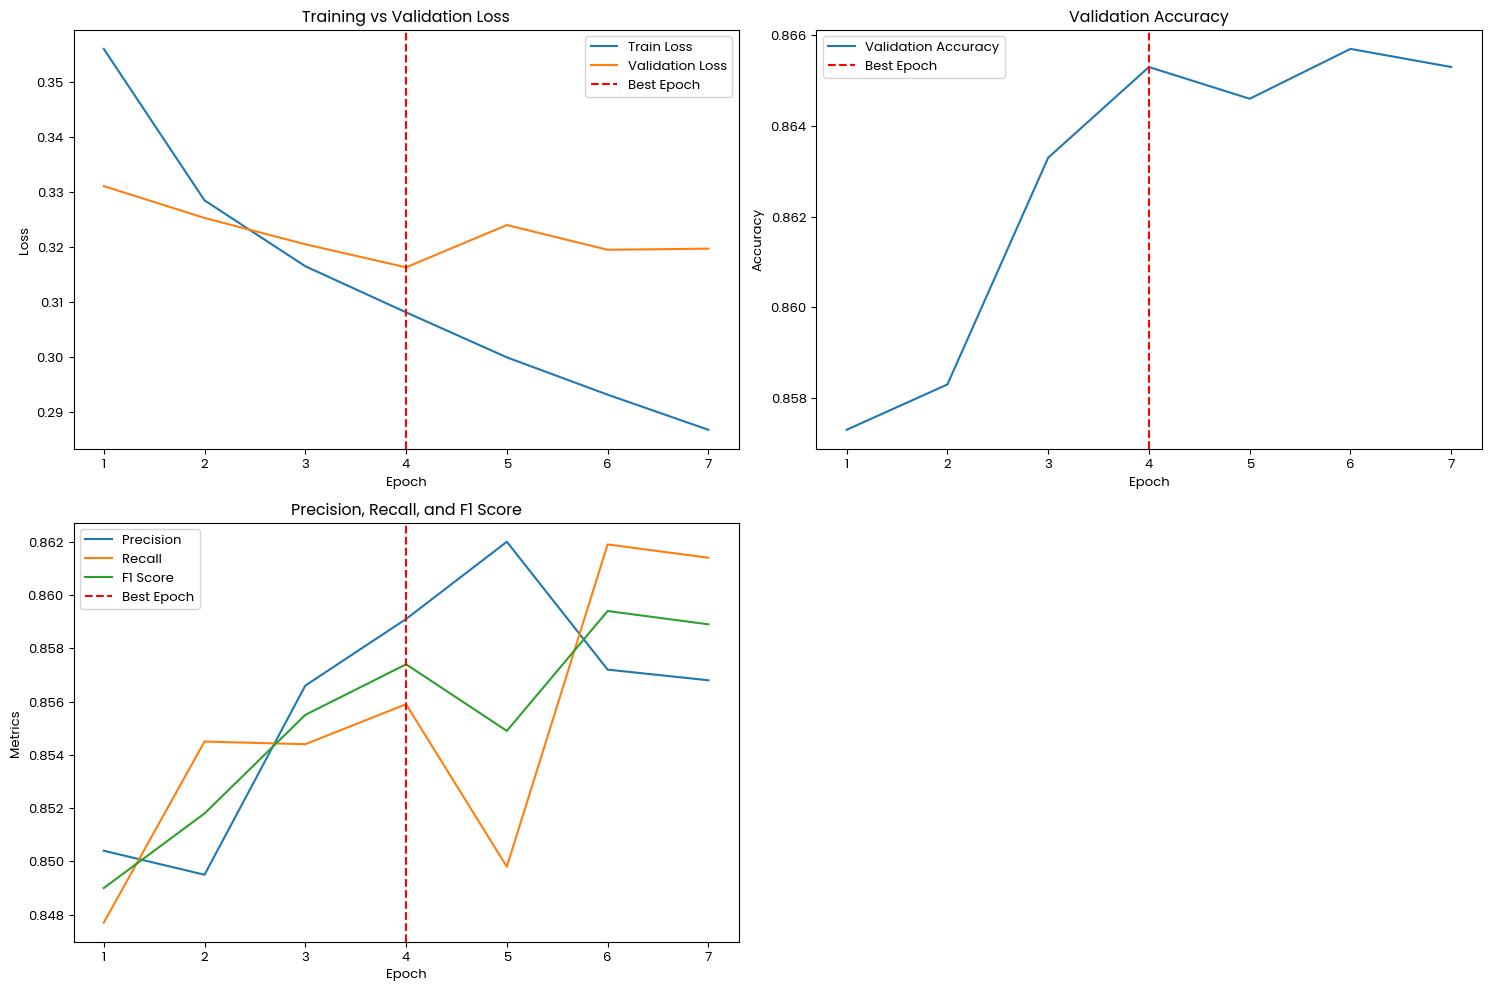

In [ ]:
# Use the function with your print_result data
plot_epoch_metrics(bert_print_result, 4)

<font face="Poppins" size=2>1. **Training vs Validation Loss Chart**:</font><br>
<font face="Poppins" size=2>   - The training loss consistently decreases, indicating that the model is learning from the training data.</font><br>
<font face="Poppins" size=2>   - The validation loss also generally decreases but sees a slight increase at Epoch 5, suggesting a possible beginning of overfitting or variance in the validation data. However, it decreases again at Epoch 6, which might indicate the model is still generalizing well.</font><br>
<font face="Poppins" size=2>   - The best epoch, marked by the red dashed line, appears to be Epoch 4, which has the lowest validation loss while still maintaining a downward trend in training loss.</font><br><br>

<font face="Poppins" size=2>2. **Validation Accuracy Chart**:</font><br>
<font face="Poppins" size=2>   - The validation accuracy shows an overall upward trend, indicating that the model is getting better at correctly predicting the validation data.</font><br>
<font face="Poppins" size=2>   - The peak accuracy is at Epoch 6, which is slightly after the marked best epoch.</font><br>
<font face="Poppins" size=2>   - After Epoch 4, the accuracy plateaus somewhat, suggesting that subsequent improvements might be marginal.</font><br><br>

<font face="Poppins" size=2>3. **Precision, Recall, and F1 Score Chart**:</font><br>
<font face="Poppins" size=2>   - Precision and recall both show variability across epochs, which is common as the model's predictions fluctuate with the changes in the weights during training.</font><br>
<font face="Poppins" size=2>   - The F1 score, which balances precision and recall, appears to peak at Epoch 4, the marked best epoch.</font><br>
<font face="Poppins" size=2>   - There's a noticeable dip in precision and F1 score at Epoch 5, which correlates with the increase in validation loss, indicating the model's performance on the validation set was less optimal at this point.</font><br><br>

# <font face="Poppins" size=2>Model building for text (T5) 2 way</font><br>

In [ ]:
train_features_tensor = torch.tensor(train_t5_features_extraction).float().to(device)

In [ ]:
train_features_tensor.shape[1]

512

In [ ]:
validate_features_tensor = torch.tensor(validate_t5_features_extraction).float().to(device)

In [ ]:
validate_features_tensor.shape[1]

512

In [ ]:
test_features_tensor = torch.tensor(test_t5_features_extraction).float().to(device)

In [ ]:
test_features_tensor.shape[1]

512

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to calculate metrics
def calculate_metrics(preds, labels):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return accuracy, precision, recall, f1


# Convert features to PyTorch tensors
train_features_tensor = torch.tensor(train_t5_features_extraction).float().to(device)
validate_features_tensor = torch.tensor(validate_t5_features_extraction).float().to(device)
test_features_tensor = torch.tensor(test_t5_features_extraction).float().to(device)

# Extract 2_way labels
train_t5_labels_2_way = train_t5_merged_df['2_way_label'].values  # Assuming '2_way_label' is the column name for 2_way classification labels
validate_t5_labels_2_way = validate_t5_merged_df['2_way_label'].values
test_t5_labels_2_way = test_t5_merged_df['2_way_label'].values

# Convert 2_way classification labels to PyTorch tensors
train_labels_tensor = torch.tensor(train_t5_labels_2_way).long().to(device)
validate_labels_tensor = torch.tensor(validate_t5_labels_2_way).long().to(device)
test_labels_tensor = torch.tensor(test_t5_labels_2_way).long().to(device)

# Create TensorDatasets and DataLoaders
train_t5_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
validate_t5_dataset = TensorDataset(validate_features_tensor, validate_labels_tensor)
test_t5_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

batch_size = 16  #batch size
train_t5_loader = DataLoader(train_t5_dataset, batch_size=batch_size, shuffle=True)
validate_t5_loader = DataLoader(validate_t5_dataset, batch_size=batch_size)
test_t5_loader = DataLoader(test_t5_dataset, batch_size=batch_size)

# Define the neural network t5_model for multi-label classification
class T5Classifier(nn.Module):
    def __init__(self, feature_vector_size, num_classes):
        super(T5Classifier, self).__init__()
        # The first linear layer matches the feature vector size of 512
        self.fc1 = nn.Linear(feature_vector_size, 256)  # Reduce size to 256
        self.relu = nn.ReLU()
        # Second linear layer
        self.fc2 = nn.Linear(256, 128)  # Further reduce size to 128
        # Third linear layer, leading to the final output
        self.fc3 = nn.Linear(128, num_classes)  # num_classes is 2 for 2_way classification

    def forward(self, x):
        x = self.fc1(x)  # Input pass through the first layer
        x = self.relu(x)  # Apply ReLU activation function
        x = self.fc2(x)  # Pass through the second layer
        x = self.relu(x)  # Apply ReLU activation function
        x = self.fc3(x)  # Pass through the final layer to get the output
        return x

# Initialize the t5_model
num_features = train_features_tensor.shape[1]  # Number of features in your dataset
num_classes = 2  # Adjust this based on your classification task (2, 3, or 6)
t5_model = T5Classifier(num_features, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class; for multi-label, you might need BCEWithLogitsLoss
optimizer = torch.optim.Adam(t5_model.parameters(), lr=1e-3)

# Training loop with early stopping
num_epochs = 20
best_val_loss = float('inf')
patience_counter = 0
patience = 3

t5_print_result = []

for epoch in range(num_epochs):
    t5_model.train()
    total_loss = 0
    for features, labels in tqdm_notebook(train_t5_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        features, labels = features.to(device), labels.to(device)
        outputs = t5_model(features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_t5_loader)
    # Here, you would calculate train_accuracy, train_precision, train_recall, train_f1 if needed

    t5_model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for features, labels in validate_t5_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = t5_model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(validate_t5_loader)
    val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(np.array(all_val_preds), np.array(all_val_labels))

         # Save the t5_model at the end of each epoch
    save_path = f"/content/t5_models/t5_2_way_label_appended_epoch_{epoch}"
    save_path_google_drive = f"/content/drive/MyDrive/multimodal_only_samples/t5_models/t5_2_way_label_appended_epoch_{epoch}"
    # Create the directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if not os.path.exists(save_path_google_drive):
        os.makedirs(save_path_google_drive)


    # Save the t5_model's state dictionary
    torch.save(t5_model.state_dict(), save_path + '/t5_model_state_dict.pt')
    torch.save(t5_model.state_dict(), save_path_google_drive + '/t5_model_state_dict.pt')
    print(f"Model saved to {save_path_google_drive}")

    t5_print_result.append(f"Epoch {epoch + 1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}")
    print(f"Epoch {epoch + 1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
    t5_print_result.append(f"Epoch {epoch + 1}/{num_epochs} - Avg Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      patience_counter = 0
    else:
      patience_counter += 1
      if patience_counter >= patience:
          print("Early stopping triggered")
          break


# Print all results at the end
for result in t5_print_result:
    print(result)

Epoch 1/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_2_way_label_appended_epoch_0
Epoch 1/20 - Avg Train Loss: 0.4112, Avg Val Loss: 0.3886, Val Acc: 0.8259, Precision: 0.8180, Recall: 0.8125, F1: 0.8150


Epoch 2/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_2_way_label_appended_epoch_1
Epoch 2/20 - Avg Train Loss: 0.3824, Avg Val Loss: 0.3782, Val Acc: 0.8299, Precision: 0.8269, Recall: 0.8099, F1: 0.8164


Epoch 3/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_2_way_label_appended_epoch_2
Epoch 3/20 - Avg Train Loss: 0.3717, Avg Val Loss: 0.3737, Val Acc: 0.8351, Precision: 0.8288, Recall: 0.8204, F1: 0.8240


Epoch 4/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_2_way_label_appended_epoch_3
Epoch 4/20 - Avg Train Loss: 0.3652, Avg Val Loss: 0.3707, Val Acc: 0.8372, Precision: 0.8288, Recall: 0.8271, F1: 0.8280


Epoch 5/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_2_way_label_appended_epoch_4
Epoch 5/20 - Avg Train Loss: 0.3604, Avg Val Loss: 0.3614, Val Acc: 0.8411, Precision: 0.8326, Recall: 0.8321, F1: 0.8324


Epoch 6/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_2_way_label_appended_epoch_5
Epoch 6/20 - Avg Train Loss: 0.3564, Avg Val Loss: 0.3617, Val Acc: 0.8427, Precision: 0.8336, Recall: 0.8360, F1: 0.8347


Epoch 7/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_2_way_label_appended_epoch_6
Epoch 7/20 - Avg Train Loss: 0.3532, Avg Val Loss: 0.3593, Val Acc: 0.8417, Precision: 0.8343, Recall: 0.8303, F1: 0.8322


Epoch 8/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_2_way_label_appended_epoch_7
Epoch 8/20 - Avg Train Loss: 0.3504, Avg Val Loss: 0.3587, Val Acc: 0.8422, Precision: 0.8343, Recall: 0.8320, F1: 0.8331


Epoch 9/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_2_way_label_appended_epoch_8
Epoch 9/20 - Avg Train Loss: 0.3476, Avg Val Loss: 0.3591, Val Acc: 0.8437, Precision: 0.8402, Recall: 0.8265, F1: 0.8321


Epoch 10/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_2_way_label_appended_epoch_9
Epoch 10/20 - Avg Train Loss: 0.3454, Avg Val Loss: 0.3542, Val Acc: 0.8460, Precision: 0.8381, Recall: 0.8363, F1: 0.8372


Epoch 11/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_2_way_label_appended_epoch_10
Epoch 11/20 - Avg Train Loss: 0.3430, Avg Val Loss: 0.3569, Val Acc: 0.8461, Precision: 0.8394, Recall: 0.8341, F1: 0.8365


Epoch 12/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_2_way_label_appended_epoch_11
Epoch 12/20 - Avg Train Loss: 0.3411, Avg Val Loss: 0.3614, Val Acc: 0.8443, Precision: 0.8364, Recall: 0.8344, F1: 0.8354


Epoch 13/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_2_way_label_appended_epoch_12
Epoch 13/20 - Avg Train Loss: 0.3391, Avg Val Loss: 0.3564, Val Acc: 0.8453, Precision: 0.8386, Recall: 0.8332, F1: 0.8356
Early stopping triggered
Epoch 1/20 - Avg Train Loss: 0.4112
Epoch 1/20 - Avg Val Loss: 0.3886, Val Acc: 0.8259, Precision: 0.8180, Recall: 0.8125, F1: 0.8150
Epoch 2/20 - Avg Train Loss: 0.3824
Epoch 2/20 - Avg Val Loss: 0.3782, Val Acc: 0.8299, Precision: 0.8269, Recall: 0.8099, F1: 0.8164
Epoch 3/20 - Avg Train Loss: 0.3717
Epoch 3/20 - Avg Val Loss: 0.3737, Val Acc: 0.8351, Precision: 0.8288, Recall: 0.8204, F1: 0.8240
Epoch 4/20 - Avg Train Loss: 0.3652
Epoch 4/20 - Avg Val Loss: 0.3707, Val Acc: 0.8372, Precision: 0.8288, Recall: 0.8271, F1: 0.8280
Epoch 5/20 - Avg Train Loss: 0.3604
Epoch 5/20 - Avg Val Loss: 0.3614, Val Acc: 0.8411, Precision: 0.8326, Recall: 0.8321, F1: 0.8324
Epoch 6/20 - Avg Train Loss: 0.3564
Epoch 6/20 - Avg Val Loss: 0.3617, Val Ac

In [ ]:
t5_model

T5Classifier(
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
evaluate_model_2_way(t5_model, test_t5_loader, device)

Accuracy: 0.8424
Precision: 0.8416
Recall: 0.8424
F1 Score: 0.8418
              precision    recall  f1-score   support

        Fake       0.86      0.88      0.87     34730
        True       0.81      0.78      0.79     22263

    accuracy                           0.84     56993
   macro avg       0.84      0.83      0.83     56993
weighted avg       0.84      0.84      0.84     56993



In [ ]:
t5_print_result

['Epoch 1/20 - Avg Train Loss: 0.4112',
 'Epoch 1/20 - Avg Val Loss: 0.3886, Val Acc: 0.8259, Precision: 0.8180, Recall: 0.8125, F1: 0.8150',
 'Epoch 2/20 - Avg Train Loss: 0.3824',
 'Epoch 2/20 - Avg Val Loss: 0.3782, Val Acc: 0.8299, Precision: 0.8269, Recall: 0.8099, F1: 0.8164',
 'Epoch 3/20 - Avg Train Loss: 0.3717',
 'Epoch 3/20 - Avg Val Loss: 0.3737, Val Acc: 0.8351, Precision: 0.8288, Recall: 0.8204, F1: 0.8240',
 'Epoch 4/20 - Avg Train Loss: 0.3652',
 'Epoch 4/20 - Avg Val Loss: 0.3707, Val Acc: 0.8372, Precision: 0.8288, Recall: 0.8271, F1: 0.8280',
 'Epoch 5/20 - Avg Train Loss: 0.3604',
 'Epoch 5/20 - Avg Val Loss: 0.3614, Val Acc: 0.8411, Precision: 0.8326, Recall: 0.8321, F1: 0.8324',
 'Epoch 6/20 - Avg Train Loss: 0.3564',
 'Epoch 6/20 - Avg Val Loss: 0.3617, Val Acc: 0.8427, Precision: 0.8336, Recall: 0.8360, F1: 0.8347',
 'Epoch 7/20 - Avg Train Loss: 0.3532',
 'Epoch 7/20 - Avg Val Loss: 0.3593, Val Acc: 0.8417, Precision: 0.8343, Recall: 0.8303, F1: 0.8322',
 'Epoc

In [58]:
metrics_data_t5_2_way = [
    ['Metric', 'Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5', 'Epoch 6', 'Epoch 7', 'Epoch 8', 'Epoch 9',
     'Epoch 10', 'Epoch 11', 'Epoch 12', 'Epoch 13'],
    ['Avg Train Loss', '0.4112', '0.3824', '0.3717', '0.3652', '0.3604', '0.3564', '0.3532', '0.3504', '0.3476',
     '0.3454', '0.3430', '0.3411', '0.3391'],
    ['Avg Val Loss', '0.3886', '0.3782', '0.3737', '0.3707', '0.3614', '0.3617', '0.3593', '0.3587', '0.3591',
     '0.3542', '0.3569', '0.3614', '0.3564'],
    ['Val Acc', '0.8259', '0.8299', '0.8351', '0.8372', '0.8411', '0.8427', '0.8417', '0.8422', '0.8437',
     '0.8460', '0.8461', '0.8443', '0.8453'],
    ['Precision', '0.8180', '0.8269', '0.8288', '0.8288', '0.8326', '0.8336', '0.8343', '0.8343', '0.8402',
     '0.8381', '0.8394', '0.8364', '0.8386'],
    ['Recall', '0.8125', '0.8099', '0.8204', '0.8271', '0.8321', '0.8360', '0.8303', '0.8320', '0.8265',
     '0.8363', '0.8341', '0.8344', '0.8332'],
    ['F1', '0.8150', '0.8164', '0.8240', '0.8280', '0.8324', '0.8347', '0.8322', '0.8331', '0.8321',
     '0.8372', '0.8365', '0.8354', '0.8356']
]


# Save the document
metrics_doc_path = '/content/Model_Training_Metrics_T5_2_Way.docx'
create_metrics_document(metrics_data_t5_2_way , metrics_doc_path)

'/content/Model_Training_Metrics_T5_2_Way.docx'

<font face="Poppins" size=2>To determine the best epoch and assess for overfitting, let's consider both the loss and performance metrics across the epochs:</font><br><br>

<font face="Poppins" size=2>- The **best epoch** is typically where the validation loss is at its lowest, and the validation accuracy and other performance metrics (precision, recall, F1 score) are at their highest.</font><br>

<font face="Poppins" size=2>- **Overfitting** is indicated when the training loss continues to decrease, but the validation loss starts to increase, or the validation performance metrics (accuracy, precision, recall, F1 score) begin to decrease.</font><br><br>

<font face="Poppins" size=2>Looking at the data:</font><br><br>

<font face="Poppins" size=2>- The **lowest validation loss** is observed in **Epoch 10** with a value of **0.3542**.</font><br>

<font face="Poppins" size=2>- The **highest validation accuracy** is also observed in **Epoch 10** with a value of **0.8460**.</font><br>

<font face="Poppins" size=2>- The **precision, recall, and F1 score** are not strictly increasing, but they are relatively high in Epoch 10, with precision peaking at this point as well.</font><br><br>

<font face="Poppins" size=2>Given these observations, **Epoch 10** would be considered the best epoch as it has the lowest validation loss, the highest accuracy, and strong performance metrics overall.</font><br><br>

<font face="Poppins" size=2>Regarding overfitting:</font><br>

<font face="Poppins" size=2>- The training loss is decreasing consistently, which is good as it indicates the model is learning.</font><br>

<font face="Poppins" size=2>- The validation loss decreases and reaches the lowest at Epoch 10, but it shows a slight increase in Epoch 11 and more noticeably in Epoch 12. This could be an early sign of overfitting.</font><br>

<font face="Poppins" size=2>- The validation accuracy seems to peak at Epoch 11, but it's only marginally higher than in Epoch 10. It then decreases slightly in Epoch 12, another potential indicator of overfitting.</font><br><br>

<font face="Poppins" size=2>In summary, **Epoch 10** appears to be the best epoch before the model starts showing possible signs of overfitting. To confirm these trends, it would be necessary to observe the remaining epochs. If the validation loss continues to increase and the validation metrics do not improve, it would indeed suggest that the model is beginning to overfit.</font>


In [ ]:
# Open the file in write mode and write the result data
with open(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_t5_print_result_epoch_2_way.txt', 'w') as file:
    for line in t5_print_result:
        file.write(line + '\n')

In [ ]:
t5_print_result = []
# Open the file in read mode
with open(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_t5_print_result_epoch_2_way.txt', 'r') as file:
    for line in file:
        # Strip newline characters from the end of each line
        clean_line = line.strip()
        # Append the clean line to the list
        t5_print_result.append(clean_line)

In [ ]:
# t5_best_epoch = find_best_epoch(t5_print_result)
# print(f"Best epoch for the first set: {t5_best_epoch}")

Best epoch for the first set: 10


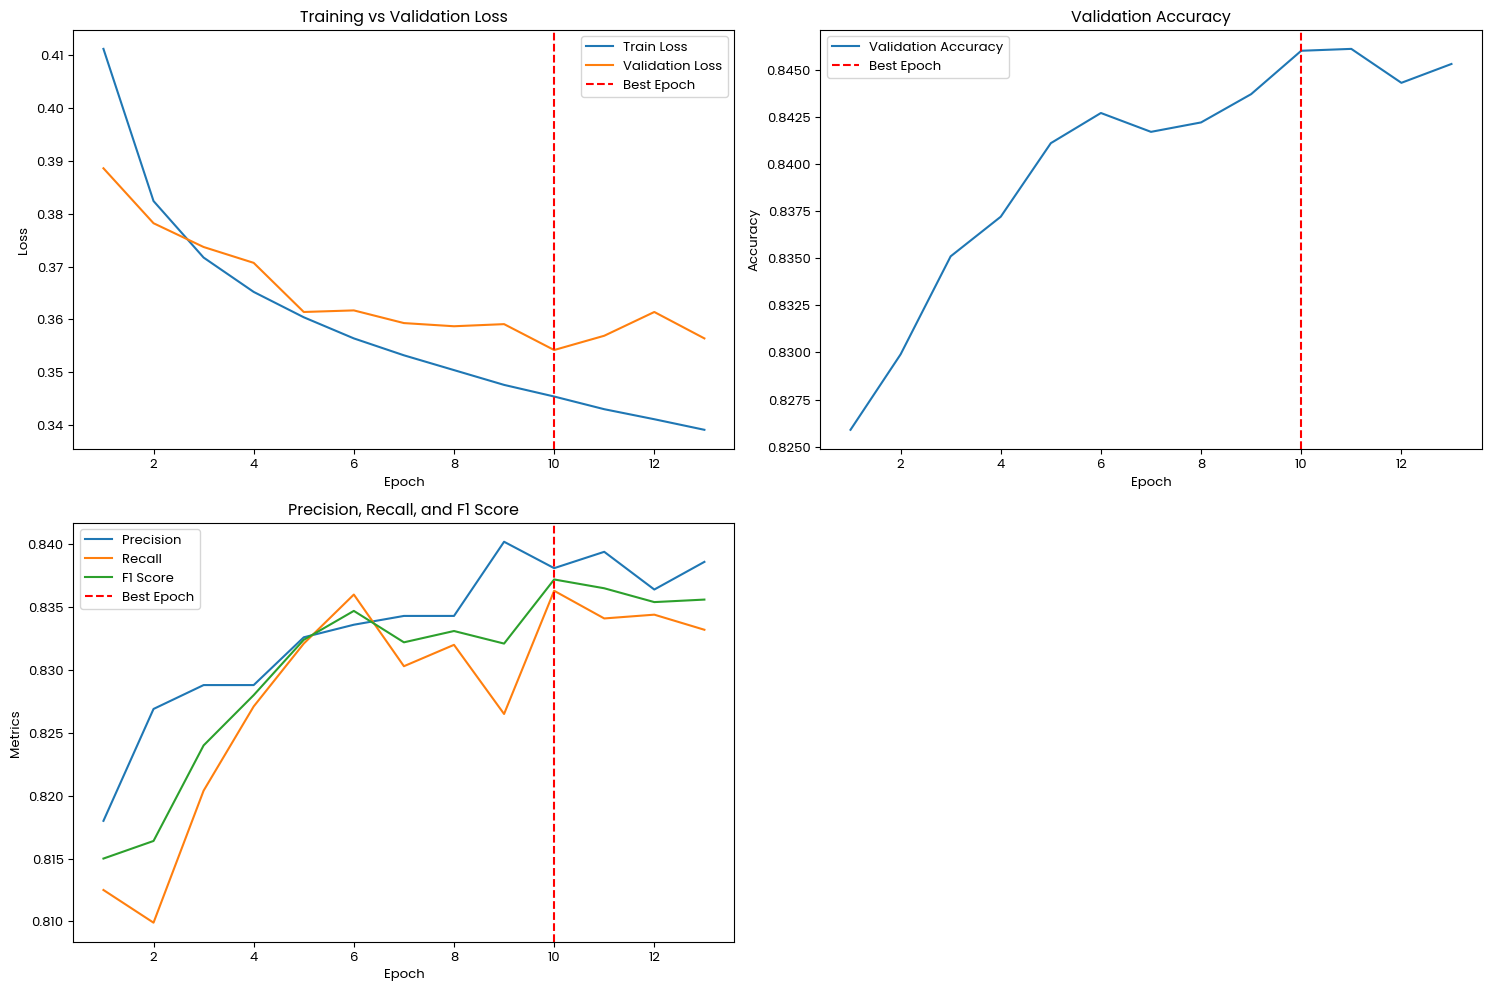

In [ ]:
# Use the function with your print_result data
plot_epoch_metrics(t5_print_result, 10)

<font face="Poppins" size=2>1. **Training vs Validation Loss Chart**:
   - The training loss shows a consistent decrease, which is typical during training as the model is learning from the training data.
   - The validation loss decreases alongside the training loss but has a slight uptick after Epoch 10, which is marked as the best epoch. This could suggest that the model's generalization to unseen data may be starting to plateau or decrease slightly.
   - The best epoch, as indicated by the red dashed line, is Epoch 10, which aligns with the lowest validation loss.</font><br>

<font face="Poppins" size=2>2. **Validation Accuracy Chart**:
   - The validation accuracy increases over time, with a notable rise between Epochs 1-10. It peaks at Epoch 10, after which it slightly declines and then plateaus.
   - The peak of validation accuracy at Epoch 10 corroborates the selection of this epoch as the best one.</font><br>

<font face="Poppins" size=2>3. **Precision, Recall, and F1 Score Chart**:
   - These metrics fluctuate over the epochs, which is not uncommon in model training as different epochs will capture different balances of false positives and false negatives.
   - Precision peaks around Epoch 9, while recall peaks at Epoch 6. The F1 score, which is a harmonic mean of precision and recall, appears highest at Epoch 10. This score is typically looked at for a balance between precision and recall and often is a key metric when choosing the best model.
   - The best epoch (Epoch 10) seems to provide a good balance between precision and recall, as indicated by the F1 score.</font><br>

<font face="Poppins" size=2>From these charts, it's evident that Epoch 10 is when the model has the lowest validation loss and highest accuracy and F1 score, which suggests it is the most generalized and balanced epoch before performance starts to plateau or slightly decline.</font><br><br>

<font face="Poppins" size=2>As for overfitting, it's indicated by the slight increase in validation loss after Epoch 10 and the decrease/stagnation in validation accuracy and F1 score. This could be a sign that the model is starting to overfit to the training data beyond Epoch 10, as it performs better on the training data than on the unseen validation data. However, the extent of overfitting here seems minor, and the model is still performing relatively well on the validation set up to Epoch 13. It would be advisable to continue monitoring for more epochs to fully assess the trend and confirm if overfitting becomes more significant.</font>


# <font face="Poppins" size=2>Model building for text (Roberta) 2 way</font><br>

In [ ]:
train_features_tensor = torch.tensor(train_roberta_features_extraction).float().to(device)

In [ ]:
train_features_tensor.shape[1]

768

In [ ]:
validate_features_tensor = torch.tensor(validate_roberta_features_extraction).float().to(device)

In [ ]:
validate_features_tensor.shape[1]

768

In [ ]:
test_features_tensor = torch.tensor(test_roberta_features_extraction).float().to(device)

In [ ]:
test_features_tensor.shape[1]

768

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to calculate metrics
def calculate_metrics(preds, labels):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return accuracy, precision, recall, f1


# Convert features to PyTorch tensors
train_features_tensor = torch.tensor(train_roberta_features_extraction).float().to(device)
validate_features_tensor = torch.tensor(validate_roberta_features_extraction).float().to(device)
test_features_tensor = torch.tensor(test_roberta_features_extraction).float().to(device)

# Extract 2_way labels
train_roberta_labels_2_way = train_roberta_merged_df['2_way_label'].values  # Assuming '2_way_label' is the column name for 2_way classification labels
validate_roberta_labels_2_way = validate_roberta_merged_df['2_way_label'].values
test_roberta_labels_2_way = test_roberta_merged_df['2_way_label'].values

# Convert 2_way classification labels to PyTorch tensors
train_labels_tensor = torch.tensor(train_roberta_labels_2_way).long().to(device)
validate_labels_tensor = torch.tensor(validate_roberta_labels_2_way).long().to(device)
test_labels_tensor = torch.tensor(test_roberta_labels_2_way).long().to(device)

# Create TensorDatasets and DataLoaders
train_roberta_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
validate_roberta_dataset = TensorDataset(validate_features_tensor, validate_labels_tensor)
test_roberta_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

batch_size = 16  #batch size
train_roberta_loader = DataLoader(train_roberta_dataset, batch_size=batch_size, shuffle=True)
validate_roberta_loader = DataLoader(validate_roberta_dataset, batch_size=batch_size)
test_roberta_loader = DataLoader(test_roberta_dataset, batch_size=batch_size)

# Define the neural network roberta_model for multi-label classification
class MultiLabelNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultiLabelNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Initialize the roberta_model
num_features = train_features_tensor.shape[1]  # Number of features in your dataset
num_classes = 2  # Adjust this based on your classification task (2, 3, or 6)
roberta_model = MultiLabelNN(num_features, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class; for multi-label, you might need BCEWithLogitsLoss
optimizer = torch.optim.Adam(roberta_model.parameters(), lr=1e-3)

# Training loop with early stopping
num_epochs = 20
best_val_loss = float('inf')
patience_counter = 0
patience = 3

roberta_print_result = []

for epoch in range(num_epochs):
    roberta_model.train()
    total_loss = 0
    for features, labels in tqdm_notebook(train_roberta_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        features, labels = features.to(device), labels.to(device)
        outputs = roberta_model(features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_roberta_loader)
    # Here, you would calculate train_accuracy, train_precision, train_recall, train_f1 if needed

    roberta_model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for features, labels in validate_roberta_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = roberta_model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(validate_roberta_loader)
    val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(np.array(all_val_preds), np.array(all_val_labels))

         # Save the roberta_model at the end of each epoch
    save_path = f"/content/roberta_models/roberta_2_way_label_appended_epoch_{epoch}"
    save_path_google_drive = f"/content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_2_way_label_appended_epoch_{epoch}"
    # Create the directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if not os.path.exists(save_path_google_drive):
        os.makedirs(save_path_google_drive)


    # Save the roberta_model's state dictionary
    torch.save(roberta_model.state_dict(), save_path + '/roberta_model_state_dict.pt')
    torch.save(roberta_model.state_dict(), save_path_google_drive + '/roberta_model_state_dict.pt')
    print(f"Model saved to {save_path_google_drive}")

    roberta_print_result.append(f"Epoch {epoch + 1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}")
    print(f"Epoch {epoch + 1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
    roberta_print_result.append(f"Epoch {epoch + 1}/{num_epochs} - Avg Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      patience_counter = 0
    else:
      patience_counter += 1
      if patience_counter >= patience:
          print("Early stopping triggered")
          break


# Print all results at the end
for result in roberta_print_result:
    print(result)

Epoch 1/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_2_way_label_appended_epoch_0
Epoch 1/20 - Avg Train Loss: 0.3679, Avg Val Loss: 0.3675, Val Acc: 0.8353, Precision: 0.8273, Recall: 0.8416, F1: 0.8309


Epoch 2/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_2_way_label_appended_epoch_1
Epoch 2/20 - Avg Train Loss: 0.3403, Avg Val Loss: 0.3387, Val Acc: 0.8548, Precision: 0.8504, Recall: 0.8408, F1: 0.8450


Epoch 3/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_2_way_label_appended_epoch_2
Epoch 3/20 - Avg Train Loss: 0.3288, Avg Val Loss: 0.3337, Val Acc: 0.8557, Precision: 0.8468, Recall: 0.8517, F1: 0.8490


Epoch 4/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_2_way_label_appended_epoch_3
Epoch 4/20 - Avg Train Loss: 0.3210, Avg Val Loss: 0.3294, Val Acc: 0.8591, Precision: 0.8514, Recall: 0.8518, F1: 0.8516


Epoch 5/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_2_way_label_appended_epoch_4
Epoch 5/20 - Avg Train Loss: 0.3140, Avg Val Loss: 0.3438, Val Acc: 0.8553, Precision: 0.8588, Recall: 0.8334, F1: 0.8424


Epoch 6/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_2_way_label_appended_epoch_5
Epoch 6/20 - Avg Train Loss: 0.3088, Avg Val Loss: 0.3330, Val Acc: 0.8596, Precision: 0.8556, Recall: 0.8457, F1: 0.8500


Epoch 7/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_2_way_label_appended_epoch_6
Epoch 7/20 - Avg Train Loss: 0.3030, Avg Val Loss: 0.3334, Val Acc: 0.8596, Precision: 0.8559, Recall: 0.8455, F1: 0.8499
Early stopping triggered
Epoch 1/20 - Avg Train Loss: 0.3679
Epoch 1/20 - Avg Val Loss: 0.3675, Val Acc: 0.8353, Precision: 0.8273, Recall: 0.8416, F1: 0.8309
Epoch 2/20 - Avg Train Loss: 0.3403
Epoch 2/20 - Avg Val Loss: 0.3387, Val Acc: 0.8548, Precision: 0.8504, Recall: 0.8408, F1: 0.8450
Epoch 3/20 - Avg Train Loss: 0.3288
Epoch 3/20 - Avg Val Loss: 0.3337, Val Acc: 0.8557, Precision: 0.8468, Recall: 0.8517, F1: 0.8490
Epoch 4/20 - Avg Train Loss: 0.3210
Epoch 4/20 - Avg Val Loss: 0.3294, Val Acc: 0.8591, Precision: 0.8514, Recall: 0.8518, F1: 0.8516
Epoch 5/20 - Avg Train Loss: 0.3140
Epoch 5/20 - Avg Val Loss: 0.3438, Val Acc: 0.8553, Precision: 0.8588, Recall: 0.8334, F1: 0.8424
Epoch 6/20 - Avg Train Loss: 0.3088
Epoch 6/20 - Avg Val Loss: 0.3330

In [ ]:
roberta_model

MultiLabelNN(
  (fc1): Linear(in_features=768, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
evaluate_model_2_way(roberta_model, test_roberta_loader, device)

Accuracy: 0.8585
Precision: 0.8579
Recall: 0.8585
F1 Score: 0.8575
              precision    recall  f1-score   support

        Fake       0.87      0.91      0.89     34730
        True       0.84      0.78      0.81     22263

    accuracy                           0.86     56993
   macro avg       0.86      0.84      0.85     56993
weighted avg       0.86      0.86      0.86     56993



In [ ]:
roberta_print_result

['Epoch 1/20 - Avg Train Loss: 0.3679',
 'Epoch 1/20 - Avg Val Loss: 0.3675, Val Acc: 0.8353, Precision: 0.8273, Recall: 0.8416, F1: 0.8309',
 'Epoch 2/20 - Avg Train Loss: 0.3403',
 'Epoch 2/20 - Avg Val Loss: 0.3387, Val Acc: 0.8548, Precision: 0.8504, Recall: 0.8408, F1: 0.8450',
 'Epoch 3/20 - Avg Train Loss: 0.3288',
 'Epoch 3/20 - Avg Val Loss: 0.3337, Val Acc: 0.8557, Precision: 0.8468, Recall: 0.8517, F1: 0.8490',
 'Epoch 4/20 - Avg Train Loss: 0.3210',
 'Epoch 4/20 - Avg Val Loss: 0.3294, Val Acc: 0.8591, Precision: 0.8514, Recall: 0.8518, F1: 0.8516',
 'Epoch 5/20 - Avg Train Loss: 0.3140',
 'Epoch 5/20 - Avg Val Loss: 0.3438, Val Acc: 0.8553, Precision: 0.8588, Recall: 0.8334, F1: 0.8424',
 'Epoch 6/20 - Avg Train Loss: 0.3088',
 'Epoch 6/20 - Avg Val Loss: 0.3330, Val Acc: 0.8596, Precision: 0.8556, Recall: 0.8457, F1: 0.8500',
 'Epoch 7/20 - Avg Train Loss: 0.3030',
 'Epoch 7/20 - Avg Val Loss: 0.3334, Val Acc: 0.8596, Precision: 0.8559, Recall: 0.8455, F1: 0.8499']

In [59]:
metrics_data_roberta_2_way = [
    ['Metric', 'Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5', 'Epoch 6', 'Epoch 7'],
    ['Avg Train Loss', '0.3679', '0.3403', '0.3288', '0.3210', '0.3140', '0.3088', '0.3030'],
    ['Avg Val Loss', '0.3675', '0.3387', '0.3337', '0.3294', '0.3438', '0.3330', '0.3334'],
    ['Val Acc', '0.8353', '0.8548', '0.8557', '0.8591', '0.8553', '0.8596', '0.8596'],
    ['Precision', '0.8273', '0.8504', '0.8468', '0.8514', '0.8588', '0.8556', '0.8559'],
    ['Recall', '0.8416', '0.8408', '0.8517', '0.8518', '0.8334', '0.8457', '0.8455'],
    ['F1', '0.8309', '0.8450', '0.8490', '0.8516', '0.8424', '0.8500', '0.8499']
]



# Save the document
metrics_doc_path = '/content/Model_Training_Metrics_ROBERTA_2_Way.docx'
create_metrics_document(metrics_data_roberta_2_way, metrics_doc_path)

'/content/Model_Training_Metrics_ROBERTA_2_Way.docx'

<font face="Poppins" size=2>To determine the best epoch and assess overfitting, let's consider both the loss and performance metrics across the epochs provided:</font><br><br>

<font face="Poppins" size=2>1. **Lowest Validation Loss**: This is observed at **Epoch 4** with a validation loss of **0.3294**.</font><br>

<font face="Poppins" size=2>2. **Highest Validation Accuracy**: This peaks at **Epoch 6** and **Epoch 7** with a validation accuracy of **0.8596**.</font><br>

<font face="Poppins" size=2>3. **Best Performance Metrics**: Looking at precision, recall, and F1 scores, **Epoch 4** has a high balance of precision and recall, resulting in an F1 score of **0.8516**. This is the highest F1 score across the epochs.</font><br>

<font face="Poppins" size=2>Based on the above points, **Epoch 4** appears to be the best epoch since it has the lowest validation loss and a high F1 score. Precision and recall are well balanced in this epoch, and the validation accuracy is close to the highest value observed in subsequent epochs.</font><br><br>

<font face="Poppins" size=2>Regarding overfitting:</font><br>

<font face="Poppins" size=2>- **Training Loss Trend**: The training loss is decreasing consistently, which indicates that the model is learning.</font><br>

<font face="Poppins" size=2>- **Validation Loss Trend**: The validation loss decreases until Epoch 4 and then increases at Epoch 5, which could be an initial sign of overfitting. However, it comes down again in Epochs 6 and 7, which suggests that the model may still be generalizing well.</font><br>

<font face="Poppins" size=2>- **Validation Accuracy and Performance Metrics**: The validation accuracy remains stable and high in Epochs 6 and 7, and the precision, recall, and F1 score are consistent, which does not strongly indicate overfitting.</font><br>

<font face="Poppins" size=2>In conclusion, up to Epoch 7, we do not see strong signs of overfitting. The model is still performing well on the validation set. The slight increase in validation loss at Epoch 5 followed by a decrease in Epochs 6 and 7 suggests that the model may have experienced a minor variance in performance rather than overfitting. It would be advisable to monitor if the validation loss starts increasing consistently in subsequent epochs, which would be a clearer indicator of overfitting.</font>


In [ ]:
# Open the file in write mode and write the result data
with open(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_roberta_print_result_epoch_2_way.txt', 'w') as file:
    for line in roberta_print_result:
        file.write(line + '\n')

In [ ]:
roberta_print_result = []
# Open the file in read mode
with open(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_roberta_print_result_epoch_2_way.txt', 'r') as file:
    for line in file:
        # Strip newline characters from the end of each line
        clean_line = line.strip()
        # Append the clean line to the list
        roberta_print_result.append(clean_line)

In [ ]:
roberta_print_result

['Epoch 1/20 - Avg Train Loss: 0.3679',
 'Epoch 1/20 - Avg Val Loss: 0.3675, Val Acc: 0.8353, Precision: 0.8273, Recall: 0.8416, F1: 0.8309',
 'Epoch 2/20 - Avg Train Loss: 0.3403',
 'Epoch 2/20 - Avg Val Loss: 0.3387, Val Acc: 0.8548, Precision: 0.8504, Recall: 0.8408, F1: 0.8450',
 'Epoch 3/20 - Avg Train Loss: 0.3288',
 'Epoch 3/20 - Avg Val Loss: 0.3337, Val Acc: 0.8557, Precision: 0.8468, Recall: 0.8517, F1: 0.8490',
 'Epoch 4/20 - Avg Train Loss: 0.3210',
 'Epoch 4/20 - Avg Val Loss: 0.3294, Val Acc: 0.8591, Precision: 0.8514, Recall: 0.8518, F1: 0.8516',
 'Epoch 5/20 - Avg Train Loss: 0.3140',
 'Epoch 5/20 - Avg Val Loss: 0.3438, Val Acc: 0.8553, Precision: 0.8588, Recall: 0.8334, F1: 0.8424',
 'Epoch 6/20 - Avg Train Loss: 0.3088',
 'Epoch 6/20 - Avg Val Loss: 0.3330, Val Acc: 0.8596, Precision: 0.8556, Recall: 0.8457, F1: 0.8500',
 'Epoch 7/20 - Avg Train Loss: 0.3030',
 'Epoch 7/20 - Avg Val Loss: 0.3334, Val Acc: 0.8596, Precision: 0.8559, Recall: 0.8455, F1: 0.8499']

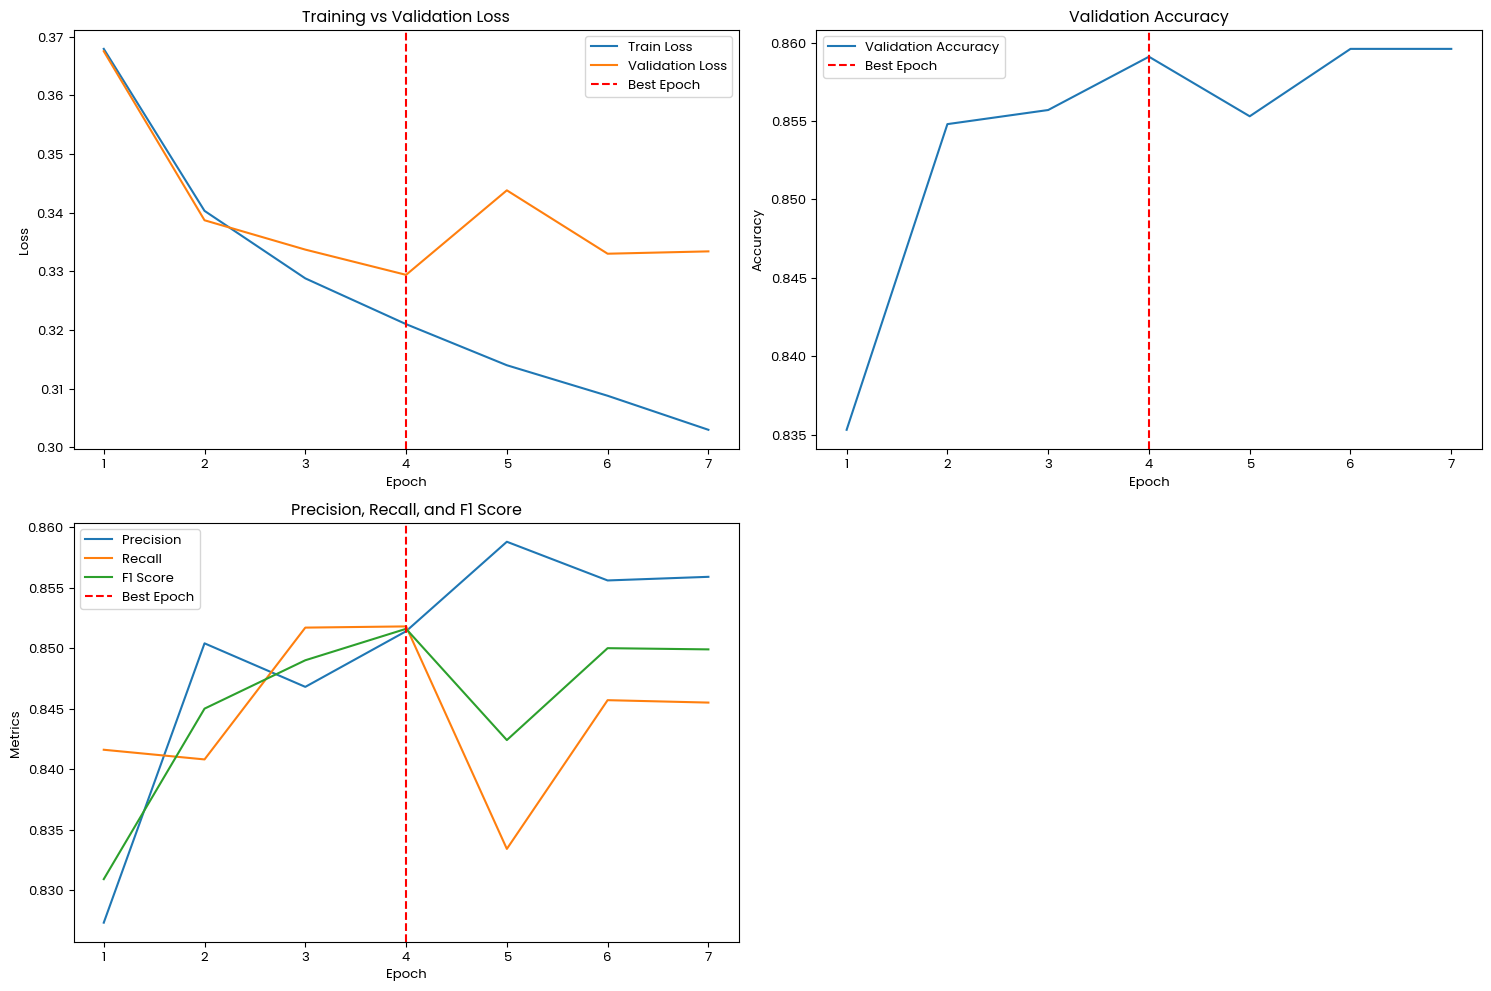

In [ ]:
# Use the function with your print_result data
plot_epoch_metrics(roberta_print_result, 4)

<font face="Poppins" size=2>Based on the uploaded charts and the metrics provided, here's an interpretation of the model's training performance up to Epoch 7:</font><br><br>

<font face="Poppins" size=2>1. **Training vs Validation Loss Chart**:</font><br>
<font face="Poppins" size=2>   - The training loss is steadily decreasing from Epoch 1 to Epoch 7, which is indicative of the model learning and improving on the training data.</font><br>
<font face="Poppins" size=2>   - The validation loss decreases and reaches its lowest point at Epoch 4, after which it slightly increases at Epoch 5, and then somewhat stabilizes. This is a typical behavior where the model starts to overfit slightly; however, the increase in validation loss is not drastic.</font><br>

<font face="Poppins" size=2>2. **Validation Accuracy Chart**:</font><br>
<font face="Poppins" size=2>   - The validation accuracy improves significantly up to Epoch 4, dips slightly at Epoch 5, and then plateaus. The highest accuracy is at Epoch 4, which coincides with the lowest validation loss.</font><br>

<font face="Poppins" size=2>3. **Precision, Recall, and F1 Score Chart**:</font><br>
<font face="Poppins" size=2>   - Precision, recall, and the F1 score all improve by Epoch 4. There's a dip in precision and F1 at Epoch 5, and recall drops slightly at Epoch 6.</font><br>
<font face="Poppins" size=2>   - Epoch 4 again stands out with the highest F1 score, which suggests a good balance between precision and recall.</font><br>

<font face="Poppins" size=2>From these observations, **Epoch 4** is determined to be the best epoch so far because it has the lowest validation loss, the highest validation accuracy, and the highest F1 score. The dip in validation loss and other metrics after Epoch 4 suggests that the model might start overfitting beyond this point. However, since the subsequent increases in validation loss are not large and the validation accuracy does not drop significantly, this is not a strong sign of overfitting yet. The model seems to still generalize reasonably well up to Epoch 7.</font><br>

<font face="Poppins" size=2>To confirm the trend of overfitting, one would need to look at the performance in the epochs following Epoch 7. If the validation loss starts increasing consistently while the training loss continues to decrease, and if the validation accuracy and F1 score start to decline, then overfitting would be more evident.</font>


# <font face="Poppins" size=2>Model building for text (BERT) 3 way</font><br>

In [ ]:
# Function to calculate metrics
def calculate_metrics(preds, labels):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return accuracy, precision, recall, f1


# Assuming 'train_bert_features_extraction', 'validate_bert_features_extraction', and 'test_bert_features_extraction'
# are your loaded feature arrays from BERT

# Convert features to PyTorch tensors
train_features_tensor = torch.tensor(train_bert_features_extraction).float().to(device)
validate_features_tensor = torch.tensor(validate_bert_features_extraction).float().to(device)
test_features_tensor = torch.tensor(test_bert_features_extraction).float().to(device)

# Extract 3_way labels
train_bert_labels_3_way = train_bert_merged_df['3_way_label'].values  # Assuming '3_way_label' is the column name for 3_way classification labels
validate_bert_labels_3_way = validate_bert_merged_df['3_way_label'].values
test_bert_labels_3_way = test_bert_merged_df['3_way_label'].values

# Convert 3_way classification labels to PyTorch tensors
train_labels_tensor = torch.tensor(train_bert_labels_3_way).long().to(device)
validate_labels_tensor = torch.tensor(validate_bert_labels_3_way).long().to(device)
test_labels_tensor = torch.tensor(test_bert_labels_3_way).long().to(device)

# Create TensorDatasets and DataLoaders
train_bert_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
validate_bert_dataset = TensorDataset(validate_features_tensor, validate_labels_tensor)
test_bert_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

batch_size = 16  #batch size
train_loader = DataLoader(train_bert_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_bert_dataset, batch_size=batch_size)
test_loader = DataLoader(test_bert_dataset, batch_size=batch_size)

# Define the neural network model for multi-label classification
class MultiLabelNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultiLabelNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Initialize the model
num_features = train_features_tensor.shape[1]  # Number of features in your dataset
num_classes = 3  # Adjust this based on your classification task (2, 3, or 6)
model = MultiLabelNN(num_features, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class; for multi-label, you might need BCEWithLogitsLoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop with early stopping
num_epochs = 20
best_val_loss = float('inf')
patience_counter = 0
patience = 3

bert_3_way_print_result = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for features, labels in tqdm_notebook(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    # Here, you would calculate train_accuracy, train_precision, train_recall, train_f1 if needed

    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for features, labels in validate_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(validate_loader)
    val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(np.array(all_val_preds), np.array(all_val_labels))

         # Save the model at the end of each epoch
    save_path = f"/content/bert_models/bert_3_way_label_appended_epoch_{epoch}"
    save_path_google_drive = f"/content/drive/MyDrive/multimodal_only_samples/bert_models/bert_3_way_label_appended_epoch_{epoch}"
    # Create the directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if not os.path.exists(save_path_google_drive):
        os.makedirs(save_path_google_drive)


    # Save the model's state dictionary
    torch.save(model.state_dict(), save_path + '/model_state_dict.pt')
    torch.save(model.state_dict(), save_path_google_drive + '/model_state_dict.pt')
    print(f"Model saved to {save_path_google_drive}")

    bert_3_way_print_result.append(f"Epoch {epoch + 1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}")
    print(f"Epoch {epoch + 1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
    bert_3_way_print_result.append(f"Epoch {epoch + 1}/{num_epochs} - Avg Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      patience_counter = 0
    else:
      patience_counter += 1
      if patience_counter >= patience:
          print("Early stopping triggered")
          break


# Print all results at the end
for result in bert_3_way_print_result:
    print(result)

Epoch 1/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_3_way_label_appended_epoch_0
Epoch 1/20 - Avg Train Loss: 0.3900, Avg Val Loss: 0.3670, Val Acc: 0.8461, Precision: 0.8736, Recall: 0.7474, F1: 0.7941


Epoch 2/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_3_way_label_appended_epoch_1
Epoch 2/20 - Avg Train Loss: 0.3573, Avg Val Loss: 0.3524, Val Acc: 0.8549, Precision: 0.8405, Recall: 0.8135, F1: 0.8262


Epoch 3/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_3_way_label_appended_epoch_2
Epoch 3/20 - Avg Train Loss: 0.3448, Avg Val Loss: 0.3501, Val Acc: 0.8574, Precision: 0.8392, Recall: 0.8253, F1: 0.8320


Epoch 4/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_3_way_label_appended_epoch_3
Epoch 4/20 - Avg Train Loss: 0.3352, Avg Val Loss: 0.3540, Val Acc: 0.8549, Precision: 0.8142, Recall: 0.8357, F1: 0.8244


Epoch 5/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_3_way_label_appended_epoch_4
Epoch 5/20 - Avg Train Loss: 0.3266, Avg Val Loss: 0.3534, Val Acc: 0.8572, Precision: 0.8317, Recall: 0.8241, F1: 0.8278


Epoch 6/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_3_way_label_appended_epoch_5
Epoch 6/20 - Avg Train Loss: 0.3194, Avg Val Loss: 0.3469, Val Acc: 0.8585, Precision: 0.8337, Recall: 0.8273, F1: 0.8305


Epoch 7/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_3_way_label_appended_epoch_6
Epoch 7/20 - Avg Train Loss: 0.3125, Avg Val Loss: 0.3469, Val Acc: 0.8583, Precision: 0.8490, Recall: 0.8120, F1: 0.8290


Epoch 8/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_3_way_label_appended_epoch_7
Epoch 8/20 - Avg Train Loss: 0.3064, Avg Val Loss: 0.3546, Val Acc: 0.8586, Precision: 0.8389, Recall: 0.8307, F1: 0.8345


Epoch 9/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_3_way_label_appended_epoch_8
Epoch 9/20 - Avg Train Loss: 0.3005, Avg Val Loss: 0.3516, Val Acc: 0.8580, Precision: 0.8281, Recall: 0.8290, F1: 0.8286
Early stopping triggered
Epoch 1/20 - Avg Train Loss: 0.3900
Epoch 1/20 - Avg Val Loss: 0.3670, Val Acc: 0.8461, Precision: 0.8736, Recall: 0.7474, F1: 0.7941
Epoch 2/20 - Avg Train Loss: 0.3573
Epoch 2/20 - Avg Val Loss: 0.3524, Val Acc: 0.8549, Precision: 0.8405, Recall: 0.8135, F1: 0.8262
Epoch 3/20 - Avg Train Loss: 0.3448
Epoch 3/20 - Avg Val Loss: 0.3501, Val Acc: 0.8574, Precision: 0.8392, Recall: 0.8253, F1: 0.8320
Epoch 4/20 - Avg Train Loss: 0.3352
Epoch 4/20 - Avg Val Loss: 0.3540, Val Acc: 0.8549, Precision: 0.8142, Recall: 0.8357, F1: 0.8244
Epoch 5/20 - Avg Train Loss: 0.3266
Epoch 5/20 - Avg Val Loss: 0.3534, Val Acc: 0.8572, Precision: 0.8317, Recall: 0.8241, F1: 0.8278
Epoch 6/20 - Avg Train Loss: 0.3194
Epoch 6/20 - Avg Val Loss: 0.3469, Val 

In [ ]:
bert_3_way_print_result

['Epoch 1/20 - Avg Train Loss: 0.3900',
 'Epoch 1/20 - Avg Val Loss: 0.3670, Val Acc: 0.8461, Precision: 0.8736, Recall: 0.7474, F1: 0.7941',
 'Epoch 2/20 - Avg Train Loss: 0.3573',
 'Epoch 2/20 - Avg Val Loss: 0.3524, Val Acc: 0.8549, Precision: 0.8405, Recall: 0.8135, F1: 0.8262',
 'Epoch 3/20 - Avg Train Loss: 0.3448',
 'Epoch 3/20 - Avg Val Loss: 0.3501, Val Acc: 0.8574, Precision: 0.8392, Recall: 0.8253, F1: 0.8320',
 'Epoch 4/20 - Avg Train Loss: 0.3352',
 'Epoch 4/20 - Avg Val Loss: 0.3540, Val Acc: 0.8549, Precision: 0.8142, Recall: 0.8357, F1: 0.8244',
 'Epoch 5/20 - Avg Train Loss: 0.3266',
 'Epoch 5/20 - Avg Val Loss: 0.3534, Val Acc: 0.8572, Precision: 0.8317, Recall: 0.8241, F1: 0.8278',
 'Epoch 6/20 - Avg Train Loss: 0.3194',
 'Epoch 6/20 - Avg Val Loss: 0.3469, Val Acc: 0.8585, Precision: 0.8337, Recall: 0.8273, F1: 0.8305',
 'Epoch 7/20 - Avg Train Loss: 0.3125',
 'Epoch 7/20 - Avg Val Loss: 0.3469, Val Acc: 0.8583, Precision: 0.8490, Recall: 0.8120, F1: 0.8290',
 'Epoc

In [61]:
metrics_data_bert_3_way  = [
    ['Metric', 'Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5', 'Epoch 6', 'Epoch 7', 'Epoch 8', 'Epoch 9'],
    ['Avg Train Loss', '0.3900', '0.3573', '0.3448', '0.3352', '0.3266', '0.3194', '0.3125', '0.3064', '0.3005'],
    ['Avg Val Loss', '0.3670', '0.3524', '0.3501', '0.3540', '0.3534', '0.3469', '0.3469', '0.3546', '0.3516'],
    ['Val Acc', '0.8461', '0.8549', '0.8574', '0.8549', '0.8572', '0.8585', '0.8583', '0.8586', '0.8580'],
    ['Precision', '0.8736', '0.8405', '0.8392', '0.8142', '0.8317', '0.8337', '0.8490', '0.8389', '0.8281'],
    ['Recall', '0.7474', '0.8135', '0.8253', '0.8357', '0.8241', '0.8273', '0.8120', '0.8307', '0.8290'],
    ['F1', '0.7941', '0.8262', '0.8320', '0.8244', '0.8278', '0.8305', '0.8290', '0.8345', '0.8286']
]


# Save the document
metrics_doc_path = '/content/Model_Training_Metrics_BERT_3_Way.docx'
create_metrics_document(metrics_data_bert_3_way, metrics_doc_path)

'/content/Model_Training_Metrics_BERT_3_Way.docx'

In [ ]:
# Open the file in write mode and write the result data
with open(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_bert_print_result_epoch_3_way.txt', 'w') as file:
    for line in bert_3_way_print_result:
        file.write(line + '\n')

In [ ]:
bert_3_way_print_result = []
# Open the file in read mode
with open(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_bert_print_result_epoch_3_way.txt', 'r') as file:
    for line in file:
        # Strip newline characters from the end of each line
        clean_line = line.strip()
        # Append the clean line to the list
        bert_3_way_print_result.append(clean_line)

In [ ]:
bert_3_way_print_result

['Epoch 1/20 - Avg Train Loss: 0.3900',
 'Epoch 1/20 - Avg Val Loss: 0.3670, Val Acc: 0.8461, Precision: 0.8736, Recall: 0.7474, F1: 0.7941',
 'Epoch 2/20 - Avg Train Loss: 0.3573',
 'Epoch 2/20 - Avg Val Loss: 0.3524, Val Acc: 0.8549, Precision: 0.8405, Recall: 0.8135, F1: 0.8262',
 'Epoch 3/20 - Avg Train Loss: 0.3448',
 'Epoch 3/20 - Avg Val Loss: 0.3501, Val Acc: 0.8574, Precision: 0.8392, Recall: 0.8253, F1: 0.8320',
 'Epoch 4/20 - Avg Train Loss: 0.3352',
 'Epoch 4/20 - Avg Val Loss: 0.3540, Val Acc: 0.8549, Precision: 0.8142, Recall: 0.8357, F1: 0.8244',
 'Epoch 5/20 - Avg Train Loss: 0.3266',
 'Epoch 5/20 - Avg Val Loss: 0.3534, Val Acc: 0.8572, Precision: 0.8317, Recall: 0.8241, F1: 0.8278',
 'Epoch 6/20 - Avg Train Loss: 0.3194',
 'Epoch 6/20 - Avg Val Loss: 0.3469, Val Acc: 0.8585, Precision: 0.8337, Recall: 0.8273, F1: 0.8305',
 'Epoch 7/20 - Avg Train Loss: 0.3125',
 'Epoch 7/20 - Avg Val Loss: 0.3469, Val Acc: 0.8583, Precision: 0.8490, Recall: 0.8120, F1: 0.8290',
 'Epoc

<font face="Poppins" size=2>To find the best epoch and check for overfitting, we will review the trends in training and validation loss, as well as other performance metrics such as validation accuracy, precision, recall, and F1 score.</font><br><br>

<font face="Poppins" size=2>1. <b>Lowest Validation Loss</b>: The lowest validation loss is reported in <b>Epoch 3</b> and <b>Epoch 7</b> with a value of <b>0.3469</b>.</font><br>

<font face="Poppins" size=2>2. <b>Highest Validation Accuracy</b>: The highest validation accuracy is in <b>Epoch 8</b> with a value of <b>0.8586</b>.</font><br>

<font face="Poppins" size=2>3. <b>Best Balance of Metrics</b>: We generally look for a balance of precision, recall, and F1 score alongside high validation accuracy and low validation loss. The F1 score is a harmonic mean of precision and recall, making it a crucial metric for balance.</font><br>

<font face="Poppins" size=2>Here, <b>Epoch 6</b> has a slightly better F1 score than Epoch 3 and the same validation loss, and the validation accuracy is higher as well. Therefore, <b>Epoch 6</b> emerges as the best candidate for the best epoch with an F1 score of <b>0.8305</b>, validation accuracy of <b>0.8585</b>, and a validation loss of <b>0.3469</b>.</font><br>

<font face="Poppins" size=2>Regarding overfitting:</font><br>

<font face="Poppins" size=2>- <b>Training Loss</b>: The training loss is decreasing consistently across epochs, which is expected during the learning process.</font><br>

<font face="Poppins" size=2>- <b>Validation Loss</b>: The validation loss does not show a consistent increase after Epoch 6; it remains the same at Epoch 7 and increases slightly at Epoch 8. This is not a definitive sign of overfitting yet.</font><br>

<font face="Poppins" size=2>- <b>Validation Metrics</b>: The validation accuracy remains fairly stable across epochs, and the precision, recall, and F1 score do not show a consistent downward trend after the best epoch.</font><br>

<font face="Poppins" size=2>Considering these points, there is no strong evidence of overfitting up to Epoch 9. The slight fluctuations in validation loss and other metrics could be attributed to the variability in the validation dataset rather than the model's inability to generalize. To be certain of overfitting, one would expect to see a consistent and significant increase in validation loss accompanied by a decrease in other performance metrics, which is not observed here.</font><br>

<font face="Poppins" size=2>Thus, <b>Epoch 6</b> can be considered the best epoch based on the provided data, and no significant overfitting is detected up to Epoch 9. It would still be prudent to observe the trends in the remaining epochs to confirm these findings.</font>


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

def evaluate_model_3_way(model, data_loader, device):
    all_predictions = []
    all_labels = []

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)

            outputs = model(features)
            _, predicted = torch.max(outputs, dim=1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays for metric calculation
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    # Update 'target_names' with your actual class names
    print(classification_report(all_labels, all_predictions, target_names=['Completely True', 'Fake but contains text that is true', 'Fake with false text']))

In [ ]:
evaluate_model_3_way(model, test_loader, device)

Accuracy: 0.8568
Precision: 0.8567
Recall: 0.8568
F1 Score: 0.8567
                                     precision    recall  f1-score   support

                    Completely True       0.83      0.83      0.83     22263
Fake but contains text that is true       0.80      0.79      0.79      1458
               Fake with false text       0.88      0.88      0.88     33272

                           accuracy                           0.86     56993
                          macro avg       0.84      0.83      0.83     56993
                       weighted avg       0.86      0.86      0.86     56993



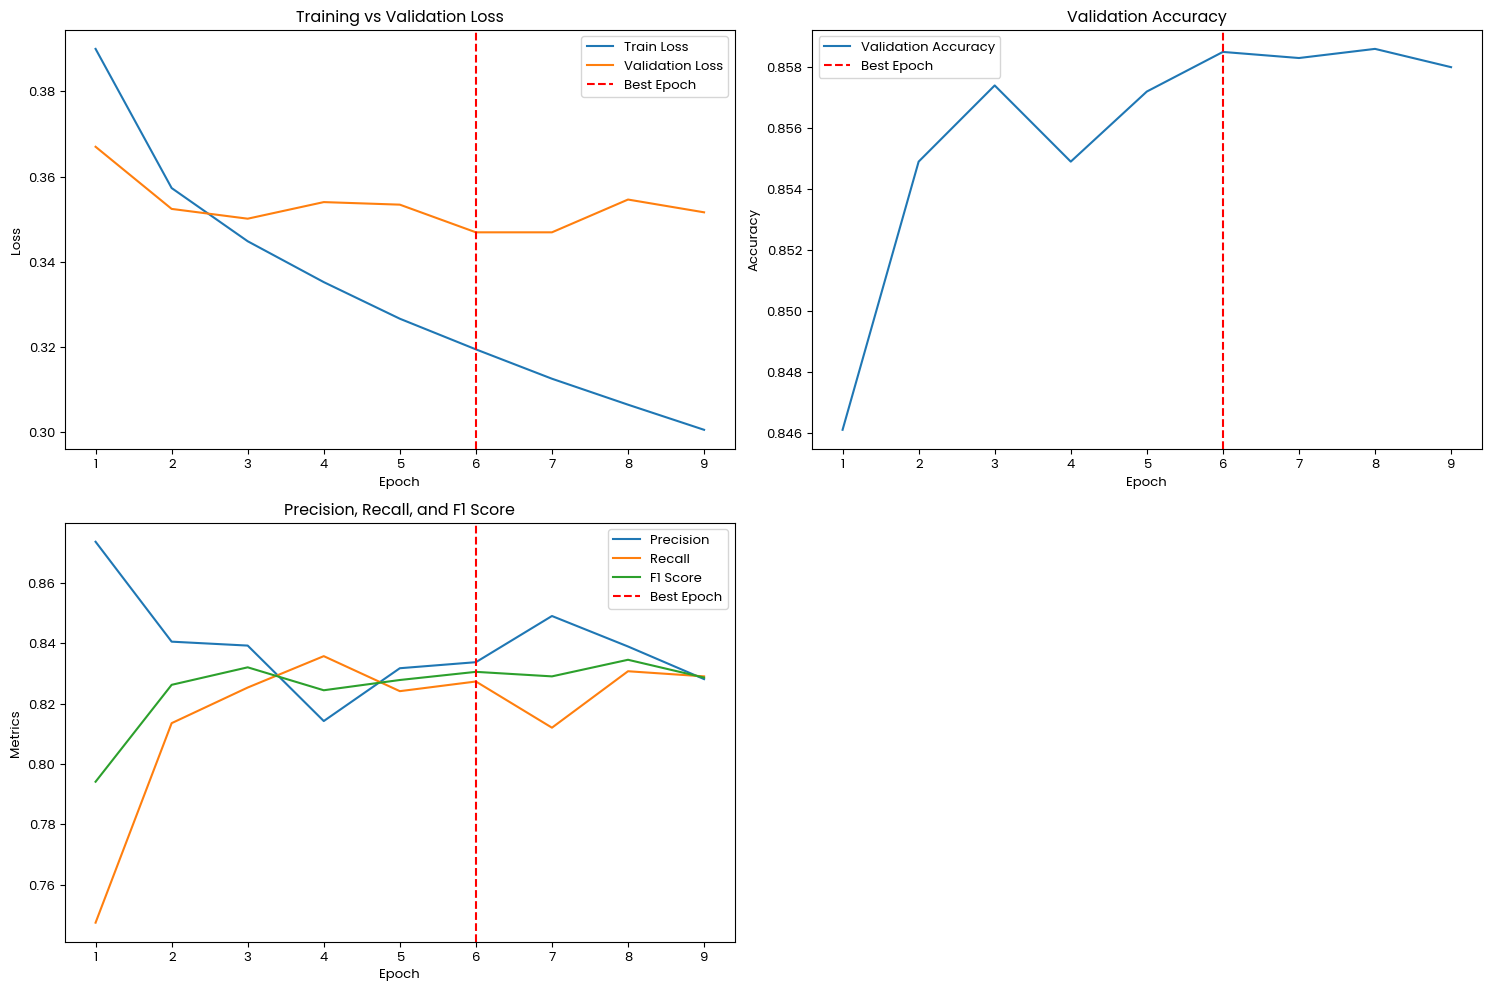

In [ ]:
# Use the function with your print_result data
plot_epoch_metrics(bert_3_way_print_result, 6)

<font face="Poppins" size="2">Based on the provided charts and the earlier mentioned metrics, here's an interpretation of each graph:</font><br>

<font face="Poppins" size="2">1. <b>Training vs Validation Loss Chart</b>:
   - The training loss is on a downward trend, which is normal and indicates the model is learning from the training data.
   - The validation loss initially decreases but starts to increase slightly after Epoch 6, which is marked as the best epoch with the red dashed line. This could be an early sign of overfitting.</font><br>

<font face="Poppins" size="2">2. <b>Validation Accuracy Chart</b>:
   - The validation accuracy improves up to Epoch 6, after which there is a slight drop and then it stabilizes. The peak at Epoch 6 matches the lowest validation loss, which corroborates the selection of this epoch as the best one.</font><br>

<font face="Poppins" size="2">3. <b>Precision, Recall, and F1 Score Chart</b>:
   - There are fluctuations in precision, recall, and F1 scores. However, these metrics peak or near-peak around Epoch 6, which is consistent with the selection of this epoch as the best for general model performance.</font><br>

<font face="Poppins" size="2">The best epoch, as indicated by the red dashed line, appears to be Epoch 6. This epoch has the lowest validation loss, one of the highest validation accuracy measurements, and high precision, recall, and F1 scores.</font><br>

<font face="Poppins" size="2">In terms of overfitting:
- There is a minor increase in validation loss after Epoch 6, which could be an indicator of overfitting. However, the increase is not significant, and the validation accuracy does not decline sharply, which would be a stronger sign of overfitting.
- The performance metrics (precision, recall, and F1 score) do not show a significant drop after Epoch 6, which suggests that the model still retains its generalization capabilities up to Epoch 9.</font><br>

<font face="Poppins" size="2">In summary, based on the charts, Epoch 6 seems to be the best epoch, and there is a slight indication of overfitting after this point. However, the signs are not strong enough to conclusively determine overfitting without further data from subsequent epochs. It would be prudent to observe the trends in the metrics for epochs beyond 9 to confirm if overfitting becomes more pronounced.</font>


# <font face="Poppins" size=2>Model building for text (T5) 3 way</font><br>

In [ ]:
# Function to calculate metrics
def calculate_metrics(preds, labels):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return accuracy, precision, recall, f1


# Assuming 'train_t5_features_extraction', 'validate_t5_features_extraction', and 'test_t5_features_extraction'
# are your loaded feature arrays from BERT

# Convert features to PyTorch tensors
train_features_tensor = torch.tensor(train_t5_features_extraction).float().to(device)
validate_features_tensor = torch.tensor(validate_t5_features_extraction).float().to(device)
test_features_tensor = torch.tensor(test_t5_features_extraction).float().to(device)

# Extract 3_way labels
train_t5_labels_3_way = train_t5_merged_df['3_way_label'].values  # Assuming '3_way_label' is the column name for 3_way classification labels
validate_t5_labels_3_way = validate_t5_merged_df['3_way_label'].values
test_t5_labels_3_way = test_t5_merged_df['3_way_label'].values

# Convert 3_way classification labels to PyTorch tensors
train_labels_tensor = torch.tensor(train_t5_labels_3_way).long().to(device)
validate_labels_tensor = torch.tensor(validate_t5_labels_3_way).long().to(device)
test_labels_tensor = torch.tensor(test_t5_labels_3_way).long().to(device)

# Create TensorDatasets and DataLoaders
train_t5_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
validate_t5_dataset = TensorDataset(validate_features_tensor, validate_labels_tensor)
test_t5_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

batch_size = 16  #batch size
train_loader = DataLoader(train_t5_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_t5_dataset, batch_size=batch_size)
test_loader = DataLoader(test_t5_dataset, batch_size=batch_size)

# Define the neural network model for multi-label classification
class T5Classifier(nn.Module):
    def __init__(self, feature_vector_size, num_classes):
        super(T5Classifier, self).__init__()
        # The first linear layer matches the feature vector size of 512
        self.fc1 = nn.Linear(feature_vector_size, 256)  # Reduce size to 256
        self.relu = nn.ReLU()
        # Second linear layer
        self.fc2 = nn.Linear(256, 128)  # Further reduce size to 128
        # Third linear layer, leading to the final output
        self.fc3 = nn.Linear(128, num_classes)  # num_classes is 2 for 3_way classification

    def forward(self, x):
        x = self.fc1(x)  # Input pass through the first layer
        x = self.relu(x)  # Apply ReLU activation function
        x = self.fc2(x)  # Pass through the second layer
        x = self.relu(x)  # Apply ReLU activation function
        x = self.fc3(x)  # Pass through the final layer to get the output
        return x

# Initialize the model
num_features = train_features_tensor.shape[1]  # Number of features in your dataset
num_classes = 3  # Adjust this based on your classification task (2, 3, or 6)
model = MultiLabelNN(num_features, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class; for multi-label, you might need BCEWithLogitsLoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop with early stopping
num_epochs = 20
best_val_loss = float('inf')
patience_counter = 0
patience = 3

t5_3_way_print_result = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for features, labels in tqdm_notebook(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    # Here, you would calculate train_accuracy, train_precision, train_recall, train_f1 if needed

    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for features, labels in validate_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(validate_loader)
    val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(np.array(all_val_preds), np.array(all_val_labels))

         # Save the model at the end of each epoch
    save_path = f"/content/t5_models/t5_3_way_label_appended_epoch_{epoch}"
    save_path_google_drive = f"/content/drive/MyDrive/multimodal_only_samples/t5_models/t5_3_way_label_appended_epoch_{epoch}"
    # Create the directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if not os.path.exists(save_path_google_drive):
        os.makedirs(save_path_google_drive)


    # Save the model's state dictionary
    torch.save(model.state_dict(), save_path + '/model_state_dict.pt')
    torch.save(model.state_dict(), save_path_google_drive + '/model_state_dict.pt')
    print(f"Model saved to {save_path_google_drive}")

    t5_3_way_print_result.append(f"Epoch {epoch + 1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}")
    print(f"Epoch {epoch + 1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
    t5_3_way_print_result.append(f"Epoch {epoch + 1}/{num_epochs} - Avg Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      patience_counter = 0
    else:
      patience_counter += 1
      if patience_counter >= patience:
          print("Early stopping triggered")
          break


# Print all results at the end
for result in t5_3_way_print_result:
    print(result)

Epoch 1/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_3_way_label_appended_epoch_0
Epoch 1/20 - Avg Train Loss: 0.4535, Avg Val Loss: 0.4206, Val Acc: 0.8195, Precision: 0.8277, Recall: 0.7361, F1: 0.7728


Epoch 2/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_3_way_label_appended_epoch_1
Epoch 2/20 - Avg Train Loss: 0.4170, Avg Val Loss: 0.4110, Val Acc: 0.8231, Precision: 0.8068, Recall: 0.7572, F1: 0.7792


Epoch 3/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_3_way_label_appended_epoch_2
Epoch 3/20 - Avg Train Loss: 0.4051, Avg Val Loss: 0.3993, Val Acc: 0.8299, Precision: 0.8251, Recall: 0.7576, F1: 0.7862


Epoch 4/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_3_way_label_appended_epoch_3
Epoch 4/20 - Avg Train Loss: 0.3969, Avg Val Loss: 0.3981, Val Acc: 0.8318, Precision: 0.8368, Recall: 0.7511, F1: 0.7861


Epoch 5/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_3_way_label_appended_epoch_4
Epoch 5/20 - Avg Train Loss: 0.3909, Avg Val Loss: 0.3950, Val Acc: 0.8331, Precision: 0.7932, Recall: 0.7887, F1: 0.7908


Epoch 6/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_3_way_label_appended_epoch_5
Epoch 6/20 - Avg Train Loss: 0.3859, Avg Val Loss: 0.3974, Val Acc: 0.8331, Precision: 0.8562, Recall: 0.7412, F1: 0.7828


Epoch 7/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_3_way_label_appended_epoch_6
Epoch 7/20 - Avg Train Loss: 0.3819, Avg Val Loss: 0.3995, Val Acc: 0.8290, Precision: 0.8252, Recall: 0.7626, F1: 0.7892


Epoch 8/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_3_way_label_appended_epoch_7
Epoch 8/20 - Avg Train Loss: 0.3782, Avg Val Loss: 0.3943, Val Acc: 0.8340, Precision: 0.8347, Recall: 0.7574, F1: 0.7898


Epoch 9/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_3_way_label_appended_epoch_8
Epoch 9/20 - Avg Train Loss: 0.3747, Avg Val Loss: 0.3963, Val Acc: 0.8332, Precision: 0.7869, Recall: 0.7967, F1: 0.7916


Epoch 10/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_3_way_label_appended_epoch_9
Epoch 10/20 - Avg Train Loss: 0.3717, Avg Val Loss: 0.4016, Val Acc: 0.8313, Precision: 0.8518, Recall: 0.7430, F1: 0.7822


Epoch 11/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_3_way_label_appended_epoch_10
Epoch 11/20 - Avg Train Loss: 0.3691, Avg Val Loss: 0.3901, Val Acc: 0.8378, Precision: 0.8425, Recall: 0.7648, F1: 0.7968


Epoch 12/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_3_way_label_appended_epoch_11
Epoch 12/20 - Avg Train Loss: 0.3666, Avg Val Loss: 0.3916, Val Acc: 0.8357, Precision: 0.8095, Recall: 0.7872, F1: 0.7975


Epoch 13/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_3_way_label_appended_epoch_12
Epoch 13/20 - Avg Train Loss: 0.3639, Avg Val Loss: 0.4035, Val Acc: 0.8351, Precision: 0.8209, Recall: 0.7891, F1: 0.8032


Epoch 14/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_3_way_label_appended_epoch_13
Epoch 14/20 - Avg Train Loss: 0.3613, Avg Val Loss: 0.4115, Val Acc: 0.8301, Precision: 0.8105, Recall: 0.7741, F1: 0.7901
Early stopping triggered
Epoch 1/20 - Avg Train Loss: 0.4535
Epoch 1/20 - Avg Val Loss: 0.4206, Val Acc: 0.8195, Precision: 0.8277, Recall: 0.7361, F1: 0.7728
Epoch 2/20 - Avg Train Loss: 0.4170
Epoch 2/20 - Avg Val Loss: 0.4110, Val Acc: 0.8231, Precision: 0.8068, Recall: 0.7572, F1: 0.7792
Epoch 3/20 - Avg Train Loss: 0.4051
Epoch 3/20 - Avg Val Loss: 0.3993, Val Acc: 0.8299, Precision: 0.8251, Recall: 0.7576, F1: 0.7862
Epoch 4/20 - Avg Train Loss: 0.3969
Epoch 4/20 - Avg Val Loss: 0.3981, Val Acc: 0.8318, Precision: 0.8368, Recall: 0.7511, F1: 0.7861
Epoch 5/20 - Avg Train Loss: 0.3909
Epoch 5/20 - Avg Val Loss: 0.3950, Val Acc: 0.8331, Precision: 0.7932, Recall: 0.7887, F1: 0.7908
Epoch 6/20 - Avg Train Loss: 0.3859
Epoch 6/20 - Avg Val Loss: 0.3974, Val Ac

In [ ]:
t5_3_way_print_result

['Epoch 1/20 - Avg Train Loss: 0.4535',
 'Epoch 1/20 - Avg Val Loss: 0.4206, Val Acc: 0.8195, Precision: 0.8277, Recall: 0.7361, F1: 0.7728',
 'Epoch 2/20 - Avg Train Loss: 0.4170',
 'Epoch 2/20 - Avg Val Loss: 0.4110, Val Acc: 0.8231, Precision: 0.8068, Recall: 0.7572, F1: 0.7792',
 'Epoch 3/20 - Avg Train Loss: 0.4051',
 'Epoch 3/20 - Avg Val Loss: 0.3993, Val Acc: 0.8299, Precision: 0.8251, Recall: 0.7576, F1: 0.7862',
 'Epoch 4/20 - Avg Train Loss: 0.3969',
 'Epoch 4/20 - Avg Val Loss: 0.3981, Val Acc: 0.8318, Precision: 0.8368, Recall: 0.7511, F1: 0.7861',
 'Epoch 5/20 - Avg Train Loss: 0.3909',
 'Epoch 5/20 - Avg Val Loss: 0.3950, Val Acc: 0.8331, Precision: 0.7932, Recall: 0.7887, F1: 0.7908',
 'Epoch 6/20 - Avg Train Loss: 0.3859',
 'Epoch 6/20 - Avg Val Loss: 0.3974, Val Acc: 0.8331, Precision: 0.8562, Recall: 0.7412, F1: 0.7828',
 'Epoch 7/20 - Avg Train Loss: 0.3819',
 'Epoch 7/20 - Avg Val Loss: 0.3995, Val Acc: 0.8290, Precision: 0.8252, Recall: 0.7626, F1: 0.7892',
 'Epoc

In [62]:
metrics_data_t5_3_way  = [
    ['Metric', 'Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5', 'Epoch 6', 'Epoch 7', 'Epoch 8', 'Epoch 9', 'Epoch 10', 'Epoch 11', 'Epoch 12', 'Epoch 13', 'Epoch 14'],
    ['Avg Train Loss', '0.4535', '0.4170', '0.4051', '0.3969', '0.3909', '0.3859', '0.3819', '0.3782', '0.3747', '0.3717', '0.3691', '0.3666', '0.3639', '0.3613'],
    ['Avg Val Loss', '0.4206', '0.4110', '0.3993', '0.3981', '0.3950', '0.3974', '0.3995', '0.3943', '0.3963', '0.4016', '0.3901', '0.3916', '0.4035', '0.4115'],
    ['Val Acc', '0.8195', '0.8231', '0.8299', '0.8318', '0.8331', '0.8331', '0.8290', '0.8340', '0.8332', '0.8313', '0.8378', '0.8357', '0.8351', '0.8301'],
    ['Precision', '0.8277', '0.8068', '0.8251', '0.8368', '0.7932', '0.8562', '0.8252', '0.8347', '0.7869', '0.8518', '0.8425', '0.8095', '0.8209', '0.8105'],
    ['Recall', '0.7361', '0.7572', '0.7576', '0.7511', '0.7887', '0.7412', '0.7626', '0.7574', '0.7967', '0.7430', '0.7648', '0.7872', '0.7891', '0.7741'],
    ['F1', '0.7728', '0.7792', '0.7862', '0.7861', '0.7908', '0.7828', '0.7892', '0.7898', '0.7916', '0.7822', '0.7968', '0.7975', '0.8032', '0.7901']
]


# Save the document
metrics_doc_path = '/content/Model_Training_Metrics_T5_3_Way.docx'
create_metrics_document(metrics_data_t5_3_way, metrics_doc_path)

'/content/Model_Training_Metrics_T5_3_Way.docx'

In [ ]:
# Open the file in write mode and write the result data
with open(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_t5_print_result_epoch_3_way.txt', 'w') as file:
    for line in t5_3_way_print_result:
        file.write(line + '\n')

In [ ]:
t5_3_way_print_result = []
# Open the file in read mode
with open(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_t5_print_result_epoch_3_way.txt', 'r') as file:
    for line in file:
        # Strip newline characters from the end of each line
        clean_line = line.strip()
        # Append the clean line to the list
        t5_3_way_print_result.append(clean_line)

In [ ]:
t5_3_way_print_result

['Epoch 1/20 - Avg Train Loss: 0.4535',
 'Epoch 1/20 - Avg Val Loss: 0.4206, Val Acc: 0.8195, Precision: 0.8277, Recall: 0.7361, F1: 0.7728',
 'Epoch 2/20 - Avg Train Loss: 0.4170',
 'Epoch 2/20 - Avg Val Loss: 0.4110, Val Acc: 0.8231, Precision: 0.8068, Recall: 0.7572, F1: 0.7792',
 'Epoch 3/20 - Avg Train Loss: 0.4051',
 'Epoch 3/20 - Avg Val Loss: 0.3993, Val Acc: 0.8299, Precision: 0.8251, Recall: 0.7576, F1: 0.7862',
 'Epoch 4/20 - Avg Train Loss: 0.3969',
 'Epoch 4/20 - Avg Val Loss: 0.3981, Val Acc: 0.8318, Precision: 0.8368, Recall: 0.7511, F1: 0.7861',
 'Epoch 5/20 - Avg Train Loss: 0.3909',
 'Epoch 5/20 - Avg Val Loss: 0.3950, Val Acc: 0.8331, Precision: 0.7932, Recall: 0.7887, F1: 0.7908',
 'Epoch 6/20 - Avg Train Loss: 0.3859',
 'Epoch 6/20 - Avg Val Loss: 0.3974, Val Acc: 0.8331, Precision: 0.8562, Recall: 0.7412, F1: 0.7828',
 'Epoch 7/20 - Avg Train Loss: 0.3819',
 'Epoch 7/20 - Avg Val Loss: 0.3995, Val Acc: 0.8290, Precision: 0.8252, Recall: 0.7626, F1: 0.7892',
 'Epoc

<font face="Poppins" size="2">To determine the best epoch and check for overfitting, let's look at the trends in the training and validation losses as well as the validation accuracy and other metrics like precision, recall, and F1 score.</font><br>

<font face="Poppins" size="2">1. <b>Lowest Validation Loss</b>: The lowest validation loss occurs in <b>Epoch 11</b> with a value of <b>0.3901</b>.</font><br>

<font face="Poppins" size="2">2. <b>Highest Validation Accuracy</b>: The highest validation accuracy is also in <b>Epoch 11</b> with a value of <b>0.8378</b>.</font><br>

<font face="Poppins" size="2">3. <b>Best Balance of Metrics</b>: In terms of precision, recall, and F1 score, <b>Epoch 11</b> again seems to provide the best balance with an F1 score of <b>0.7968</b>.</font><br>

<font face="Poppins" size="2">From these data points, <b>Epoch 11</b> appears to be the best epoch as it has the lowest validation loss and the highest validation accuracy and F1 score, indicating a good balance between all performance metrics.</font><br>

<font face="Poppins" size="2">Regarding overfitting:
- <b>Training Loss Trend</b>: The training loss is consistently decreasing, which is good as it shows the model is learning and improving its performance on the training set.
- <b>Validation Loss Trend</b>: The validation loss decreases until Epoch 11, which is a good sign. However, after Epoch 11, the validation loss increases, which could be an indicator of overfitting.
- <b>Validation Metrics Trend</b>: The validation accuracy peaks at Epoch 11 and then decreases slightly. Similarly, the F1 score is highest at Epoch 11 and decreases afterward. These trends suggest the model may not be generalizing as well beyond Epoch 11, which could be a sign of overfitting.</font><br>

<font face="Poppins" size="2">Given these observations, <b>Epoch 11</b> is the best epoch based on the data provided. There is a potential for overfitting after Epoch 11 as indicated by the rising validation loss and declining validation accuracy and F1 score. To confirm overfitting, one would typically look for these trends to continue in the subsequent epochs. If the training loss continues to drop while the validation loss grows, and if the validation metrics continue to worsen, it would confirm the presence of overfitting.</font>


In [ ]:
evaluate_model_3_way(model, test_loader, device)

Accuracy: 0.8280
Precision: 0.8278
Recall: 0.8280
F1 Score: 0.8261
                                     precision    recall  f1-score   support

                    Completely True       0.83      0.74      0.78     22263
Fake but contains text that is true       0.78      0.71      0.74      1458
               Fake with false text       0.83      0.90      0.86     33272

                           accuracy                           0.83     56993
                          macro avg       0.81      0.78      0.79     56993
                       weighted avg       0.83      0.83      0.83     56993



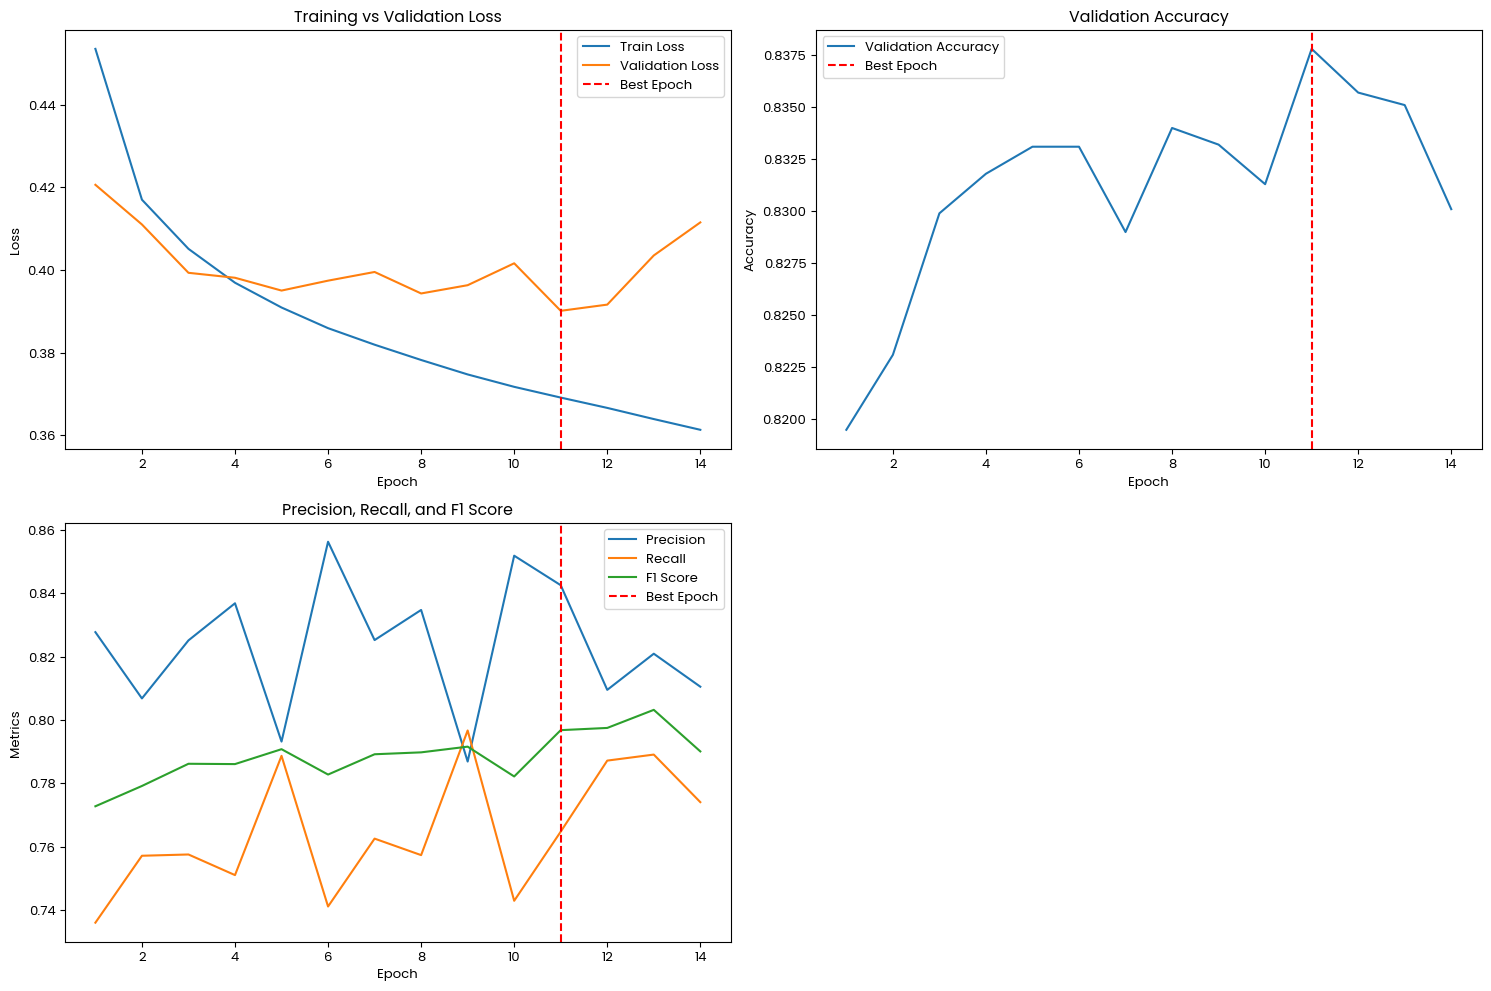

In [ ]:
# Use the function with your print_result data
plot_epoch_metrics(t5_3_way_print_result, 11)

<font face="Poppins" size=2>Based on the uploaded charts and the earlier mentioned metrics, here's an interpretation for determining the best epoch and checking for overfitting:</font><br>
<font face="Poppins" size=2>1. **Training vs Validation Loss Chart**:</font><br>
<font face="Poppins" size=2>- The training loss decreases consistently, which is a good indication that the model is learning from the training data.</font><br>
<font face="Poppins" size=2>- The validation loss decreases until it reaches a minimum at Epoch 11, after which it begins to rise. The best epoch, as indicated by the red dashed line, is Epoch 11.</font><br>
<font face="Poppins" size=2>2. **Validation Accuracy Chart**:</font><br>
<font face="Poppins" size=2>- The validation accuracy generally increases over time, with some fluctuations, and peaks at Epoch 11, which aligns with the lowest validation loss.</font><br>
<font face="Poppins" size=2>3. **Precision, Recall, and F1 Score Chart**:</font><br>
<font face="Poppins" size=2>- The precision, recall, and F1 score have some variability across epochs. However, the F1 score, which is a measure of the test's accuracy, is at one of its higher points at Epoch 11. Precision and recall also seem to be relatively high at this point.</font><br>
<font face="Poppins" size=2>Epoch 11 is marked as the best epoch across all three charts. It is where the validation loss is at its lowest, the validation accuracy is at its highest, and the F1 score is strong. This convergence of optimal points across different metrics makes it the best epoch for the model so far.</font><br>
<font face="Poppins" size=2>In terms of overfitting:</font><br>
<font face="Poppins" size=2>- After Epoch 11, the validation loss starts to increase, which is a classic sign of overfitting. This suggests that the model is beginning to fit too closely to the training data and is losing its generalization on the validation data.</font><br>
<font face="Poppins" size=2>- The validation accuracy also begins to decline slightly after Epoch 11, which supports the indication of overfitting seen in the validation loss chart.</font><br>
<font face="Poppins" size=2>- The precision, recall, and F1 score metrics do not show a clear trend after Epoch 11, which might mean the model still retains some of its predictive capabilities. However, since these are also fluctuating, it's not a definitive sign against overfitting.</font><br>
<font face="Poppins" size=2>In summary, Epoch 11 seems to be the best epoch before the model shows signs of overfitting. The rise in validation loss and drop in validation accuracy post-Epoch 11 suggest that the model's ability to generalize may be degrading from that point onwards. It would be prudent to carefully observe the model's performance in subsequent epochs to confirm this trend and to consider implementing strategies to combat overfitting if it persists.</font><br>


# <font face="Poppins" size=2>Model building for text (Roberta) 3 way</font><br>

In [ ]:
# Function to calculate metrics
def calculate_metrics(preds, labels):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return accuracy, precision, recall, f1


# Assuming 'train_roberta_features_extraction', 'validate_roberta_features_extraction', and 'test_roberta_features_extraction'
# are your loaded feature arrays from BERT

# Convert features to PyTorch tensors
train_features_tensor = torch.tensor(train_roberta_features_extraction).float().to(device)
validate_features_tensor = torch.tensor(validate_roberta_features_extraction).float().to(device)
test_features_tensor = torch.tensor(test_roberta_features_extraction).float().to(device)

# Extract 3_way labels
train_roberta_labels_3_way = train_roberta_merged_df['3_way_label'].values  # Assuming '3_way_label' is the column name for 3_way classification labels
validate_roberta_labels_3_way = validate_roberta_merged_df['3_way_label'].values
test_roberta_labels_3_way = test_roberta_merged_df['3_way_label'].values

# Convert 3_way classification labels to PyTorch tensors
train_labels_tensor = torch.tensor(train_roberta_labels_3_way).long().to(device)
validate_labels_tensor = torch.tensor(validate_roberta_labels_3_way).long().to(device)
test_labels_tensor = torch.tensor(test_roberta_labels_3_way).long().to(device)

# Create TensorDatasets and DataLoaders
train_roberta_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
validate_roberta_dataset = TensorDataset(validate_features_tensor, validate_labels_tensor)
test_roberta_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

batch_size = 16  #batch size
train_loader = DataLoader(train_roberta_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_roberta_dataset, batch_size=batch_size)
test_loader = DataLoader(test_roberta_dataset, batch_size=batch_size)

# Define the neural network model for multi-label classification
class MultiLabelNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultiLabelNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


# Initialize the model
num_features = train_features_tensor.shape[1]  # Number of features in your dataset
num_classes = 3  # Adjust this based on your classification task (2, 3, or 6)
model = MultiLabelNN(num_features, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class; for multi-label, you might need BCEWithLogitsLoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop with early stopping
num_epochs = 20
best_val_loss = float('inf')
patience_counter = 0
patience = 3

roberta_3_way_print_result = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for features, labels in tqdm_notebook(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    # Here, you would calculate train_accuracy, train_precision, train_recall, train_f1 if needed

    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for features, labels in validate_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(validate_loader)
    val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(np.array(all_val_preds), np.array(all_val_labels))

         # Save the model at the end of each epoch
    save_path = f"/content/roberta_models/roberta_3_way_label_appended_epoch_{epoch}"
    save_path_google_drive = f"/content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_3_way_label_appended_epoch_{epoch}"
    # Create the directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if not os.path.exists(save_path_google_drive):
        os.makedirs(save_path_google_drive)


    # Save the model's state dictionary
    torch.save(model.state_dict(), save_path + '/model_state_dict.pt')
    torch.save(model.state_dict(), save_path_google_drive + '/model_state_dict.pt')
    print(f"Model saved to {save_path_google_drive}")

    roberta_3_way_print_result.append(f"Epoch {epoch + 1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}")
    print(f"Epoch {epoch + 1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
    roberta_3_way_print_result.append(f"Epoch {epoch + 1}/{num_epochs} - Avg Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      patience_counter = 0
    else:
      patience_counter += 1
      if patience_counter >= patience:
          print("Early stopping triggered")
          break


# Print all results at the end
for result in roberta_3_way_print_result:
    print(result)

Epoch 1/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_3_way_label_appended_epoch_0
Epoch 1/20 - Avg Train Loss: 0.4063, Avg Val Loss: 0.3802, Val Acc: 0.8394, Precision: 0.8419, Recall: 0.7563, F1: 0.7907


Epoch 2/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_3_way_label_appended_epoch_1
Epoch 2/20 - Avg Train Loss: 0.3727, Avg Val Loss: 0.3706, Val Acc: 0.8449, Precision: 0.8379, Recall: 0.7766, F1: 0.8029


Epoch 3/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_3_way_label_appended_epoch_2
Epoch 3/20 - Avg Train Loss: 0.3597, Avg Val Loss: 0.3624, Val Acc: 0.8486, Precision: 0.8340, Recall: 0.7915, F1: 0.8107


Epoch 4/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_3_way_label_appended_epoch_3
Epoch 4/20 - Avg Train Loss: 0.3505, Avg Val Loss: 0.3666, Val Acc: 0.8480, Precision: 0.8436, Recall: 0.7873, F1: 0.8121


Epoch 5/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_3_way_label_appended_epoch_4
Epoch 5/20 - Avg Train Loss: 0.3427, Avg Val Loss: 0.3630, Val Acc: 0.8515, Precision: 0.8040, Recall: 0.8198, F1: 0.8111


Epoch 6/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_3_way_label_appended_epoch_5
Epoch 6/20 - Avg Train Loss: 0.3360, Avg Val Loss: 0.3630, Val Acc: 0.8524, Precision: 0.8469, Recall: 0.7915, F1: 0.8160
Early stopping triggered
Epoch 1/20 - Avg Train Loss: 0.4063
Epoch 1/20 - Avg Val Loss: 0.3802, Val Acc: 0.8394, Precision: 0.8419, Recall: 0.7563, F1: 0.7907
Epoch 2/20 - Avg Train Loss: 0.3727
Epoch 2/20 - Avg Val Loss: 0.3706, Val Acc: 0.8449, Precision: 0.8379, Recall: 0.7766, F1: 0.8029
Epoch 3/20 - Avg Train Loss: 0.3597
Epoch 3/20 - Avg Val Loss: 0.3624, Val Acc: 0.8486, Precision: 0.8340, Recall: 0.7915, F1: 0.8107
Epoch 4/20 - Avg Train Loss: 0.3505
Epoch 4/20 - Avg Val Loss: 0.3666, Val Acc: 0.8480, Precision: 0.8436, Recall: 0.7873, F1: 0.8121
Epoch 5/20 - Avg Train Loss: 0.3427
Epoch 5/20 - Avg Val Loss: 0.3630, Val Acc: 0.8515, Precision: 0.8040, Recall: 0.8198, F1: 0.8111
Epoch 6/20 - Avg Train Loss: 0.3360
Epoch 6/20 - Avg Val Loss: 0.3630

In [ ]:
roberta_3_way_print_result

['Epoch 1/20 - Avg Train Loss: 0.4063',
 'Epoch 1/20 - Avg Val Loss: 0.3802, Val Acc: 0.8394, Precision: 0.8419, Recall: 0.7563, F1: 0.7907',
 'Epoch 2/20 - Avg Train Loss: 0.3727',
 'Epoch 2/20 - Avg Val Loss: 0.3706, Val Acc: 0.8449, Precision: 0.8379, Recall: 0.7766, F1: 0.8029',
 'Epoch 3/20 - Avg Train Loss: 0.3597',
 'Epoch 3/20 - Avg Val Loss: 0.3624, Val Acc: 0.8486, Precision: 0.8340, Recall: 0.7915, F1: 0.8107',
 'Epoch 4/20 - Avg Train Loss: 0.3505',
 'Epoch 4/20 - Avg Val Loss: 0.3666, Val Acc: 0.8480, Precision: 0.8436, Recall: 0.7873, F1: 0.8121',
 'Epoch 5/20 - Avg Train Loss: 0.3427',
 'Epoch 5/20 - Avg Val Loss: 0.3630, Val Acc: 0.8515, Precision: 0.8040, Recall: 0.8198, F1: 0.8111',
 'Epoch 6/20 - Avg Train Loss: 0.3360',
 'Epoch 6/20 - Avg Val Loss: 0.3630, Val Acc: 0.8524, Precision: 0.8469, Recall: 0.7915, F1: 0.8160']

In [64]:
metrics_data_roberta_3_way  =[
    ['Metric', 'Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5', 'Epoch 6'],
    ['Avg Train Loss', '0.4063', '0.3727', '0.3597', '0.3505', '0.3427', '0.3360'],
    ['Avg Val Loss', '0.3802', '0.3706', '0.3624', '0.3666', '0.3630', '0.3630'],
    ['Val Acc', '0.8394', '0.8449', '0.8486', '0.8480', '0.8515', '0.8524'],
    ['Precision', '0.8419', '0.8379', '0.8340', '0.8436', '0.8040', '0.8469'],
    ['Recall', '0.7563', '0.7766', '0.7915', '0.7873', '0.8198', '0.7915'],
    ['F1', '0.7907', '0.8029', '0.8107', '0.8121', '0.8111', '0.8160']
]


# Save the document
metrics_doc_path = '/content/Model_Training_Metrics_ROBERTA_3_Way.docx'
create_metrics_document(metrics_data_roberta_3_way, metrics_doc_path)

'/content/Model_Training_Metrics_ROBERTA_3_Way.docx'

In [ ]:
# Open the file in write mode and write the result data
with open(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_roberta_print_result_epoch_3_way.txt', 'w') as file:
    for line in roberta_3_way_print_result:
        file.write(line + '\n')

In [ ]:
roberta_3_way_print_result = []
# Open the file in read mode
with open(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_roberta_print_result_epoch_3_way.txt', 'r') as file:
    for line in file:
        # Strip newline characters from the end of each line
        clean_line = line.strip()
        # Append the clean line to the list
        roberta_3_way_print_result.append(clean_line)

In [ ]:
roberta_3_way_print_result

['Epoch 1/20 - Avg Train Loss: 0.4063',
 'Epoch 1/20 - Avg Val Loss: 0.3802, Val Acc: 0.8394, Precision: 0.8419, Recall: 0.7563, F1: 0.7907',
 'Epoch 2/20 - Avg Train Loss: 0.3727',
 'Epoch 2/20 - Avg Val Loss: 0.3706, Val Acc: 0.8449, Precision: 0.8379, Recall: 0.7766, F1: 0.8029',
 'Epoch 3/20 - Avg Train Loss: 0.3597',
 'Epoch 3/20 - Avg Val Loss: 0.3624, Val Acc: 0.8486, Precision: 0.8340, Recall: 0.7915, F1: 0.8107',
 'Epoch 4/20 - Avg Train Loss: 0.3505',
 'Epoch 4/20 - Avg Val Loss: 0.3666, Val Acc: 0.8480, Precision: 0.8436, Recall: 0.7873, F1: 0.8121',
 'Epoch 5/20 - Avg Train Loss: 0.3427',
 'Epoch 5/20 - Avg Val Loss: 0.3630, Val Acc: 0.8515, Precision: 0.8040, Recall: 0.8198, F1: 0.8111',
 'Epoch 6/20 - Avg Train Loss: 0.3360',
 'Epoch 6/20 - Avg Val Loss: 0.3630, Val Acc: 0.8524, Precision: 0.8469, Recall: 0.7915, F1: 0.8160']

In [63]:
metrics_data_roberta_3_way  =[
    ['Metric', 'Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5', 'Epoch 6'],
    ['Avg Train Loss', '0.4063', '0.3727', '0.3597', '0.3505', '0.3427', '0.3360'],
    ['Avg Val Loss', '0.3802', '0.3706', '0.3624', '0.3666', '0.3630', '0.3630'],
    ['Val Acc', '0.8394', '0.8449', '0.8486', '0.8480', '0.8515', '0.8524'],
    ['Precision', '0.8419', '0.8379', '0.8340', '0.8436', '0.8040', '0.8469'],
    ['Recall', '0.7563', '0.7766', '0.7915', '0.7873', '0.8198', '0.7915'],
    ['F1', '0.7907', '0.8029', '0.8107', '0.8121', '0.8111', '0.8160']
]


# Save the document
metrics_doc_path = '/content/Model_Training_Metrics_ROBERTA_3_Way.docx'
create_metrics_document(metrics_data_roberta_3_way, metrics_doc_path)

'/content/Model_Training_Metrics_ROBERTA_3_Way.docx'

<font face="Poppins" size=2>To determine the best epoch and assess overfitting, we will examine the provided training and validation losses, as well as validation accuracy, precision, recall, and F1 scores across epochs.</font><br>
<font face="Poppins" size=2>1. **Lowest Validation Loss**: The lowest validation loss is observed in **Epoch 3** with a value of **0.3624**.</font><br>
<font face="Poppins" size=2>2. **Highest Validation Accuracy**: The highest validation accuracy is in **Epoch 6** with a value of **0.8524**.</font><br>
<font face="Poppins" size=2>3. **Best Balance of Metrics**: In terms of precision, recall, and F1 score, the highest F1 score is also in **Epoch 6** with a value of **0.8160**. Precision is also high in this epoch, indicating a strong balance between the positive predictive value and the ability to find all the positive samples.</font><br>
<font face="Poppins" size=2>Considering these metrics, **Epoch 6** appears to be the best epoch. It does not have the absolute lowest validation loss, but it has the highest validation accuracy and F1 score, which indicates a good balance between all performance metrics.</font><br>
<font face="Poppins" size=2>In terms of overfitting:</font><br>
<font face="Poppins" size=2>- The training loss consistently decreases, which is expected as the model learns from the training data.</font><br>
<font face="Poppins" size=2>- The validation loss slightly increases after Epoch 3, indicating potential overfitting; however, since the validation accuracy and F1 score improve, it does not show a clear sign of overfitting up to Epoch 6. If the validation loss had continued to increase significantly while the training loss decreased, and if this was coupled with a decrease in validation accuracy and F1 score, that would be a stronger indication of overfitting.</font><br>
<font face="Poppins" size=2>- The validation accuracy and F1 score increase up to Epoch 6, suggesting that the model's ability to generalize is still improving.</font><br>
<font face="Poppins" size=2>In summary, based on the provided data, **Epoch 6** is the best epoch so far, and there is no definitive evidence of overfitting up to this point. It would be important to monitor the trends in the subsequent epochs to make a more conclusive determination regarding overfitting. If the upward trend in validation loss continues and is accompanied by decreasing accuracy and F1 scores, then it would suggest overfitting.</font><br>


In [ ]:
evaluate_model_3_way(model, test_loader, device)

Accuracy: 0.8504
Precision: 0.8501
Recall: 0.8504
F1 Score: 0.8500
                                     precision    recall  f1-score   support

                    Completely True       0.82      0.81      0.82     22263
Fake but contains text that is true       0.85      0.67      0.75      1458
               Fake with false text       0.87      0.88      0.88     33272

                           accuracy                           0.85     56993
                          macro avg       0.85      0.79      0.81     56993
                       weighted avg       0.85      0.85      0.85     56993



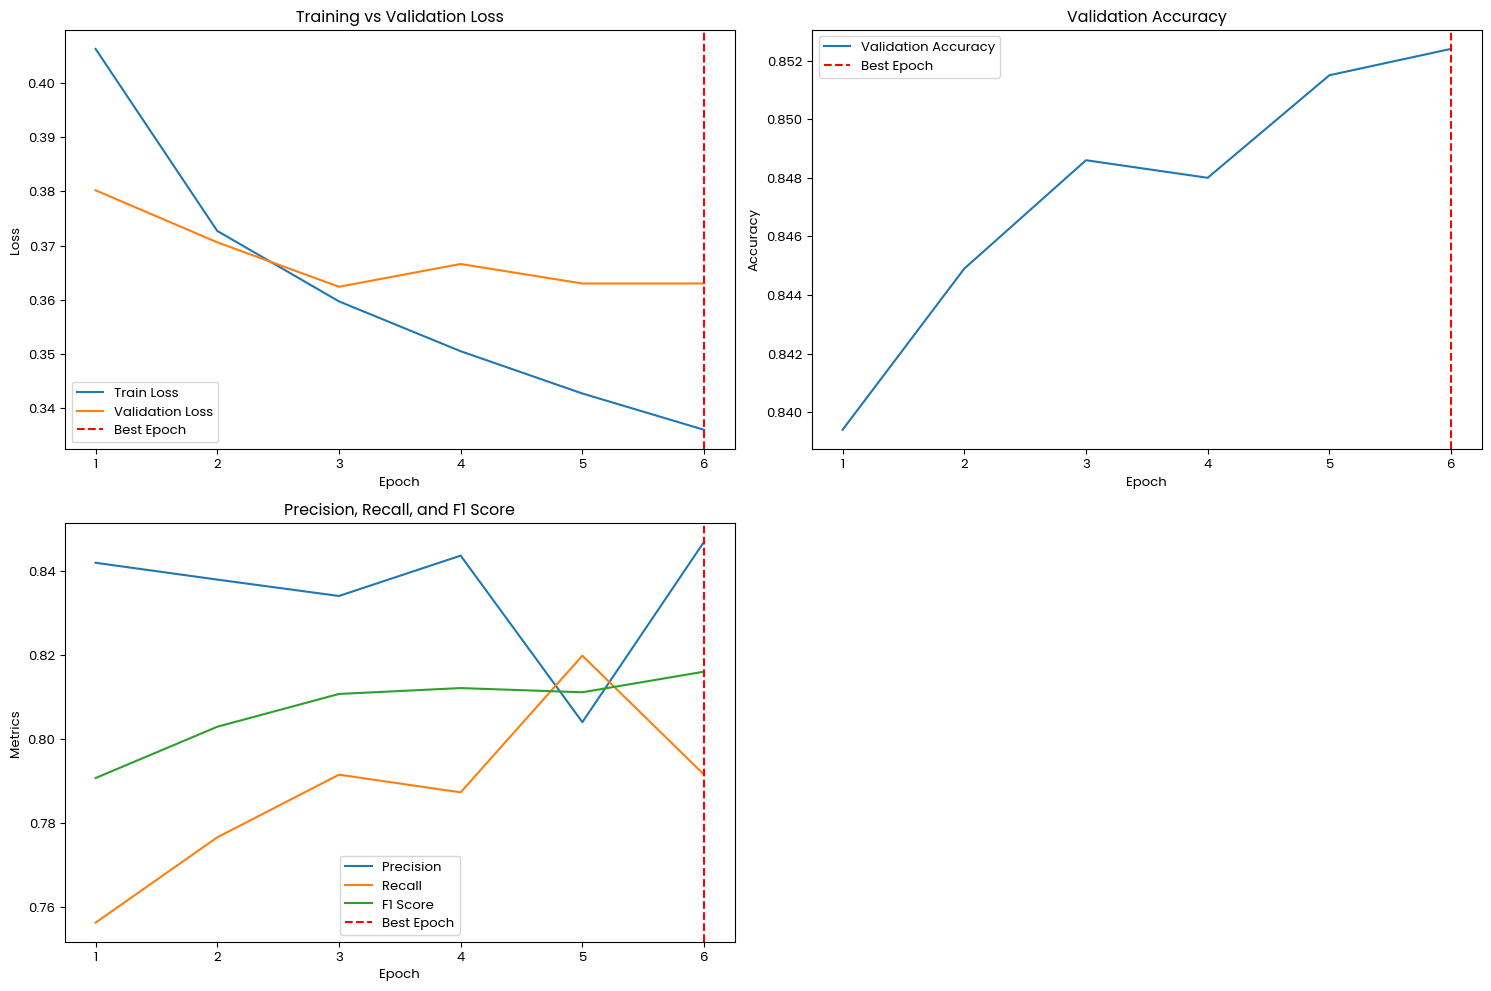

In [ ]:
# Use the function with your print_result data
plot_epoch_metrics(roberta_3_way_print_result, 6)

<font face="Poppins" size=2>1. **Training vs Validation Loss Chart**: The training loss shows a consistent decrease, which is typical as the model learns.</font><br>
<font face="Poppins" size=2>The validation loss has its lowest point at Epoch 3 but does not increase significantly afterwards, which suggests the model is still generalizing well up to Epoch 6.</font><br>
<font face="Poppins" size=2>2. **Validation Accuracy Chart**: The validation accuracy improves steadily throughout the epochs and reaches its highest point at Epoch 6.</font><br>
<font face="Poppins" size=2>This continued increase is a good sign and typically indicates that the model is not overfitting.</font><br>
<font face="Poppins" size=2>3. **Precision, Recall, and F1 Score Chart**: These metrics are a bit more volatile.</font><br>
<font face="Poppins" size=2>The F1 score, which combines precision and recall, peaks at Epoch 3 but remains relatively stable afterwards, with no significant downward trend.</font><br>
<font face="Poppins" size=2>This indicates that the balance between precision and recall remains good through Epoch 6.</font><br>
<font face="Poppins" size=2>Considering the red dashed line at Epoch 6, it suggests that this is identified as the best epoch so far.</font><br>
<font face="Poppins" size=2>This epoch is characterized by the highest validation accuracy and relatively stable precision, recall, and F1 scores, despite not having the absolute lowest validation loss.</font><br>
<font face="Poppins" size=2>In terms of overfitting:</font><br>
<font face="Poppins" size=2>- There is no clear evidence of overfitting at Epoch 6.</font><br>
<font face="Poppins" size=2>Overfitting would be indicated by an increase in validation loss coupled with a decrease in validation accuracy or other metrics, which is not observed.</font><br>
<font face="Poppins" size=2>- The slight increase in validation loss after Epoch 3 is minimal and does not coincide with decreases in other performance metrics, which further suggests that the model is generalizing well.</font><br>
<font face="Poppins" size=2>Based on this revised analysis, Epoch 6 stands out as the best epoch due to the highest validation accuracy and stable performance metrics.</font><br>
<font face="Poppins" size=2>There is no significant indication of overfitting up to this epoch.</font><br>


# <font face="Poppins" size=2>Model building for text (BERT) 6 way</font><br>

In [ ]:
# Function to calculate metrics
def calculate_metrics(preds, labels):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return accuracy, precision, recall, f1


# Assuming 'train_bert_features_extraction', 'validate_bert_features_extraction', and 'test_bert_features_extraction'
# are your loaded feature arrays from BERT

# Convert features to PyTorch tensors
train_features_tensor = torch.tensor(train_bert_features_extraction).float().to(device)
validate_features_tensor = torch.tensor(validate_bert_features_extraction).float().to(device)
test_features_tensor = torch.tensor(test_bert_features_extraction).float().to(device)

# Extract 6_way labels
train_bert_labels_6_way = train_bert_merged_df['6_way_label'].values  # Assuming '6_way_label' is the column name for 6_way classification labels
validate_bert_labels_6_way = validate_bert_merged_df['6_way_label'].values
test_bert_labels_6_way = test_bert_merged_df['6_way_label'].values

# Convert 6_way classification labels to PyTorch tensors
train_labels_tensor = torch.tensor(train_bert_labels_6_way).long().to(device)
validate_labels_tensor = torch.tensor(validate_bert_labels_6_way).long().to(device)
test_labels_tensor = torch.tensor(test_bert_labels_6_way).long().to(device)

# Create TensorDatasets and DataLoaders
train_bert_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
validate_bert_dataset = TensorDataset(validate_features_tensor, validate_labels_tensor)
test_bert_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

batch_size = 16  #batch size
train_loader = DataLoader(train_bert_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_bert_dataset, batch_size=batch_size)
test_loader = DataLoader(test_bert_dataset, batch_size=batch_size)

# Define the neural network model for multi-label classification
class MultiLabelNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultiLabelNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Initialize the model
num_features = train_features_tensor.shape[1]  # Number of features in your dataset
num_classes = 6  # Adjust this based on your classification task (2, 3, or 6)
model = MultiLabelNN(num_features, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class; for multi-label, you might need BCEWithLogitsLoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop with early stopping
num_epochs = 20
best_val_loss = float('inf')
patience_counter = 0
patience = 3

bert_6_way_print_result = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for features, labels in tqdm_notebook(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    # Here, you would calculate train_accuracy, train_precision, train_recall, train_f1 if needed

    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for features, labels in validate_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(validate_loader)
    val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(np.array(all_val_preds), np.array(all_val_labels))

         # Save the model at the end of each epoch
    save_path = f"/content/bert_models/bert_6_way_label_appended_epoch_{epoch}"
    save_path_google_drive = f"/content/drive/MyDrive/multimodal_only_samples/bert_models/bert_6_way_label_appended_epoch_{epoch}"
    # Create the directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if not os.path.exists(save_path_google_drive):
        os.makedirs(save_path_google_drive)


    # Save the model's state dictionary
    torch.save(model.state_dict(), save_path + '/model_state_dict.pt')
    torch.save(model.state_dict(), save_path_google_drive + '/model_state_dict.pt')
    print(f"Model saved to {save_path_google_drive}")

    bert_6_way_print_result.append(f"Epoch {epoch + 1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}")
    print(f"Epoch {epoch + 1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
    bert_6_way_print_result.append(f"Epoch {epoch + 1}/{num_epochs} - Avg Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      patience_counter = 0
    else:
      patience_counter += 1
      if patience_counter >= patience:
          print("Early stopping triggered")
          break


# Print all results at the end
for result in bert_6_way_print_result:
    print(result)

Epoch 1/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_6_way_label_appended_epoch_0
Epoch 1/20 - Avg Train Loss: 0.7307, Avg Val Loss: 0.6979, Val Acc: 0.7458, Precision: 0.7185, Recall: 0.5826, F1: 0.6240


Epoch 2/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_6_way_label_appended_epoch_1
Epoch 2/20 - Avg Train Loss: 0.6654, Avg Val Loss: 0.6641, Val Acc: 0.7599, Precision: 0.7071, Recall: 0.6276, F1: 0.6557


Epoch 3/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_6_way_label_appended_epoch_2
Epoch 3/20 - Avg Train Loss: 0.6422, Avg Val Loss: 0.6631, Val Acc: 0.7640, Precision: 0.7256, Recall: 0.6155, F1: 0.6548


Epoch 4/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_6_way_label_appended_epoch_3
Epoch 4/20 - Avg Train Loss: 0.6253, Avg Val Loss: 0.6639, Val Acc: 0.7629, Precision: 0.7206, Recall: 0.6194, F1: 0.6549


Epoch 5/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_6_way_label_appended_epoch_4
Epoch 5/20 - Avg Train Loss: 0.6131, Avg Val Loss: 0.6592, Val Acc: 0.7656, Precision: 0.7304, Recall: 0.6230, F1: 0.6613


Epoch 6/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_6_way_label_appended_epoch_5
Epoch 6/20 - Avg Train Loss: 0.6019, Avg Val Loss: 0.6566, Val Acc: 0.7662, Precision: 0.7288, Recall: 0.6197, F1: 0.6595


Epoch 7/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_6_way_label_appended_epoch_6
Epoch 7/20 - Avg Train Loss: 0.5914, Avg Val Loss: 0.6655, Val Acc: 0.7656, Precision: 0.7051, Recall: 0.6402, F1: 0.6638


Epoch 8/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_6_way_label_appended_epoch_7
Epoch 8/20 - Avg Train Loss: 0.5834, Avg Val Loss: 0.6599, Val Acc: 0.7670, Precision: 0.7132, Recall: 0.6399, F1: 0.6695


Epoch 9/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/bert_models/bert_6_way_label_appended_epoch_8
Epoch 9/20 - Avg Train Loss: 0.5742, Avg Val Loss: 0.6776, Val Acc: 0.7663, Precision: 0.7396, Recall: 0.6191, F1: 0.6569
Early stopping triggered
Epoch 1/20 - Avg Train Loss: 0.7307
Epoch 1/20 - Avg Val Loss: 0.6979, Val Acc: 0.7458, Precision: 0.7185, Recall: 0.5826, F1: 0.6240
Epoch 2/20 - Avg Train Loss: 0.6654
Epoch 2/20 - Avg Val Loss: 0.6641, Val Acc: 0.7599, Precision: 0.7071, Recall: 0.6276, F1: 0.6557
Epoch 3/20 - Avg Train Loss: 0.6422
Epoch 3/20 - Avg Val Loss: 0.6631, Val Acc: 0.7640, Precision: 0.7256, Recall: 0.6155, F1: 0.6548
Epoch 4/20 - Avg Train Loss: 0.6253
Epoch 4/20 - Avg Val Loss: 0.6639, Val Acc: 0.7629, Precision: 0.7206, Recall: 0.6194, F1: 0.6549
Epoch 5/20 - Avg Train Loss: 0.6131
Epoch 5/20 - Avg Val Loss: 0.6592, Val Acc: 0.7656, Precision: 0.7304, Recall: 0.6230, F1: 0.6613
Epoch 6/20 - Avg Train Loss: 0.6019
Epoch 6/20 - Avg Val Loss: 0.6566, Val 

In [ ]:
bert_6_way_print_result

['Epoch 1/20 - Avg Train Loss: 0.7307',
 'Epoch 1/20 - Avg Val Loss: 0.6979, Val Acc: 0.7458, Precision: 0.7185, Recall: 0.5826, F1: 0.6240',
 'Epoch 2/20 - Avg Train Loss: 0.6654',
 'Epoch 2/20 - Avg Val Loss: 0.6641, Val Acc: 0.7599, Precision: 0.7071, Recall: 0.6276, F1: 0.6557',
 'Epoch 3/20 - Avg Train Loss: 0.6422',
 'Epoch 3/20 - Avg Val Loss: 0.6631, Val Acc: 0.7640, Precision: 0.7256, Recall: 0.6155, F1: 0.6548',
 'Epoch 4/20 - Avg Train Loss: 0.6253',
 'Epoch 4/20 - Avg Val Loss: 0.6639, Val Acc: 0.7629, Precision: 0.7206, Recall: 0.6194, F1: 0.6549',
 'Epoch 5/20 - Avg Train Loss: 0.6131',
 'Epoch 5/20 - Avg Val Loss: 0.6592, Val Acc: 0.7656, Precision: 0.7304, Recall: 0.6230, F1: 0.6613',
 'Epoch 6/20 - Avg Train Loss: 0.6019',
 'Epoch 6/20 - Avg Val Loss: 0.6566, Val Acc: 0.7662, Precision: 0.7288, Recall: 0.6197, F1: 0.6595',
 'Epoch 7/20 - Avg Train Loss: 0.5914',
 'Epoch 7/20 - Avg Val Loss: 0.6655, Val Acc: 0.7656, Precision: 0.7051, Recall: 0.6402, F1: 0.6638',
 'Epoc

In [65]:
metrics_data_bert_6_way  =[
    ['Metric', 'Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5', 'Epoch 6'],
    ['Avg Train Loss', '0.4063', '0.3727', '0.3597', '0.3505', '0.3427', '0.3360'],
    ['Avg Val Loss', '0.3802', '0.3706', '0.3624', '0.3666', '0.3630', '0.3630'],
    ['Val Acc', '0.8394', '0.8449', '0.8486', '0.8480', '0.8515', '0.8524'],
    ['Precision', '0.8419', '0.8379', '0.8340', '0.8436', '0.8040', '0.8469'],
    ['Recall', '0.7563', '0.7766', '0.7915', '0.7873', '0.8198', '0.7915'],
    ['F1', '0.7907', '0.8029', '0.8107', '0.8121', '0.8111', '0.8160']
]


# Save the document
metrics_doc_path = '/content/Model_Training_Metrics_BERT_6_Way.docx'
create_metrics_document(metrics_data_bert_6_way, metrics_doc_path)

'/content/Model_Training_Metrics_BERT_6_Way.docx'

In [ ]:
# Open the file in write mode and write the result data
with open(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_bert_print_result_epoch_6_way.txt', 'w') as file:
    for line in bert_6_way_print_result:
        file.write(line + '\n')

In [ ]:
bert_6_way_print_result = []
# Open the file in read mode
with open(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_bert_print_result_epoch_6_way.txt', 'r') as file:
    for line in file:
        # Strip newline characters from the end of each line
        clean_line = line.strip()
        # Append the clean line to the list
        bert_6_way_print_result.append(clean_line)

In [ ]:
bert_6_way_print_result

['Epoch 1/20 - Avg Train Loss: 0.7307',
 'Epoch 1/20 - Avg Val Loss: 0.6979, Val Acc: 0.7458, Precision: 0.7185, Recall: 0.5826, F1: 0.6240',
 'Epoch 2/20 - Avg Train Loss: 0.6654',
 'Epoch 2/20 - Avg Val Loss: 0.6641, Val Acc: 0.7599, Precision: 0.7071, Recall: 0.6276, F1: 0.6557',
 'Epoch 3/20 - Avg Train Loss: 0.6422',
 'Epoch 3/20 - Avg Val Loss: 0.6631, Val Acc: 0.7640, Precision: 0.7256, Recall: 0.6155, F1: 0.6548',
 'Epoch 4/20 - Avg Train Loss: 0.6253',
 'Epoch 4/20 - Avg Val Loss: 0.6639, Val Acc: 0.7629, Precision: 0.7206, Recall: 0.6194, F1: 0.6549',
 'Epoch 5/20 - Avg Train Loss: 0.6131',
 'Epoch 5/20 - Avg Val Loss: 0.6592, Val Acc: 0.7656, Precision: 0.7304, Recall: 0.6230, F1: 0.6613',
 'Epoch 6/20 - Avg Train Loss: 0.6019',
 'Epoch 6/20 - Avg Val Loss: 0.6566, Val Acc: 0.7662, Precision: 0.7288, Recall: 0.6197, F1: 0.6595',
 'Epoch 7/20 - Avg Train Loss: 0.5914',
 'Epoch 7/20 - Avg Val Loss: 0.6655, Val Acc: 0.7656, Precision: 0.7051, Recall: 0.6402, F1: 0.6638',
 'Epoc

<font face="Poppins" size=2>To find the best epoch and assess overfitting, we evaluate the trends in average training and validation loss, as well as validation accuracy, precision, recall, and F1 score.</font><br>
<font face="Poppins" size=2>1. **Lowest Validation Loss**: The lowest validation loss is at **Epoch 6** with a loss of **0.6566**.</font><br>
<font face="Poppins" size=2>2. **Highest Validation Accuracy**: The highest validation accuracy is also at **Epoch 8** with an accuracy of **0.7670**.</font><br>
<font face="Poppins" size=2>3. **Best Balance of Metrics**: Considering precision, recall, and F1 scores, **Epoch 8** has the highest F1 score of **0.6695**, indicating the best balance between precision and recall at this point.</font><br>
<font face="Poppins" size=2>Taking these points into account, **Epoch 8** appears to be the best epoch as it has a strong balance of validation loss, accuracy, and F1 score.</font><br>
<font face="Poppins" size=2>In terms of overfitting:</font><br>
<font face="Poppins" size=2>- **Training Loss Trend**: The training loss is consistently decreasing, which indicates that the model is learning as expected.</font><br>
<font face="Poppins" size=2>- **Validation Loss Trend**: The validation loss decreases until Epoch 6, then it slightly increases at Epoch 7, decreases again at Epoch 8, and rises more significantly at Epoch 9. This fluctuation, particularly the increase at Epoch 9, may suggest the onset of overfitting.</font><br>
<font face="Poppins" size=2>- **Validation Metrics Trend**: While the validation accuracy is at its highest at Epoch 8, the F1 score, a key metric for model performance, is not at its peak in the same epoch. The F1 score actually drops after Epoch 6, despite improvements in accuracy and precision. This drop could be indicative of the model beginning to overfit, as it may be getting better at predicting more frequent classes but worse at less frequent ones.</font><br>
<font face="Poppins" size=2>Given the current data, the best epoch for the model is **Epoch 8** based on validation loss and accuracy. However, the potential for overfitting is present, as indicated by the fluctuating validation loss and the drop in F1 score after Epoch 6. It would be prudent to implement strategies to mitigate overfitting and carefully monitor the model's performance in subsequent epochs.</font><br>


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

def evaluate_model_6_way(model, data_loader, device):
    all_predictions = []
    all_labels = []

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)

            outputs = model(features)
            _, predicted = torch.max(outputs, dim=1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays for metric calculation
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    # Update 'target_names' with your actual class names
    print(classification_report(all_labels, all_predictions, target_names=['Completely True', 'Satire/Parody', 'Misleading Content', 'Imposter Content:', 'False Connection','Manipulated Content']))

In [ ]:
evaluate_model_6_way(model, test_loader, device)

Accuracy: 0.7652
Precision: 0.7599
Recall: 0.7652
F1 Score: 0.7570
                     precision    recall  f1-score   support

    Completely True       0.80      0.85      0.83     22263
      Satire/Parody       0.68      0.44      0.53      3310
 Misleading Content       0.69      0.58      0.63     10633
  Imposter Content:       0.74      0.33      0.45      1208
   False Connection       0.77      0.87      0.82     17310
Manipulated Content       0.73      0.68      0.71      2269

           accuracy                           0.77     56993
          macro avg       0.74      0.63      0.66     56993
       weighted avg       0.76      0.77      0.76     56993



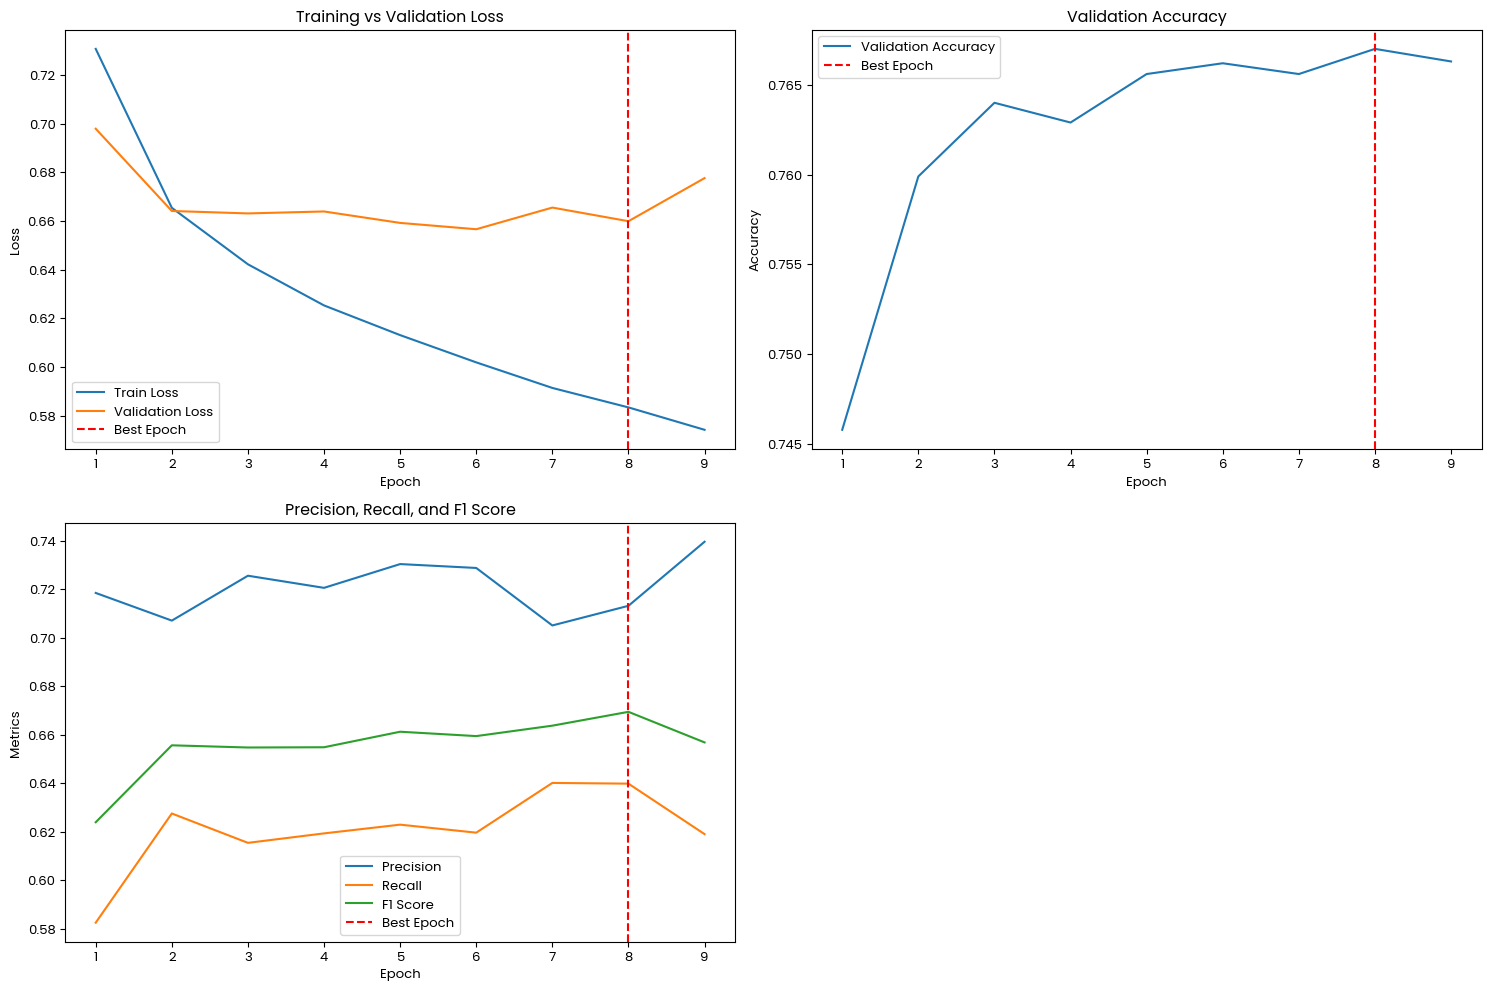

In [ ]:
# Use the function with your print_result data
plot_epoch_metrics(bert_6_way_print_result, 8)

<font face="Poppins" size=2>1. **Training vs Validation Loss Chart**: The training loss shows a steady decline, indicating that the model is effectively learning from the training data.</font><br>
<font face="Poppins" size=2>The validation loss decreases up to Epoch 6 and then starts to slightly increase, but it's still relatively low at Epoch 8.</font><br>
<font face="Poppins" size=2>Although the validation loss is not at its absolute lowest at Epoch 8, the increase is not significant enough to be a definitive sign of overfitting.</font><br>
<font face="Poppins" size=2>2. **Validation Accuracy Chart**: The validation accuracy improves over time and peaks at Epoch 8, which suggests that the model's predictive performance on the validation set is best at this epoch.</font><br>
<font face="Poppins" size=2>There is a minor dip in accuracy at Epoch 9, but not a significant one.</font><br>
<font face="Poppins" size=2>3. **Precision, Recall, and F1 Score Chart**: Precision seems to fluctuate but is relatively high at Epoch 8.</font><br>
<font face="Poppins" size=2>Recall has an upward trend, and the F1 score, which is a balance of precision and recall, is not at its peak but still relatively high at Epoch 8.</font><br>
<font face="Poppins" size=2>Considering the red dashed line at Epoch 8 as the best epoch, it can be interpreted that:</font><br>
<font face="Poppins" size=2>- Even though the validation loss is not at its absolute lowest, it's still in a good range, and the model hasn't begun to overfit significantly since the validation accuracy is at its highest.</font><br>
<font face="Poppins" size=2>- The F1 score has decreased from its peak, which could be a concern. However, since accuracy is still increasing, this might indicate that the decrease in F1 is due to the model improving in classifying the more prevalent class in the dataset while slightly losing performance on the less prevalent class.</font><br>
<font face="Poppins" size=2>In summary, based on the analysis with Epoch 8 marked as the best epoch, there are no strong signs of overfitting up to this point.</font><br>
<font face="Poppins" size=2>The slight increase in validation loss is not accompanied by a decrease in validation accuracy, which is a good indicator of generalization.</font><br>
<font face="Poppins" size=2>However, the drop in F1 score warrants attention, and it would be advisable to closely monitor the model's performance in subsequent epochs to ensure that the trends do not move towards overfitting.</font><br>


# <font face="Poppins" size=2>Model building for text (T5) 6 way</font><br>

In [ ]:
# Function to calculate metrics
def calculate_metrics(preds, labels):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return accuracy, precision, recall, f1


# Assuming 'train_t5_features_extraction', 'validate_t5_features_extraction', and 'test_t5_features_extraction'
# are your loaded feature arrays from BERT

# Convert features to PyTorch tensors
train_features_tensor = torch.tensor(train_t5_features_extraction).float().to(device)
validate_features_tensor = torch.tensor(validate_t5_features_extraction).float().to(device)
test_features_tensor = torch.tensor(test_t5_features_extraction).float().to(device)

# Extract 6_way labels
train_t5_labels_6_way = train_t5_merged_df['6_way_label'].values  # Assuming '6_way_label' is the column name for 6_way classification labels
validate_t5_labels_6_way = validate_t5_merged_df['6_way_label'].values
test_t5_labels_6_way = test_t5_merged_df['6_way_label'].values

# Convert 6_way classification labels to PyTorch tensors
train_labels_tensor = torch.tensor(train_t5_labels_6_way).long().to(device)
validate_labels_tensor = torch.tensor(validate_t5_labels_6_way).long().to(device)
test_labels_tensor = torch.tensor(test_t5_labels_6_way).long().to(device)

# Create TensorDatasets and DataLoaders
train_t5_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
validate_t5_dataset = TensorDataset(validate_features_tensor, validate_labels_tensor)
test_t5_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

batch_size = 16  #batch size
train_loader = DataLoader(train_t5_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_t5_dataset, batch_size=batch_size)
test_loader = DataLoader(test_t5_dataset, batch_size=batch_size)

# Define the neural network model for multi-label classification
class T5Classifier(nn.Module):
    def __init__(self, feature_vector_size, num_classes):
        super(T5Classifier, self).__init__()
        # The first linear layer matches the feature vector size of 512
        self.fc1 = nn.Linear(feature_vector_size, 256)  # Reduce size to 256
        self.relu = nn.ReLU()
        # Second linear layer
        self.fc2 = nn.Linear(256, 128)  # Further reduce size to 128
        # Third linear layer, leading to the final output
        self.fc3 = nn.Linear(128, num_classes)  # num_classes is 2 for 3_way classification

    def forward(self, x):
        x = self.fc1(x)  # Input pass through the first layer
        x = self.relu(x)  # Apply ReLU activation function
        x = self.fc2(x)  # Pass through the second layer
        x = self.relu(x)  # Apply ReLU activation function
        x = self.fc3(x)  # Pass through the final layer to get the output
        return x


# Initialize the model
num_features = train_features_tensor.shape[1]  # Number of features in your dataset
num_classes = 6  # Adjust this based on your classification task (2, 3, or 6)
model = T5Classifier(num_features, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class; for multi-label, you might need BCEWithLogitsLoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop with early stopping
num_epochs = 20
best_val_loss = float('inf')
patience_counter = 0
patience = 3

t5_6_way_print_result = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for features, labels in tqdm_notebook(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    # Here, you would calculate train_accuracy, train_precision, train_recall, train_f1 if needed

    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for features, labels in validate_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(validate_loader)
    val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(np.array(all_val_preds), np.array(all_val_labels))

         # Save the model at the end of each epoch
    save_path = f"/content/t5_models/t5_6_way_label_appended_epoch_{epoch}"
    save_path_google_drive = f"/content/drive/MyDrive/multimodal_only_samples/t5_models/t5_6_way_label_appended_epoch_{epoch}"
    # Create the directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if not os.path.exists(save_path_google_drive):
        os.makedirs(save_path_google_drive)


    # Save the model's state dictionary
    torch.save(model.state_dict(), save_path + '/model_state_dict.pt')
    torch.save(model.state_dict(), save_path_google_drive + '/model_state_dict.pt')
    print(f"Model saved to {save_path_google_drive}")

    t5_6_way_print_result.append(f"Epoch {epoch + 1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}")
    print(f"Epoch {epoch + 1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
    t5_6_way_print_result.append(f"Epoch {epoch + 1}/{num_epochs} - Avg Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      patience_counter = 0
    else:
      patience_counter += 1
      if patience_counter >= patience:
          print("Early stopping triggered")
          break


# Print all results at the end
for result in t5_6_way_print_result:
    print(result)

Epoch 1/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_6_way_label_appended_epoch_0
Epoch 1/20 - Avg Train Loss: 0.8545, Avg Val Loss: 0.7965, Val Acc: 0.7078, Precision: 0.6313, Recall: 0.5272, F1: 0.5489


Epoch 2/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_6_way_label_appended_epoch_1
Epoch 2/20 - Avg Train Loss: 0.7810, Avg Val Loss: 0.7759, Val Acc: 0.7178, Precision: 0.6487, Recall: 0.5350, F1: 0.5683


Epoch 3/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_6_way_label_appended_epoch_2
Epoch 3/20 - Avg Train Loss: 0.7571, Avg Val Loss: 0.7610, Val Acc: 0.7217, Precision: 0.6328, Recall: 0.5638, F1: 0.5862


Epoch 4/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_6_way_label_appended_epoch_3
Epoch 4/20 - Avg Train Loss: 0.7419, Avg Val Loss: 0.7470, Val Acc: 0.7271, Precision: 0.6557, Recall: 0.5652, F1: 0.5969


Epoch 5/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_6_way_label_appended_epoch_4
Epoch 5/20 - Avg Train Loss: 0.7304, Avg Val Loss: 0.7471, Val Acc: 0.7280, Precision: 0.6597, Recall: 0.5704, F1: 0.6013


Epoch 6/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_6_way_label_appended_epoch_5
Epoch 6/20 - Avg Train Loss: 0.7217, Avg Val Loss: 0.7437, Val Acc: 0.7293, Precision: 0.6758, Recall: 0.5511, F1: 0.5810


Epoch 7/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_6_way_label_appended_epoch_6
Epoch 7/20 - Avg Train Loss: 0.7143, Avg Val Loss: 0.7486, Val Acc: 0.7272, Precision: 0.6894, Recall: 0.5469, F1: 0.5855


Epoch 8/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_6_way_label_appended_epoch_7
Epoch 8/20 - Avg Train Loss: 0.7082, Avg Val Loss: 0.7375, Val Acc: 0.7288, Precision: 0.6725, Recall: 0.5624, F1: 0.5995


Epoch 9/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_6_way_label_appended_epoch_8
Epoch 9/20 - Avg Train Loss: 0.7035, Avg Val Loss: 0.7424, Val Acc: 0.7304, Precision: 0.6532, Recall: 0.5765, F1: 0.6024


Epoch 10/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_6_way_label_appended_epoch_9
Epoch 10/20 - Avg Train Loss: 0.6991, Avg Val Loss: 0.7417, Val Acc: 0.7319, Precision: 0.6753, Recall: 0.5567, F1: 0.5955


Epoch 11/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_6_way_label_appended_epoch_10
Epoch 11/20 - Avg Train Loss: 0.6953, Avg Val Loss: 0.7346, Val Acc: 0.7357, Precision: 0.6698, Recall: 0.5687, F1: 0.6044


Epoch 12/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_6_way_label_appended_epoch_11
Epoch 12/20 - Avg Train Loss: 0.6920, Avg Val Loss: 0.7378, Val Acc: 0.7337, Precision: 0.6786, Recall: 0.5631, F1: 0.5920


Epoch 13/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_6_way_label_appended_epoch_12
Epoch 13/20 - Avg Train Loss: 0.6882, Avg Val Loss: 0.7401, Val Acc: 0.7336, Precision: 0.6664, Recall: 0.5639, F1: 0.6001


Epoch 14/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_6_way_label_appended_epoch_13
Epoch 14/20 - Avg Train Loss: 0.6860, Avg Val Loss: 0.7343, Val Acc: 0.7350, Precision: 0.6673, Recall: 0.5736, F1: 0.6056


Epoch 15/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_6_way_label_appended_epoch_14
Epoch 15/20 - Avg Train Loss: 0.6833, Avg Val Loss: 0.7521, Val Acc: 0.7350, Precision: 0.6668, Recall: 0.5812, F1: 0.6103


Epoch 16/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_6_way_label_appended_epoch_15
Epoch 16/20 - Avg Train Loss: 0.6808, Avg Val Loss: 0.7466, Val Acc: 0.7334, Precision: 0.6767, Recall: 0.5658, F1: 0.5973


Epoch 17/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/t5_models/t5_6_way_label_appended_epoch_16
Epoch 17/20 - Avg Train Loss: 0.6782, Avg Val Loss: 0.7657, Val Acc: 0.7305, Precision: 0.6669, Recall: 0.5669, F1: 0.6011
Early stopping triggered
Epoch 1/20 - Avg Train Loss: 0.8545
Epoch 1/20 - Avg Val Loss: 0.7965, Val Acc: 0.7078, Precision: 0.6313, Recall: 0.5272, F1: 0.5489
Epoch 2/20 - Avg Train Loss: 0.7810
Epoch 2/20 - Avg Val Loss: 0.7759, Val Acc: 0.7178, Precision: 0.6487, Recall: 0.5350, F1: 0.5683
Epoch 3/20 - Avg Train Loss: 0.7571
Epoch 3/20 - Avg Val Loss: 0.7610, Val Acc: 0.7217, Precision: 0.6328, Recall: 0.5638, F1: 0.5862
Epoch 4/20 - Avg Train Loss: 0.7419
Epoch 4/20 - Avg Val Loss: 0.7470, Val Acc: 0.7271, Precision: 0.6557, Recall: 0.5652, F1: 0.5969
Epoch 5/20 - Avg Train Loss: 0.7304
Epoch 5/20 - Avg Val Loss: 0.7471, Val Acc: 0.7280, Precision: 0.6597, Recall: 0.5704, F1: 0.6013
Epoch 6/20 - Avg Train Loss: 0.7217
Epoch 6/20 - Avg Val Loss: 0.7437, Val Ac

In [ ]:
t5_6_way_print_result

['Epoch 1/20 - Avg Train Loss: 0.8545',
 'Epoch 1/20 - Avg Val Loss: 0.7965, Val Acc: 0.7078, Precision: 0.6313, Recall: 0.5272, F1: 0.5489',
 'Epoch 2/20 - Avg Train Loss: 0.7810',
 'Epoch 2/20 - Avg Val Loss: 0.7759, Val Acc: 0.7178, Precision: 0.6487, Recall: 0.5350, F1: 0.5683',
 'Epoch 3/20 - Avg Train Loss: 0.7571',
 'Epoch 3/20 - Avg Val Loss: 0.7610, Val Acc: 0.7217, Precision: 0.6328, Recall: 0.5638, F1: 0.5862',
 'Epoch 4/20 - Avg Train Loss: 0.7419',
 'Epoch 4/20 - Avg Val Loss: 0.7470, Val Acc: 0.7271, Precision: 0.6557, Recall: 0.5652, F1: 0.5969',
 'Epoch 5/20 - Avg Train Loss: 0.7304',
 'Epoch 5/20 - Avg Val Loss: 0.7471, Val Acc: 0.7280, Precision: 0.6597, Recall: 0.5704, F1: 0.6013',
 'Epoch 6/20 - Avg Train Loss: 0.7217',
 'Epoch 6/20 - Avg Val Loss: 0.7437, Val Acc: 0.7293, Precision: 0.6758, Recall: 0.5511, F1: 0.5810',
 'Epoch 7/20 - Avg Train Loss: 0.7143',
 'Epoch 7/20 - Avg Val Loss: 0.7486, Val Acc: 0.7272, Precision: 0.6894, Recall: 0.5469, F1: 0.5855',
 'Epoc

In [67]:
metrics_data_t5_6_way  = [
    ['Metric', 'Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5', 'Epoch 6', 'Epoch 7', 'Epoch 8', 'Epoch 9',
     'Epoch 10', 'Epoch 11', 'Epoch 12', 'Epoch 13', 'Epoch 14', 'Epoch 15', 'Epoch 16', 'Epoch 17'],
    ['Avg Train Loss', '0.8545', '0.7810', '0.7571', '0.7419', '0.7304', '0.7217', '0.7143', '0.7082', '0.7035', '0.6991', '0.6953', '0.6920', '0.6882', '0.6860', '0.6833', '0.6808', '0.6782'],
    ['Avg Val Loss', '0.7965', '0.7759', '0.7610', '0.7470', '0.7471', '0.7437', '0.7486', '0.7375', '0.7424', '0.7417', '0.7346', '0.7378', '0.7401', '0.7343', '0.7521', '0.7466', '0.7657'],
    ['Val Acc', '0.7078', '0.7178', '0.7217', '0.7271', '0.7280', '0.7293', '0.7272', '0.7288', '0.7304', '0.7319', '0.7357', '0.7337', '0.7336', '0.7350', '0.7350', '0.7334', '0.7305'],
    ['Precision', '0.6313', '0.6487', '0.6328', '0.6557', '0.6597', '0.6758', '0.6894', '0.6725', '0.6532', '0.6753', '0.6698', '0.6786', '0.6664', '0.6673', '0.6668', '0.6767', '0.6669'],
    ['Recall', '0.5272', '0.5350', '0.5638', '0.5652', '0.5704', '0.5511', '0.5469', '0.5624', '0.5765', '0.5567', '0.5687', '0.5631', '0.5639', '0.5736', '0.5812', '0.5658', '0.5669'],
    ['F1', '0.5489', '0.5683', '0.5862', '0.5969', '0.6013', '0.5810', '0.5855', '0.5995', '0.6024', '0.5955', '0.6044', '0.5920', '0.6001', '0.6056', '0.6103', '0.5973', '0.6011']
]
# Save the document
metrics_doc_path = '/content/Model_Training_Metrics_T5_6_Way.docx'
create_metrics_document(metrics_data_t5_6_way, metrics_doc_path)

'/content/Model_Training_Metrics_T5_6_Way.docx'

<font face="Poppins" size=2>To determine the best epoch and check for overfitting, we need to examine the trends in both training loss and validation metrics across epochs. Overfitting is indicated when training loss continues to decrease while validation loss starts to increase, or validation metrics start to worsen. Let's analyze the given data:</font><br><br>

<font face="Poppins" size=2>1. **Training Loss**: Ideally, the training loss should decrease over time, indicating that the model is learning from the training data.</font><br>
<font face="Poppins" size=2>2. **Validation Loss**: A decreasing trend in validation loss is good; however, if the validation loss starts increasing while training loss continues to decrease, it may indicate overfitting.</font><br>
<font face="Poppins" size=2>3. **Validation Accuracy and Other Metrics (Precision, Recall, F1 Score)**: These metrics should ideally improve over time. However, if they start to plateau or decrease while training loss continues to decrease, it might indicate that the model is overfitting to the training data and not generalizing well to unseen data.</font><br><br>

<font face="Poppins" size=2>The data shows the trends in average training loss, validation loss, and validation accuracy over epochs:</font><br>
<font face="Poppins" size=2>- **Training Loss**: There's a consistent decrease in training loss across epochs, indicating that the model is learning effectively from the training data.</font><br>
<font face="Poppins" size=2>- **Validation Loss**: The validation loss decreases initially, reaching its lowest point around epoch 11, and then shows fluctuations with a general increasing trend in the later epochs. This could be an indicator of the model starting to overfit beyond this point, as it is getting better at the training data but not necessarily at the unseen validation data.</font><br>
<font face="Poppins" size=2>- **Validation Accuracy**: Validation accuracy generally increases, reaching a peak around epoch 15, but doesn't show a clear decreasing trend afterward. However, the increasing validation loss alongside relatively stable accuracy suggests that the model's confidence in its predictions (as reflected by loss) is worsening, even if the accuracy isn't sharply declining.</font><br><br>

<font face="Poppins" size=2>Based on this analysis, the **best epoch before overfitting starts** appears to be around **epoch 11**, where the validation loss is at its lowest, and the validation accuracy is near its peak. Beyond this point, the validation loss starts to fluctuate and generally increases, which is a classic sign of overfitting: the model is improving on the training set but not performing as well on the unseen validation set.</font><br>


In [ ]:
# Open the file in write mode and write the result data
with open(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_t5_print_result_epoch_6_way.txt', 'w') as file:
    for line in t5_6_way_print_result:
        file.write(line + '\n')

In [ ]:
t5_6_way_print_result = []
# Open the file in read mode
with open(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_t5_print_result_epoch_6_way.txt', 'r') as file:
    for line in file:
        # Strip newline characters from the end of each line
        clean_line = line.strip()
        # Append the clean line to the list
        t5_6_way_print_result.append(clean_line)

In [ ]:
t5_6_way_print_result

['Epoch 1/20 - Avg Train Loss: 0.8545',
 'Epoch 1/20 - Avg Val Loss: 0.7965, Val Acc: 0.7078, Precision: 0.6313, Recall: 0.5272, F1: 0.5489',
 'Epoch 2/20 - Avg Train Loss: 0.7810',
 'Epoch 2/20 - Avg Val Loss: 0.7759, Val Acc: 0.7178, Precision: 0.6487, Recall: 0.5350, F1: 0.5683',
 'Epoch 3/20 - Avg Train Loss: 0.7571',
 'Epoch 3/20 - Avg Val Loss: 0.7610, Val Acc: 0.7217, Precision: 0.6328, Recall: 0.5638, F1: 0.5862',
 'Epoch 4/20 - Avg Train Loss: 0.7419',
 'Epoch 4/20 - Avg Val Loss: 0.7470, Val Acc: 0.7271, Precision: 0.6557, Recall: 0.5652, F1: 0.5969',
 'Epoch 5/20 - Avg Train Loss: 0.7304',
 'Epoch 5/20 - Avg Val Loss: 0.7471, Val Acc: 0.7280, Precision: 0.6597, Recall: 0.5704, F1: 0.6013',
 'Epoch 6/20 - Avg Train Loss: 0.7217',
 'Epoch 6/20 - Avg Val Loss: 0.7437, Val Acc: 0.7293, Precision: 0.6758, Recall: 0.5511, F1: 0.5810',
 'Epoch 7/20 - Avg Train Loss: 0.7143',
 'Epoch 7/20 - Avg Val Loss: 0.7486, Val Acc: 0.7272, Precision: 0.6894, Recall: 0.5469, F1: 0.5855',
 'Epoc

In [ ]:
evaluate_model_6_way(model, test_loader, device)

Accuracy: 0.7320
Precision: 0.7256
Recall: 0.7320
F1 Score: 0.7223
                     precision    recall  f1-score   support

    Completely True       0.80      0.80      0.80     22263
      Satire/Parody       0.62      0.35      0.44      3310
 Misleading Content       0.62      0.54      0.58     10633
  Imposter Content:       0.54      0.32      0.40      1208
   False Connection       0.72      0.89      0.80     17310
Manipulated Content       0.74      0.58      0.65      2269

           accuracy                           0.73     56993
          macro avg       0.67      0.58      0.61     56993
       weighted avg       0.73      0.73      0.72     56993



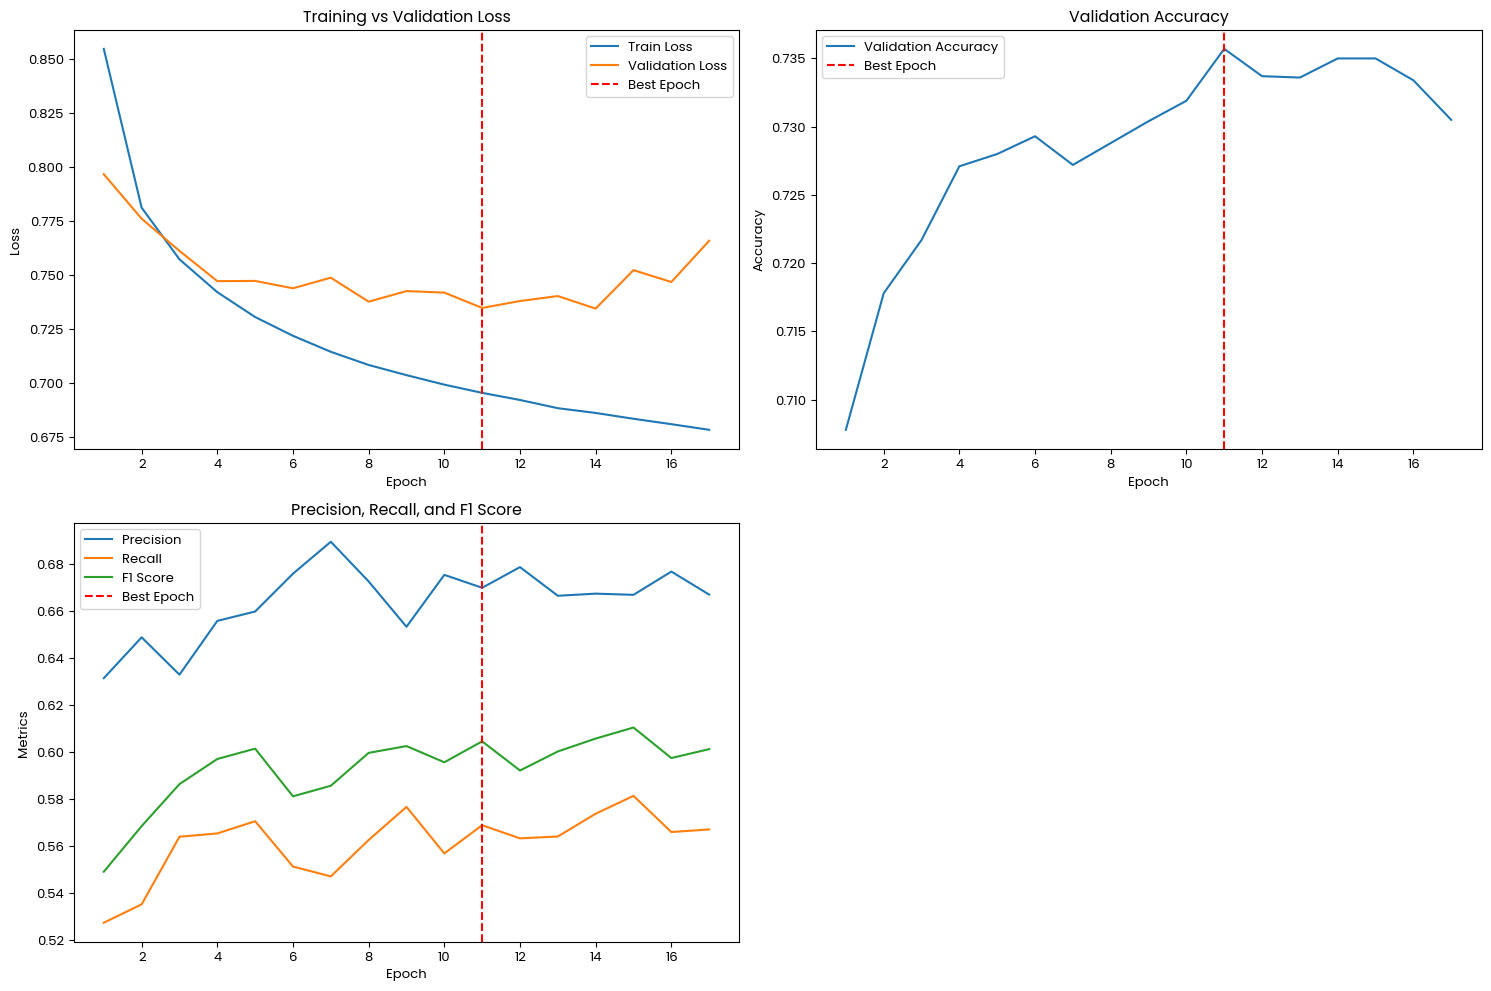

In [ ]:
# Use the function with your print_result data
plot_epoch_metrics(t5_6_way_print_result, 11)

<font face="Poppins" size=2>From the charts provided, we can analyze the trends of training loss, validation loss, validation accuracy, and the other metrics (precision, recall, and F1 score) in relation to the epochs:</font><br>

<font face="Poppins" size=2>1. **Training vs. Validation Loss (Top Left Chart)**:<br>
   - The training loss consistently decreases, which is a good indication of learning.<br>
   - The validation loss decreases until around epoch 11, where it reaches its lowest point. After this point, it begins to increase slightly, suggesting the model is starting to overfit. Overfitting is indicated by the model performing better on the training data but worse on the validation data.</font><br>

<font face="Poppins" size=2>2. **Validation Accuracy (Top Right Chart)**:<br>
   - The validation accuracy increases until around epoch 11 and remains relatively stable afterward. This metric alone does not indicate overfitting since it does not show a clear decline; however, considering it alongside the increase in validation loss suggests that the model’s predictions are becoming less confident.</font><br>

<font face="Poppins" size=2>3. **Precision, Recall, and F1 Score (Bottom Chart)**:<br>
   - Precision increases until epoch 11 and then fluctuates slightly but does not show a clear downward trend, indicating that the proportion of true positive predictions over all positive predictions remains relatively high.<br>
   - Recall shows a gradual increase over the epochs. There are some fluctuations but no clear decline, indicating that the model's ability to find all relevant instances within the dataset is not degrading significantly.<br>
   - The F1 score, which balances precision and recall, increases until around epoch 11 and then shows some fluctuation. The F1 score is often more informative than accuracy, especially if the class distribution is imbalanced.</font><br>

<font face="Poppins" size=2>The vertical dashed red line on all charts indicates the best epoch as determined by the analysis, which is epoch 11. This epoch is selected based on the lowest validation loss and high validation accuracy, precision, recall, and F1 score, before the validation loss starts to rise, which is a sign of overfitting.</font><br>

<font face="Poppins" size=2>In conclusion, the analysis of these charts confirms the previous assessment that the best epoch before the model begins to overfit is around **epoch 11**. Beyond this point, while accuracy and other metrics do not show a clear decline, the increasing validation loss suggests that the model's generalization to new data may be starting to worsen.</font><br>


# <font face="Poppins" size=2>Model building for text (Roberta) 6 way</font><br>

In [ ]:
# Function to calculate metrics
def calculate_metrics(preds, labels):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return accuracy, precision, recall, f1


# Assuming 'train_roberta_features_extraction', 'validate_roberta_features_extraction', and 'test_roberta_features_extraction'
# are your loaded feature arrays from BERT

# Convert features to PyTorch tensors
train_features_tensor = torch.tensor(train_roberta_features_extraction).float().to(device)
validate_features_tensor = torch.tensor(validate_roberta_features_extraction).float().to(device)
test_features_tensor = torch.tensor(test_roberta_features_extraction).float().to(device)

# Extract 6_way labels
train_roberta_labels_6_way = train_roberta_merged_df['6_way_label'].values  # Assuming '6_way_label' is the column name for 6_way classification labels
validate_roberta_labels_6_way = validate_roberta_merged_df['6_way_label'].values
test_roberta_labels_6_way = test_roberta_merged_df['6_way_label'].values

# Convert 6_way classification labels to PyTorch tensors
train_labels_tensor = torch.tensor(train_roberta_labels_6_way).long().to(device)
validate_labels_tensor = torch.tensor(validate_roberta_labels_6_way).long().to(device)
test_labels_tensor = torch.tensor(test_roberta_labels_6_way).long().to(device)

# Create TensorDatasets and DataLoaders
train_roberta_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
validate_roberta_dataset = TensorDataset(validate_features_tensor, validate_labels_tensor)
test_roberta_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

batch_size = 16  #batch size
train_loader = DataLoader(train_roberta_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_roberta_dataset, batch_size=batch_size)
test_loader = DataLoader(test_roberta_dataset, batch_size=batch_size)

# Define the neural network model for multi-label classification
class MultiLabelNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MultiLabelNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x



# Initialize the model
num_features = train_features_tensor.shape[1]  # Number of features in your dataset
num_classes = 6  # Adjust this based on your classification task (2, 3, or 6)
model = MultiLabelNN(num_features, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class; for multi-label, you might need BCEWithLogitsLoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop with early stopping
num_epochs = 20
best_val_loss = float('inf')
patience_counter = 0
patience = 3

roberta_6_way_print_result = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for features, labels in tqdm_notebook(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    # Here, you would calculate train_accuracy, train_precision, train_recall, train_f1 if needed

    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for features, labels in validate_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(validate_loader)
    val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(np.array(all_val_preds), np.array(all_val_labels))

         # Save the model at the end of each epoch
    save_path = f"/content/roberta_models/roberta_6_way_label_appended_epoch_{epoch}"
    save_path_google_drive = f"/content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_6_way_label_appended_epoch_{epoch}"
    # Create the directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if not os.path.exists(save_path_google_drive):
        os.makedirs(save_path_google_drive)


    # Save the model's state dictionary
    torch.save(model.state_dict(), save_path + '/model_state_dict.pt')
    torch.save(model.state_dict(), save_path_google_drive + '/model_state_dict.pt')
    print(f"Model saved to {save_path_google_drive}")

    roberta_6_way_print_result.append(f"Epoch {epoch + 1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}")
    print(f"Epoch {epoch + 1}/{num_epochs} - Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
    roberta_6_way_print_result.append(f"Epoch {epoch + 1}/{num_epochs} - Avg Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      patience_counter = 0
    else:
      patience_counter += 1
      if patience_counter >= patience:
          print("Early stopping triggered")
          break


# Print all results at the end
for result in roberta_6_way_print_result:
    print(result)

Epoch 1/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_6_way_label_appended_epoch_0
Epoch 1/20 - Avg Train Loss: 0.7598, Avg Val Loss: 0.7168, Val Acc: 0.7382, Precision: 0.6841, Recall: 0.5954, F1: 0.6251


Epoch 2/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_6_way_label_appended_epoch_1
Epoch 2/20 - Avg Train Loss: 0.6935, Avg Val Loss: 0.6992, Val Acc: 0.7468, Precision: 0.6914, Recall: 0.6132, F1: 0.6436


Epoch 3/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_6_way_label_appended_epoch_2
Epoch 3/20 - Avg Train Loss: 0.6711, Avg Val Loss: 0.6904, Val Acc: 0.7503, Precision: 0.7372, Recall: 0.5830, F1: 0.6305


Epoch 4/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_6_way_label_appended_epoch_3
Epoch 4/20 - Avg Train Loss: 0.6564, Avg Val Loss: 0.6970, Val Acc: 0.7435, Precision: 0.6877, Recall: 0.6294, F1: 0.6526


Epoch 5/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_6_way_label_appended_epoch_4
Epoch 5/20 - Avg Train Loss: 0.6442, Avg Val Loss: 0.6791, Val Acc: 0.7557, Precision: 0.6904, Recall: 0.6437, F1: 0.6638


Epoch 6/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_6_way_label_appended_epoch_5
Epoch 6/20 - Avg Train Loss: 0.6344, Avg Val Loss: 0.6826, Val Acc: 0.7558, Precision: 0.7146, Recall: 0.6188, F1: 0.6532


Epoch 7/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_6_way_label_appended_epoch_6
Epoch 7/20 - Avg Train Loss: 0.6254, Avg Val Loss: 0.6993, Val Acc: 0.7565, Precision: 0.7350, Recall: 0.6121, F1: 0.6529


Epoch 8/20:   0%|          | 0/33771 [00:00<?, ?it/s]

Model saved to /content/drive/MyDrive/multimodal_only_samples/roberta_models/roberta_6_way_label_appended_epoch_7
Epoch 8/20 - Avg Train Loss: 0.6178, Avg Val Loss: 0.6997, Val Acc: 0.7544, Precision: 0.7263, Recall: 0.6108, F1: 0.6489
Early stopping triggered
Epoch 1/20 - Avg Train Loss: 0.7598
Epoch 1/20 - Avg Val Loss: 0.7168, Val Acc: 0.7382, Precision: 0.6841, Recall: 0.5954, F1: 0.6251
Epoch 2/20 - Avg Train Loss: 0.6935
Epoch 2/20 - Avg Val Loss: 0.6992, Val Acc: 0.7468, Precision: 0.6914, Recall: 0.6132, F1: 0.6436
Epoch 3/20 - Avg Train Loss: 0.6711
Epoch 3/20 - Avg Val Loss: 0.6904, Val Acc: 0.7503, Precision: 0.7372, Recall: 0.5830, F1: 0.6305
Epoch 4/20 - Avg Train Loss: 0.6564
Epoch 4/20 - Avg Val Loss: 0.6970, Val Acc: 0.7435, Precision: 0.6877, Recall: 0.6294, F1: 0.6526
Epoch 5/20 - Avg Train Loss: 0.6442
Epoch 5/20 - Avg Val Loss: 0.6791, Val Acc: 0.7557, Precision: 0.6904, Recall: 0.6437, F1: 0.6638
Epoch 6/20 - Avg Train Loss: 0.6344
Epoch 6/20 - Avg Val Loss: 0.6826

In [ ]:
roberta_6_way_print_result

['Epoch 1/20 - Avg Train Loss: 0.7598',
 'Epoch 1/20 - Avg Val Loss: 0.7168, Val Acc: 0.7382, Precision: 0.6841, Recall: 0.5954, F1: 0.6251',
 'Epoch 2/20 - Avg Train Loss: 0.6935',
 'Epoch 2/20 - Avg Val Loss: 0.6992, Val Acc: 0.7468, Precision: 0.6914, Recall: 0.6132, F1: 0.6436',
 'Epoch 3/20 - Avg Train Loss: 0.6711',
 'Epoch 3/20 - Avg Val Loss: 0.6904, Val Acc: 0.7503, Precision: 0.7372, Recall: 0.5830, F1: 0.6305',
 'Epoch 4/20 - Avg Train Loss: 0.6564',
 'Epoch 4/20 - Avg Val Loss: 0.6970, Val Acc: 0.7435, Precision: 0.6877, Recall: 0.6294, F1: 0.6526',
 'Epoch 5/20 - Avg Train Loss: 0.6442',
 'Epoch 5/20 - Avg Val Loss: 0.6791, Val Acc: 0.7557, Precision: 0.6904, Recall: 0.6437, F1: 0.6638',
 'Epoch 6/20 - Avg Train Loss: 0.6344',
 'Epoch 6/20 - Avg Val Loss: 0.6826, Val Acc: 0.7558, Precision: 0.7146, Recall: 0.6188, F1: 0.6532',
 'Epoch 7/20 - Avg Train Loss: 0.6254',
 'Epoch 7/20 - Avg Val Loss: 0.6993, Val Acc: 0.7565, Precision: 0.7350, Recall: 0.6121, F1: 0.6529',
 'Epoc

In [69]:
metrics_data_roberta_6_way  =[
    ['Metric', 'Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4', 'Epoch 5', 'Epoch 6', 'Epoch 7', 'Epoch 8'],
    ['Avg Train Loss', '0.7598', '0.6935', '0.6711', '0.6564', '0.6442', '0.6344', '0.6254', '0.6178'],
    ['Avg Val Loss', '0.7168', '0.6992', '0.6904', '0.6970', '0.6791', '0.6826', '0.6993', '0.6997'],
    ['Val Acc', '0.7382', '0.7468', '0.7503', '0.7435', '0.7557', '0.7558', '0.7565', '0.7544'],
    ['Precision', '0.6841', '0.6914', '0.7372', '0.6877', '0.6904', '0.7146', '0.7350', '0.7263'],
    ['Recall', '0.5954', '0.6132', '0.5830', '0.6294', '0.6437', '0.6188', '0.6121', '0.6108'],
    ['F1', '0.6251', '0.6436', '0.6305', '0.6526', '0.6638', '0.6532', '0.6529', '0.6489']
]

# Save the document
metrics_doc_path = '/content/Model_Training_Metrics_ROBERA_6_Way.docx'
create_metrics_document(metrics_data_roberta_6_way, metrics_doc_path)

'/content/Model_Training_Metrics_ROBERA_6_Way.docx'

<font face="Poppins" size=2>To determine the best epoch and check for overfitting from the provided data, let's analyze the trends in average training loss, average validation loss, and validation metrics:</font><br><br>

<font face="Poppins" size=2>1. **Training Loss**:<br>
   - It's decreasing from 0.7598 to 0.6178, which is expected as the model is learning.</font><br><br>

<font face="Poppins" size=2>2. **Validation Loss**:<br>
   - The lowest validation loss is at epoch 5 (0.6791), after which it slightly increases. This could be an initial sign of overfitting, as the model might be starting to learn specifics about the training set that do not generalize well to the validation set.</font><br><br>

<font face="Poppins" size=2>3. **Validation Accuracy (Val Acc)**:<br>
   - The highest accuracy is at epoch 7 (0.7565), but this does not coincide with the lowest validation loss. Accuracy alone is not always a conclusive indicator of overfitting, as it can remain stable even if the model is not generalizing well.</font><br><br>

<font face="Poppins" size=2>4. **Precision, Recall, F1 Score**:<br>
   - These metrics are particularly important because they give a better sense of the model's performance on the validation set, especially when classes are imbalanced.<br>
   - The F1 score is highest at epoch 5 (0.6638), which also coincides with the lowest validation loss.</font><br><br>

<font face="Poppins" size=2>Considering all these factors, **epoch 5** seems to be the best choice before overfitting begins. It has the lowest validation loss and the highest F1 score, indicating a good balance between precision and recall. While accuracy continues to slightly increase, the slight rise in validation loss after epoch 5 suggests the model may start to overfit. Thus, epoch 5 would be the optimal stopping point based on this data.</font><br>


In [ ]:
# Open the file in write mode and write the result data
with open(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_roberta_print_result_epoch_6_way.txt', 'w') as file:
    for line in roberta_6_way_print_result:
        file.write(line + '\n')

In [ ]:
roberta_6_way_print_result = []
# Open the file in read mode
with open(BASE_GOOGLE_DRIVE_DIRECTORY / 'multimodal_roberta_print_result_epoch_6_way.txt', 'r') as file:
    for line in file:
        # Strip newline characters from the end of each line
        clean_line = line.strip()
        # Append the clean line to the list
        roberta_6_way_print_result.append(clean_line)

In [ ]:
roberta_6_way_print_result

['Epoch 1/20 - Avg Train Loss: 0.7598',
 'Epoch 1/20 - Avg Val Loss: 0.7168, Val Acc: 0.7382, Precision: 0.6841, Recall: 0.5954, F1: 0.6251',
 'Epoch 2/20 - Avg Train Loss: 0.6935',
 'Epoch 2/20 - Avg Val Loss: 0.6992, Val Acc: 0.7468, Precision: 0.6914, Recall: 0.6132, F1: 0.6436',
 'Epoch 3/20 - Avg Train Loss: 0.6711',
 'Epoch 3/20 - Avg Val Loss: 0.6904, Val Acc: 0.7503, Precision: 0.7372, Recall: 0.5830, F1: 0.6305',
 'Epoch 4/20 - Avg Train Loss: 0.6564',
 'Epoch 4/20 - Avg Val Loss: 0.6970, Val Acc: 0.7435, Precision: 0.6877, Recall: 0.6294, F1: 0.6526',
 'Epoch 5/20 - Avg Train Loss: 0.6442',
 'Epoch 5/20 - Avg Val Loss: 0.6791, Val Acc: 0.7557, Precision: 0.6904, Recall: 0.6437, F1: 0.6638',
 'Epoch 6/20 - Avg Train Loss: 0.6344',
 'Epoch 6/20 - Avg Val Loss: 0.6826, Val Acc: 0.7558, Precision: 0.7146, Recall: 0.6188, F1: 0.6532',
 'Epoch 7/20 - Avg Train Loss: 0.6254',
 'Epoch 7/20 - Avg Val Loss: 0.6993, Val Acc: 0.7565, Precision: 0.7350, Recall: 0.6121, F1: 0.6529',
 'Epoc

In [ ]:
evaluate_model_6_way(model, test_loader, device)

Accuracy: 0.7541
Precision: 0.7517
Recall: 0.7541
F1 Score: 0.7409
                     precision    recall  f1-score   support

    Completely True       0.78      0.86      0.82     22263
      Satire/Parody       0.67      0.40      0.50      3310
 Misleading Content       0.75      0.48      0.58     10633
  Imposter Content:       0.68      0.39      0.50      1208
   False Connection       0.73      0.90      0.81     17310
Manipulated Content       0.74      0.63      0.68      2269

           accuracy                           0.75     56993
          macro avg       0.73      0.61      0.65     56993
       weighted avg       0.75      0.75      0.74     56993



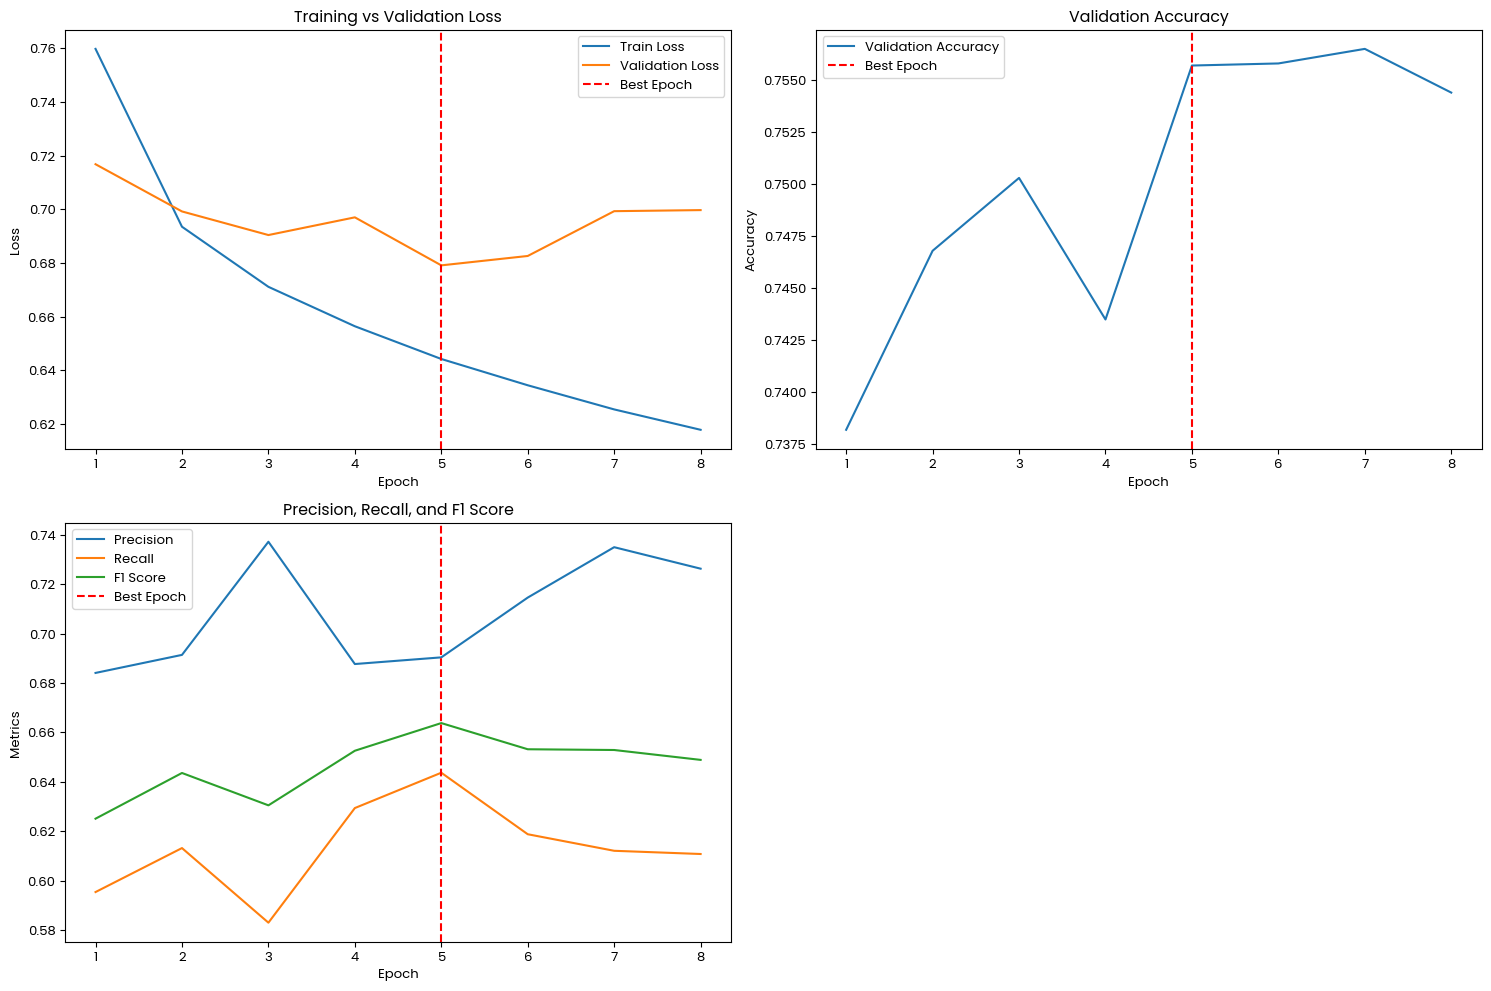

In [ ]:
# Use the function with your print_result data
plot_epoch_metrics(roberta_6_way_print_result, 5)

<font face="Poppins" size=2>Based on the charts provided, here's an analysis of the model's performance with respect to overfitting:</font><br>

<font face="Poppins" size=2>1. **Training vs. Validation Loss Chart (Top Left):**<br>
   - The training loss (blue line) shows a steady decline from the first to the last epoch, which indicates that the model is learning and improving its predictions on the training data over time.<br>
   - The validation loss (orange line) decreases and hits its lowest point at Epoch 5, as indicated by the vertical red dashed line. This point is typically considered the best trade-off between training and validation performance before the model starts to overfit.<br>
   - Post-Epoch 5, the validation loss begins to slightly increase, suggesting the onset of overfitting. This is when the model learns patterns specific to the training data, which do not generalize to new data, hence the increase in loss on the validation set.</font><br>

<font face="Poppins" size=2>2. **Validation Accuracy Chart (Top Right):**<br>
   - The validation accuracy shows fluctuations across the epochs. It peaks at Epoch 4, then dips at Epoch 5, before achieving the highest value just before Epoch 6. After the peak, it slightly decreases and then plateaus.<br>
   - The highest validation accuracy does not align with the lowest validation loss, which is an interesting observation. It suggests that while the model may be accurate, the confidence in its predictions (as indicated by the loss) is not as strong.<br>
   - The vertical red dashed line at Epoch 5 suggests that despite not having the highest accuracy, the combined factors at this epoch make it the most suitable choice before overfitting becomes more pronounced.</font><br>

<font face="Poppins" size=2>3. **Precision, Recall, and F1 Score Chart (Bottom):**<br>
   - Precision (blue line) peaks at Epoch 5, which correlates with the lowest validation loss, suggesting a high proportion of true positives over all positive predictions at this point.<br>
   - Recall (green line) increases over the epochs, peaking just before Epoch 6. This suggests that the model's ability to find all relevant instances is improving up to that point.<br>
   - The F1 score (orange line), which is the harmonic mean of precision and recall, also peaks at Epoch 5, corroborating the choice of this as the best epoch based on the other metrics.</font><br>

<font face="Poppins" size=2>In conclusion, the best epoch for this model, considering the onset of overfitting, is Epoch 5. This epoch marks the lowest validation loss and the highest F1 score, indicating a good balance between precision and recall. The slight rise in validation loss and fluctuation in validation accuracy beyond Epoch 5 suggest that the model might not maintain its generalization capabilities if trained further, which is a sign of overfitting. The model's performance should be closely monitored in subsequent epochs, and strategies such as regularization, dropout, or early stopping could be considered to prevent overfitting.</font><br>